In [1]:
# Mounting google drive
# from google.colab import drive
# drive.mount('/content/drive', force_remount= True)

In [2]:
# !pip install efficientnet

In [1]:
# Importing required libraries
import os
import random
import numpy
import pandas
import matplotlib.pyplot as plt
import cv2
import efficientnet.keras
import tensorflow
from tensorflow import keras
import torch
import sklearn.metrics
import time
import warnings
warnings.filterwarnings('ignore')
import collections
import openpyxl
import shutil
import gc
import sklearnex
gc.collect()

0

In [2]:
numpy.set_printoptions(threshold= numpy.inf)
numpy.random.seed(seed= 10)
tensorflow.random.set_seed(10)

In [3]:
sklearnex.patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [4]:
print(torch.cuda.is_available())
if torch.cuda.is_available():
    print(torch.cuda.get_device_name())

False


In [5]:
os.chdir(r"D:\Files\Data Science\Self projects\Classification projects\Leaf diseases multi classification dataset")

(64, 64, 3)


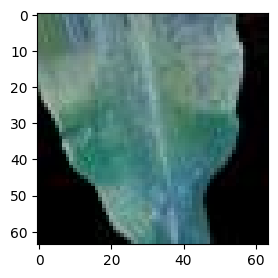

In [6]:
image= cv2.imread(filename= os.path.join(os.getcwd(), "Training", "Common rust", "Common rust_3.jpeg"))
print(image.shape)
plt.figure(figsize= (3, 3))
plt.imshow(image)
plt.show()

(256, 256, 3)


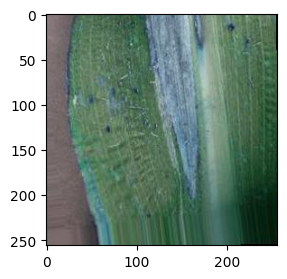

In [7]:
image= cv2.imread(filename= os.path.join(os.getcwd(), "Training", "Corn blight", "Corn Blight_2.jpeg"))
print(image.shape)
plt.figure(figsize= (3, 3))
plt.imshow(image)
plt.show()

(256, 256, 3)


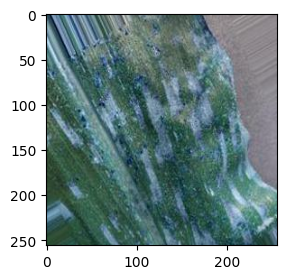

In [8]:
image= cv2.imread(filename= os.path.join(os.getcwd(), "Training", "Gray leaf", "Gray Leaf_2.jpeg"))
print(image.shape)
plt.figure(figsize= (3, 3))
plt.imshow(image)
plt.show()

(256, 256, 3)


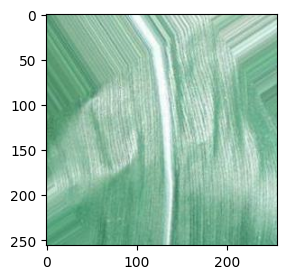

In [9]:
image= cv2.imread(filename= os.path.join(os.getcwd(), "Training", "Healthy leaf", "Healthy leaf_2.jpeg"))
print(image.shape)
plt.figure(figsize= (3, 3))
plt.imshow(image)
plt.show()

In [10]:
# Defining generators
train_path= os.path.join(os.getcwd(), "Training")
# Performing Data augmentation : a technique to increase the diversity of your training set by applying random (but realistic) transformations,
# such as image rotation, etc.
train_generator= keras.preprocessing.image.ImageDataGenerator(rescale= 1.0/ 255, rotation_range= 0, width_shift_range= 0.0, height_shift_range= 0.0, shear_range= 0.0, zoom_range= 0.0,
   horizontal_flip= False).flow_from_directory(train_path, target_size= (256, 256), batch_size= 2, shuffle= True, class_mode= 'categorical') # Data is given in batch size of 32
# Image can randomly rotate from -40 to 40 degree, Images can shift randomly left or right by 20 % of total width, Images can shift randomly up or down
# by 20 % of total height, ImageDataGenerator will randomly chose a number between 0 and the given range, Shearing means to pull any one edge of the photo
# and converting a square into a rhombus, horizontal_flip means mirror image along vertical axis of the image.
# There is no need to apply all these transformations on validation and test set.
test_path= os.path.join(os.getcwd(), "Testing")
test_generator= keras.preprocessing.image.ImageDataGenerator(rescale= 1.0/ 255).flow_from_directory(test_path, target_size= (256, 256),
                                                                 batch_size= 2, shuffle=True, class_mode= 'categorical')
validation_path= os.path.join(os.getcwd(), "Validation")
validation_generator= keras.preprocessing.image.ImageDataGenerator(rescale= 1.0/ 255).flow_from_directory(validation_path, target_size= (256, 256),
                                                                 batch_size= 2, shuffle=True, class_mode= 'categorical') # Data is given in batch size of 2 images

Found 20896 images belonging to 4 classes.
Found 2612 images belonging to 4 classes.
Found 2612 images belonging to 4 classes.


In [11]:
# # Defining generators
# train_path= os.path.join(os.getcwd(), "Training")
# # Performing Data augmentation : a technique to increase the diversity of your training set by applying random (but realistic) transformations,
# # such as image rotation, etc.
# train_generator= keras.preprocessing.image.ImageDataGenerator(rescale= 1.0/ 255, rotation_range= 40, width_shift_range= 0.2, height_shift_range= 0.2, shear_range= 0.2, zoom_range= 0.2,
#    horizontal_flip= True).flow_from_directory(train_path, target_size= (256, 256), batch_size= 2, shuffle= True, class_mode= 'categorical') # Data is given in batch size of 32
# # Image can randomly rotate from -40 to 40 degree, Images can shift randomly left or right by 20 % of total width, Images can shift randomly up or down
# # by 20 % of total height, ImageDataGenerator will randomly chose a number between 0 and the given range, Shearing means to pull any one edge of the photo
# # and converting a square into a rhombus, horizontal_flip means mirror image along vertical axis of the image.
# # There is no need to apply all these transformations on validation and test set.
# test_path= os.path.join(os.getcwd(), "Testing")
# test_generator= keras.preprocessing.image.ImageDataGenerator(rescale= 1.0/ 255).flow_from_directory(test_path, target_size= (256, 256),
#                                                                  batch_size= 2, shuffle=True, class_mode= 'categorical')
# validation_path= os.path.join(os.getcwd(), "Validation")
# validation_generator= keras.preprocessing.image.ImageDataGenerator(rescale= 1.0/ 255).flow_from_directory(validation_path, target_size= (256, 256),
#                                                                  batch_size= 2, shuffle=True, class_mode= 'categorical') # Data is given in batch size of 2 images

In [12]:
train_length= 5224
test_length= 653
validation_length= 653
batch_size= 2
model_folder_path= os.path.join(os.getcwd(), "Saved models")

In [54]:
def vizualize_model_performance(model):
#     model_folder_path= os.path.join(os.getcwd(), "Saved models")
#     model= keras.models.load_model(filepath= os.path.join(model_folder_path, saved_model_name))
    classes= list(train_generator.class_indices.keys())
    actual_list= []
    prediction_list= []
    t1= time.time()
    for folder in os.listdir(os.path.join(os.getcwd(), "Testing")):
        for img in os.listdir(os.path.join(os.getcwd(), "Testing", folder)):
            image= cv2.imread(filename= os.path.join(os.getcwd(), "Testing", folder, img))
            image = cv2.normalize(src= image, dst= None, alpha= 0, beta= 1.0, norm_type= cv2.NORM_MINMAX, dtype=cv2.CV_32F)
            image= cv2.resize(src= image, dsize= (256, 256))
            prediction= model.predict(x= image.reshape(1, 256, 256, 3))
            max_value_index= numpy.argmax(a= prediction[0])
            predicted_class= classes[max_value_index]
            print("Prediction is :", predicted_class)
            actual_list.append(folder)
            prediction_list.append(predicted_class)
    t2= time.time()
    print()
    print('Time taken for all predictions is :', round((t2- t1), 3), 'seconds.')
    print("Counter of predictions is :", collections.Counter(prediction_list))

    print("Accuracy score is :", sklearn.metrics.accuracy_score(y_true= actual_list, y_pred= prediction_list))
    print("Classification report is : \n", sklearn.metrics.classification_report(y_true= actual_list, y_pred= prediction_list))
    print("Confusion matrix is : \n", sklearn.metrics.confusion_matrix(y_true= actual_list, y_pred= prediction_list))

    cm = sklearn.metrics.confusion_matrix(y_true= actual_list, y_pred= prediction_list, labels= classes, normalize= None)
    cmd = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix= cm, display_labels= classes)
    figure, axes = plt.subplots(nrows= 1, ncols= 1, figsize= (20, 20), squeeze= True)
    plt.rcParams.update({"font.size": 13, "font.weight": "bold"})
    plt.title(label= "Confusion matrix plot", fontweight= "bold", fontsize= 15)
    cmd.plot(ax= axes, cmap= "viridis", xticks_rotation= "horizontal")
    plt.xlabel(xlabel= "Predicted class", fontweight= "bold", fontsize= 15)
    plt.ylabel(ylabel= "True class", fontweight= "bold", fontsize= 15)
    plt.xticks(fontsize= 13, fontweight= "bold", rotation= 0)
    plt.yticks(fontsize= 13, fontweight= "bold", rotation= 0)
    plt.show()
#     del model
#     keras.backend.clear_session()
#     gc.collect()
    return None

In [19]:
# Convolutional Neural Network model
model= keras.models.Sequential()
model.add(keras.layers.Conv2D(filters= 32, kernel_size= (3, 3), strides= (1, 1), padding= "valid", activation= "relu", input_shape= (256, 256, 3)))
model.add(keras.layers.MaxPooling2D(pool_size= (2, 2), strides= None, padding= "valid"))
model.add(keras.layers.Conv2D(filters= 64, kernel_size= (3, 3), strides= (1, 1), padding= "valid", activation= "relu", input_shape= (256, 256, 3)))
model.add(keras.layers.MaxPooling2D(pool_size= (2, 2), strides= None, padding= "valid"))
model.add(keras.layers.Conv2D(filters= 128, kernel_size= (3, 3), strides= (1, 1), padding= "valid", activation= "relu", input_shape= (256, 256, 3)))
model.add(keras.layers.MaxPooling2D(pool_size= (2, 2), strides= None, padding= "valid"))
model.add(keras.layers.Conv2D(filters= 128, kernel_size= (3, 3), strides= (1, 1), padding= "valid", activation= "relu", input_shape= (256, 256, 3)))
model.add(keras.layers.MaxPooling2D(pool_size= (2, 2), strides= None, padding= "valid"))
model.add(keras.layers.Flatten())  # We need single one dimensional array as input
model.add(keras.layers.Dropout(rate= 0.001)) # It will randomly pick 50 % of neurons and deactivate them during each epoch and model will be trained with the
# remaining neurons. Dropout is a very effective layer to avoid overfitting in model
model.add(keras.layers.Dense(512, activation= "relu"))
model.add(keras.layers.Dense(256, activation= "relu"))
model.add(keras.layers.Dense(4, activation= "softmax"))    # For multi classes classification
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 128)       0

In [3]:
9e-5+ 1

1.00009

In [20]:
# Compiling and model training
t1= time.time() # Starting of model training. We have 4 output classes
model.compile(loss= "categorical_crossentropy", optimizer= keras.optimizers.Adam(learning_rate= 9e-5), metrics= ['accuracy'])     # learning rate= 0.0001
# Using Callbacks : it allows us to save a model while training after each epoch : Early stopping and giving out best model
best_model= keras.callbacks.ModelCheckpoint(os.path.join(model_folder_path, "Early_stopping_best_model.h5"), save_best_only= True)
# patience= number of epochs with no improvement after which training will be stopped
early_stopping= keras.callbacks.EarlyStopping(patience= 25, restore_best_weights= True)
# train_generator generates data continuously in batch_size of 32 images. steps_per_epoch is given to mention stopping point : (10000// 32= 312)
# validation_steps= (800// 32= 25)
model_history= model.fit(train_generator, steps_per_epoch= (train_length// batch_size), epochs= 30, validation_data= validation_generator, validation_steps=
                         (validation_length// batch_size), callbacks= [best_model, early_stopping])
t2= time.time() # Ending of model training

Epoch 1/30


2612/2612 [==============================] - 334s 127ms/step - loss: 0.6413 - accuracy: 0.7004 - val_loss: 0.4603 - val_accuracy: 0.8052
Epoch 2/30
2612/2612 [==============================] - 310s 119ms/step - loss: 0.4398 - accuracy: 0.7975 - val_loss: 0.3818 - val_accuracy: 0.8374
Epoch 3/30
2612/2612 [==============================] - 308s 118ms/step - loss: 0.3369 - accuracy: 0.8503 - val_loss: 0.3028 - val_accuracy: 0.8635
Epoch 4/30
2612/2612 [==============================] - 308s 118ms/step - loss: 0.2730 - accuracy: 0.8809 - val_loss: 0.2199 - val_accuracy: 0.8926
Epoch 5/30
2612/2612 [==============================] - 308s 118ms/step - loss: 0.2421 - accuracy: 0.8993 - val_loss: 0.1777 - val_accuracy: 0.9264
Epoch 6/30
2612/2612 [==============================] - 306s 117ms/step - loss: 0.2391 - accuracy: 0.9035 - val_loss: 0.2023 - val_accuracy: 0.9172
Epoch 7/30
2612/2612 [==============================] - 306s 117ms/step - loss: 0.2114 - accuracy: 0.9146 - va

In [21]:
print('Training time is :', round((t2- t1)/ 60 , 3), 'minutes.')   # For CNN model

Training time is : 157.956 minutes.


In [22]:
# Saving - Restoring Models
model.save(os.path.join(model_folder_path, "multi_classification_cnn.h5"))
# Testing model on test set
model.evaluate(test_generator, steps= (test_length// batch_size) ) # test_steps= (200// 2= 100)

326/326 [==============================] - 7s 20ms/step - loss: 0.1756 - accuracy: 0.9601


[0.1756160855293274, 0.9601227045059204]

1/1 [==============================] - 0s 108ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 34ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 26ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 22ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 25ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 23ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 26ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 24ms/step
Prediction is : Healthy leaf
1/1 [==============================] - 0s 23ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 22ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 24ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 24ms/step
Prediction is : Common rust
1/1 [==============================] -

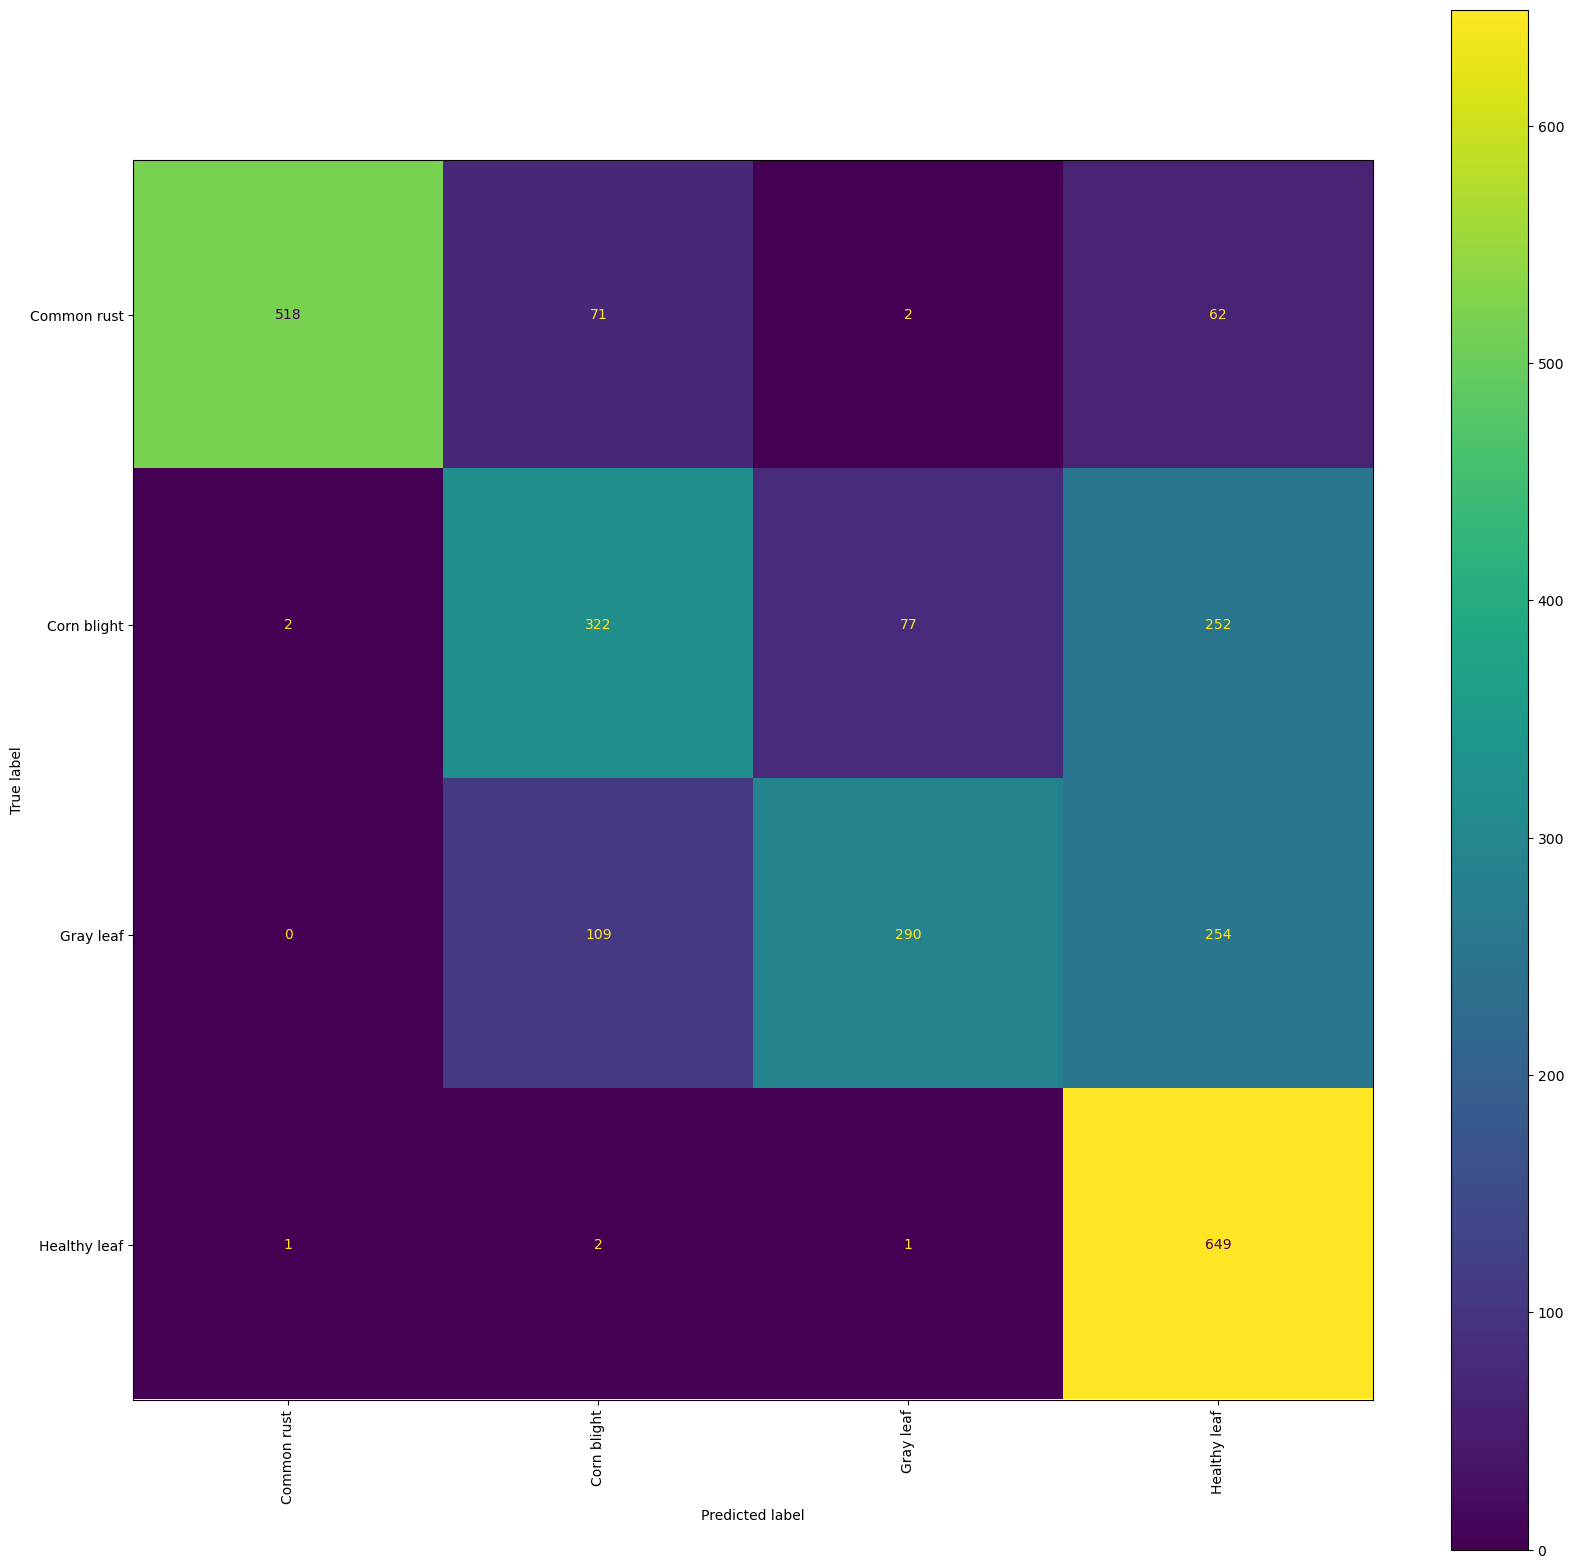

In [23]:
vizualize_model_performance(model)

In [24]:
model_history= pandas.DataFrame(data= model_history.history)
model_history

loss  accuracy  val_loss  val_accuracy
0   0.641270  0.700421  0.460274      0.805215
1   0.439759  0.797473  0.381836      0.837423
2   0.336910  0.850306  0.302794      0.863497
3   0.273002  0.880934  0.219878      0.892638
4   0.242109  0.899311  0.177669      0.926380
5   0.239099  0.903522  0.202284      0.917178
6   0.211374  0.914625  0.278188      0.895706
7   0.194627  0.924005  0.163596      0.950920
8   0.160150  0.937596  0.176998      0.918712
9   0.161844  0.939319  0.129202      0.944785
10  0.143714  0.946784  0.151690      0.938650
11  0.120786  0.953675  0.156056      0.937117
12  0.105591  0.959610  0.138118      0.957055
13  0.115860  0.959801  0.188547      0.923313
14  0.085710  0.967841  0.118307      0.953988
15  0.084363  0.971286  0.119120      0.957055
16  0.061817  0.978943  0.153517      0.941718
17  0.081033  0.973009  0.113271      0.960123
18  0.066609  0.977795  0.127428      0.967791
19  0.062990  0.979135  0.182367      0.935583
20  0.047752  0.983729  0.126433      0.964724
21  0.056969  0.982198  0.092698      0.969325
22  0.046706  0.985069  0.096463      0.964724
23  0.039031  0.987366  0.126674      0.966258
24  0.035015  0.986792  0.166233      0.960123
25  0.039300  0.987557  0.176942      0.941718
26  0.033218  0.990620  0.071523      0.975460
27  0.033224  0.990429  0.071854      0.963190
28  0.024271  0.993109  0.256478      0.947853
29  0.035853  0.988515  0.137246      0.960123

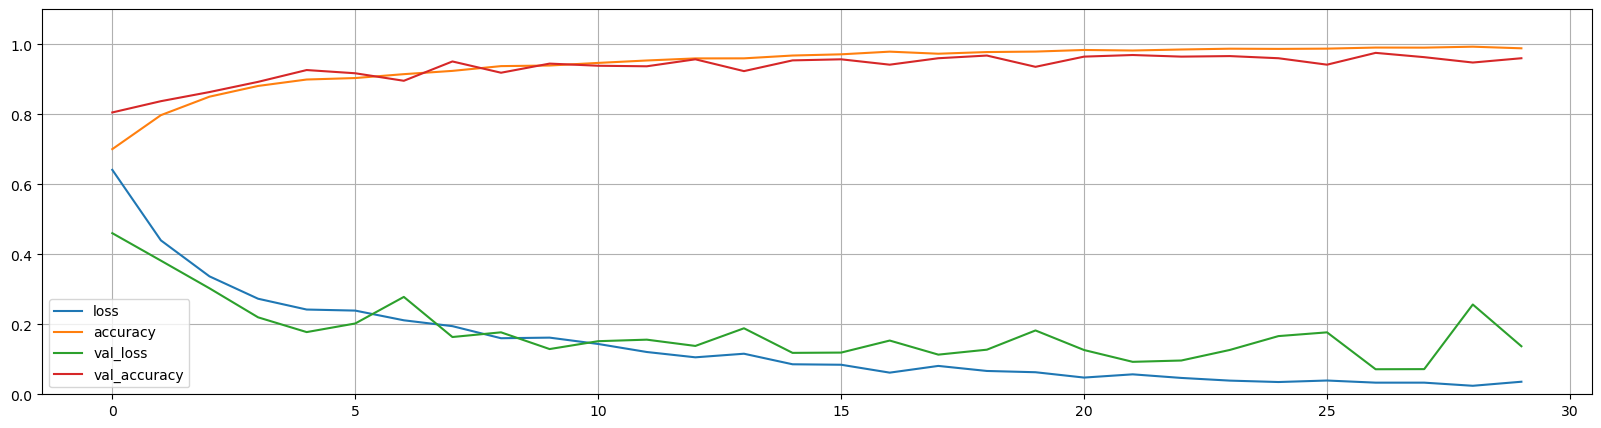

In [25]:
# Plotting model_history's loss and accuracy during each epoch
model_history.plot(figsize= (20, 5))
plt.grid(True)
# get current axes
plt.gca().set_ylim(0, 1.1)
plt.show()

In [18]:
del model
keras.backend.clear_session()
gc.collect()
# model= keras.models.load_model('model_name.h5')

10819

In [27]:
# Using Transfer learning
conv_base= tensorflow.keras.applications.VGG19(weights= "imagenet", include_top= False, input_shape= (256, 256, 3))
conv_base.trainable= False # we do not want to train the weights again so we are freezing the conv layer.
# VGG19 model
model= keras.models.Sequential()
model.add(conv_base)
model.add(keras.layers.Conv2D(filters= 32, kernel_size= (3, 3), strides= 1, padding= 'valid', activation= 'relu',
                              input_shape= (256, 256, 3) ))
model.add(keras.layers.MaxPooling2D( (2, 2) ))
model.add(keras.layers.Flatten())  # We need single one dimensional array as input
model.add(keras.layers.Dropout(0.5)) # It will randomly pick 50 % of neurons and deactivate them during each epoch and model will be trained with the
# remaining neurons. Dropout is a very effective layer to avoid overfitting in model
model.add(keras.layers.Dense(256, activation= 'relu'))
model.add(keras.layers.Dense(200, activation= 'relu'))
model.add(keras.layers.Dense(4, activation= 'softmax'))    # For multi classes classification

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 conv2d (Conv2D)             (None, 6, 6, 32)          147488    
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 3, 32)          0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 288)               0         
                                                                 
 dropout (Dropout)           (None, 288)               0         
                                                                 
 dense (Dense)               (None, 256)               73984     
                                                        

In [29]:
# Compiling and model training
t3= time.time()
model.compile(loss= "categorical_crossentropy", optimizer= keras.optimizers.Adam(learning_rate= 1e-4), metrics= ['accuracy'])
model_history= model.fit(train_generator, steps_per_epoch= (train_length// batch_size), epochs= 25, validation_data= validation_generator, validation_steps=
                         (validation_length// batch_size))
t4= time.time()

Epoch 1/25
2850/2850 [==============================] - 914s 320ms/step - loss: 0.5938 - accuracy: 0.7381 - val_loss: 0.3102 - val_accuracy: 0.8740
Epoch 2/25
2850/2850 [==============================] - 929s 326ms/step - loss: 0.3517 - accuracy: 0.8537 - val_loss: 0.2721 - val_accuracy: 0.8900
Epoch 3/25
2850/2850 [==============================] - 930s 326ms/step - loss: 0.3356 - accuracy: 0.8654 - val_loss: 0.2824 - val_accuracy: 0.8740
Epoch 4/25
2850/2850 [==============================] - 930s 326ms/step - loss: 0.3046 - accuracy: 0.8747 - val_loss: 0.2231 - val_accuracy: 0.9220
Epoch 5/25
2850/2850 [==============================] - 929s 326ms/step - loss: 0.2932 - accuracy: 0.8798 - val_loss: 0.2411 - val_accuracy: 0.9120
Epoch 6/25
2850/2850 [==============================] - 929s 326ms/step - loss: 0.2732 - accuracy: 0.8896 - val_loss: 0.2354 - val_accuracy: 0.8980
Epoch 7/25
2850/2850 [==============================] - 940s 330ms/step - loss: 0.2484 - accuracy: 0.9004 - val_

In [30]:
print('Training time is :', round((t4- t3)/ 60 , 3), 'minutes.')   # For VGG19 model

Training time is : 383.689 minutes.


In [31]:
# Saving - Restoring Models
model_folder_path= os.path.join(os.getcwd(), "Saved models")
model.save(os.path.join(model_folder_path, "multi_classification_vgg19.h5"))

1/1 [==============================] - 3s 3s/step
Prediction is : Corn blight
1/1 [==============================] - 0s 431ms/step
Prediction is : Corn blight
1/1 [==============================] - 0s 454ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 457ms/step
Prediction is : Corn blight
1/1 [==============================] - 0s 480ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 475ms/step
Prediction is : Corn blight
1/1 [==============================] - 0s 487ms/step
Prediction is : Healthy leaf
1/1 [==============================] - 0s 470ms/step
Prediction is : Corn blight
1/1 [==============================] - 1s 543ms/step
Prediction is : Corn blight
1/1 [==============================] - 1s 539ms/step
Prediction is : Corn blight
1/1 [==============================] - 1s 511ms/step
Prediction is : Healthy leaf
1/1 [==============================] - 1s 591ms/step
Prediction is : Corn blight
1/1 [========================

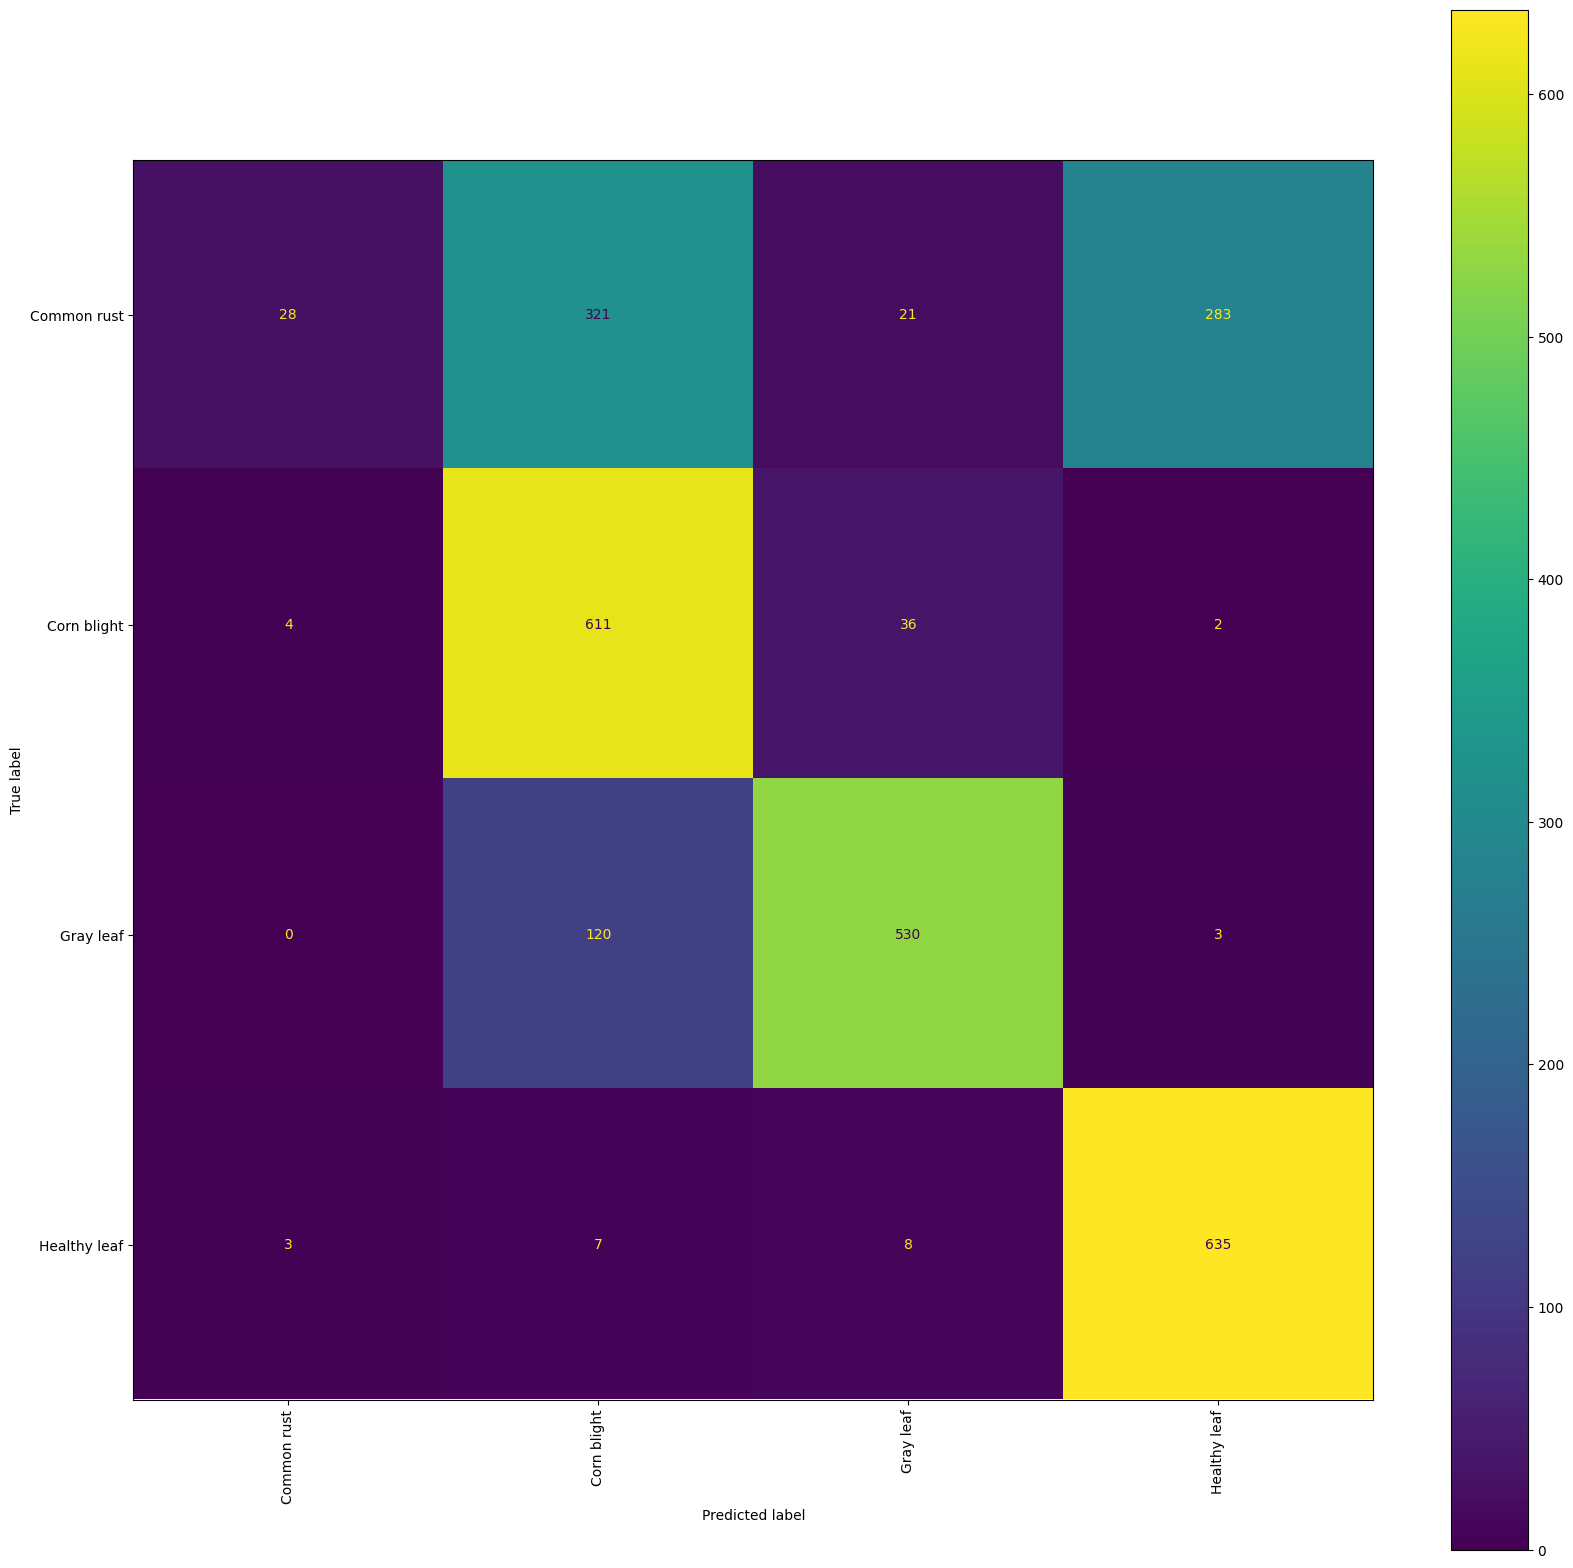

In [18]:
# model= keras.models.load_model(filepath= os.path.join(model_folder_path, "multi_classification_vgg19.h5"))
vizualize_model_performance(model)

In [32]:
model_history= pandas.DataFrame(model_history.history)
model_history.tail()           # Viewing last 5 rows

loss  accuracy  val_loss  val_accuracy
20  0.179319  0.928246  0.169659         0.928
21  0.180970  0.928596  0.165502         0.928
22  0.180764  0.925789  0.158849         0.938
23  0.163713  0.933860  0.154498         0.940
24  0.158209  0.938947  0.160476         0.936

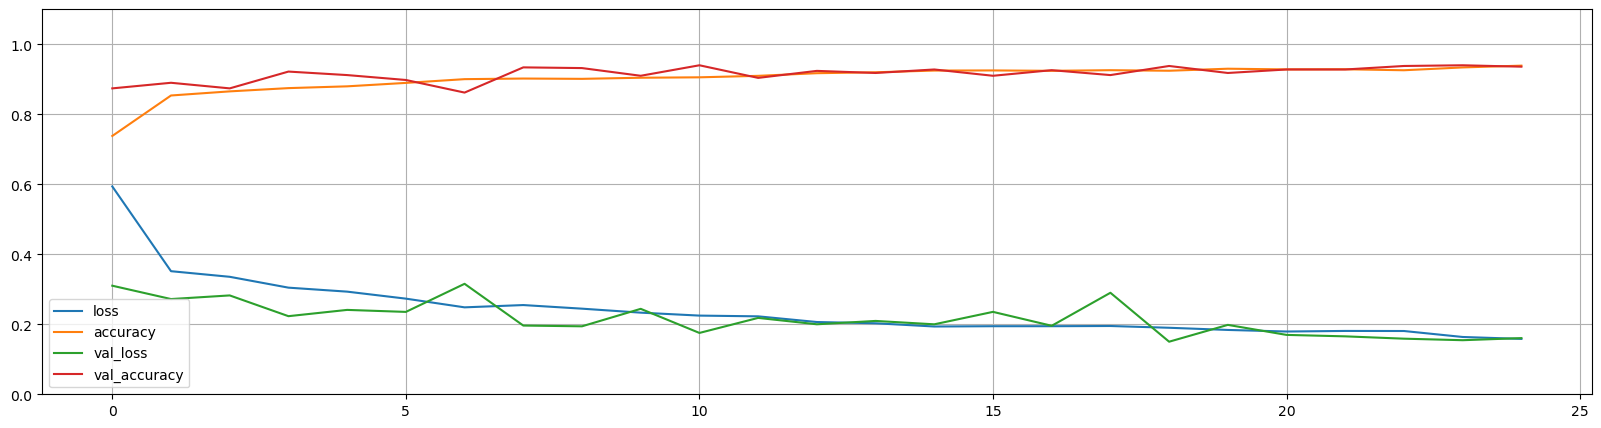

In [33]:
# Plotting model_history's loss and accuracy during each epoch
model_history.plot(figsize= (20, 5))
plt.grid(True)
# get current axes
plt.gca().set_ylim(0, 1.1)
plt.show()

In [34]:
# Testing model on test set
model.evaluate(test_generator, steps= (test_length// batch_size)) # test_steps= (200// 2= 100)

165/165 [==============================] - 47s 287ms/step - loss: 0.1349 - accuracy: 0.9455


[0.13494667410850525, 0.9454545378684998]

In [19]:
del model
keras.backend.clear_session()
gc.collect()

16715

In [36]:
# Using Transfer learning
conv_base= tensorflow.keras.applications.VGG16(weights= "imagenet", include_top= False, input_shape= (256, 256, 3))
conv_base.trainable= False # we do not want to train the weights again so we are freezing the conv layer.

In [37]:
# VGG16 model
model= keras.models.Sequential()
model.add(conv_base)
model.add(keras.layers.Conv2D(filters= 32, kernel_size= (3, 3), strides= 1, padding= 'valid', activation= 'relu',
                              input_shape= (256, 256, 3) ))
model.add(keras.layers.MaxPooling2D( (2, 2) ))
model.add(keras.layers.Flatten())  # We need single one dimensional array as input
model.add(keras.layers.Dropout(0.5)) # It will randomly pick 50 % of neurons and deactivate them during each epoch and model will be trained with the
# remaining neurons. Dropout is a very effective layer to avoid overfitting in model
model.add(keras.layers.Dense(256, activation= 'relu'))
model.add(keras.layers.Dense(200, activation= 'relu'))
model.add(keras.layers.Dense(4, activation= 'softmax'))    # For binary classes classification

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 conv2d (Conv2D)             (None, 6, 6, 32)          147488    
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 3, 32)          0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 288)               0         
                                                                 
 dropout (Dropout)           (None, 288)               0         
                                                                 
 dense (Dense)               (None, 256)               73984     
                                                        

In [39]:
# Compiling and model training
t3= time.time()
model.compile(loss= "categorical_crossentropy", optimizer= keras.optimizers.Adam(learning_rate= 1e-4), metrics= ['accuracy'])
model_history= model.fit(train_generator, steps_per_epoch= (train_length// batch_size), epochs= 25, validation_data= validation_generator, validation_steps=
                         (validation_length// batch_size))
t4= time.time()

Epoch 1/25
2850/2850 [==============================] - 784s 275ms/step - loss: 0.5921 - accuracy: 0.7319 - val_loss: 0.3273 - val_accuracy: 0.8460
Epoch 2/25
2850/2850 [==============================] - 711s 249ms/step - loss: 0.3496 - accuracy: 0.8509 - val_loss: 0.2550 - val_accuracy: 0.8840
Epoch 3/25
2850/2850 [==============================] - 720s 253ms/step - loss: 0.3011 - accuracy: 0.8675 - val_loss: 0.2418 - val_accuracy: 0.8920
Epoch 4/25
2850/2850 [==============================] - 719s 252ms/step - loss: 0.2585 - accuracy: 0.8902 - val_loss: 0.2017 - val_accuracy: 0.9180
Epoch 5/25
2850/2850 [==============================] - 723s 254ms/step - loss: 0.2465 - accuracy: 0.8968 - val_loss: 0.1917 - val_accuracy: 0.9220
Epoch 6/25
2850/2850 [==============================] - 723s 254ms/step - loss: 0.2251 - accuracy: 0.9081 - val_loss: 0.1917 - val_accuracy: 0.9340
Epoch 7/25
2850/2850 [==============================] - 722s 254ms/step - loss: 0.2121 - accuracy: 0.9112 - val_

In [40]:
print('Training time is :', round((t4- t3)/ 60 , 3), 'minutes.')   # For VGG16 model

Training time is : 301.043 minutes.


In [41]:
# Saving - Restoring Models
model_folder_path= os.path.join(os.getcwd(), "Saved models")
model.save(os.path.join(model_folder_path, "multi_classification_vgg16.h5"))

1/1 [==============================] - 1s 900ms/step
Prediction is : Corn blight
1/1 [==============================] - 0s 464ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 454ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 480ms/step
Prediction is : Corn blight
1/1 [==============================] - 0s 461ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 473ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 466ms/step
Prediction is : Common rust
1/1 [==============================] - 1s 504ms/step
Prediction is : Corn blight
1/1 [==============================] - 0s 471ms/step
Prediction is : Corn blight
1/1 [==============================] - 0s 486ms/step
Prediction is : Corn blight
1/1 [==============================] - 0s 454ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 486ms/step
Prediction is : Common rust
1/1 [=======================

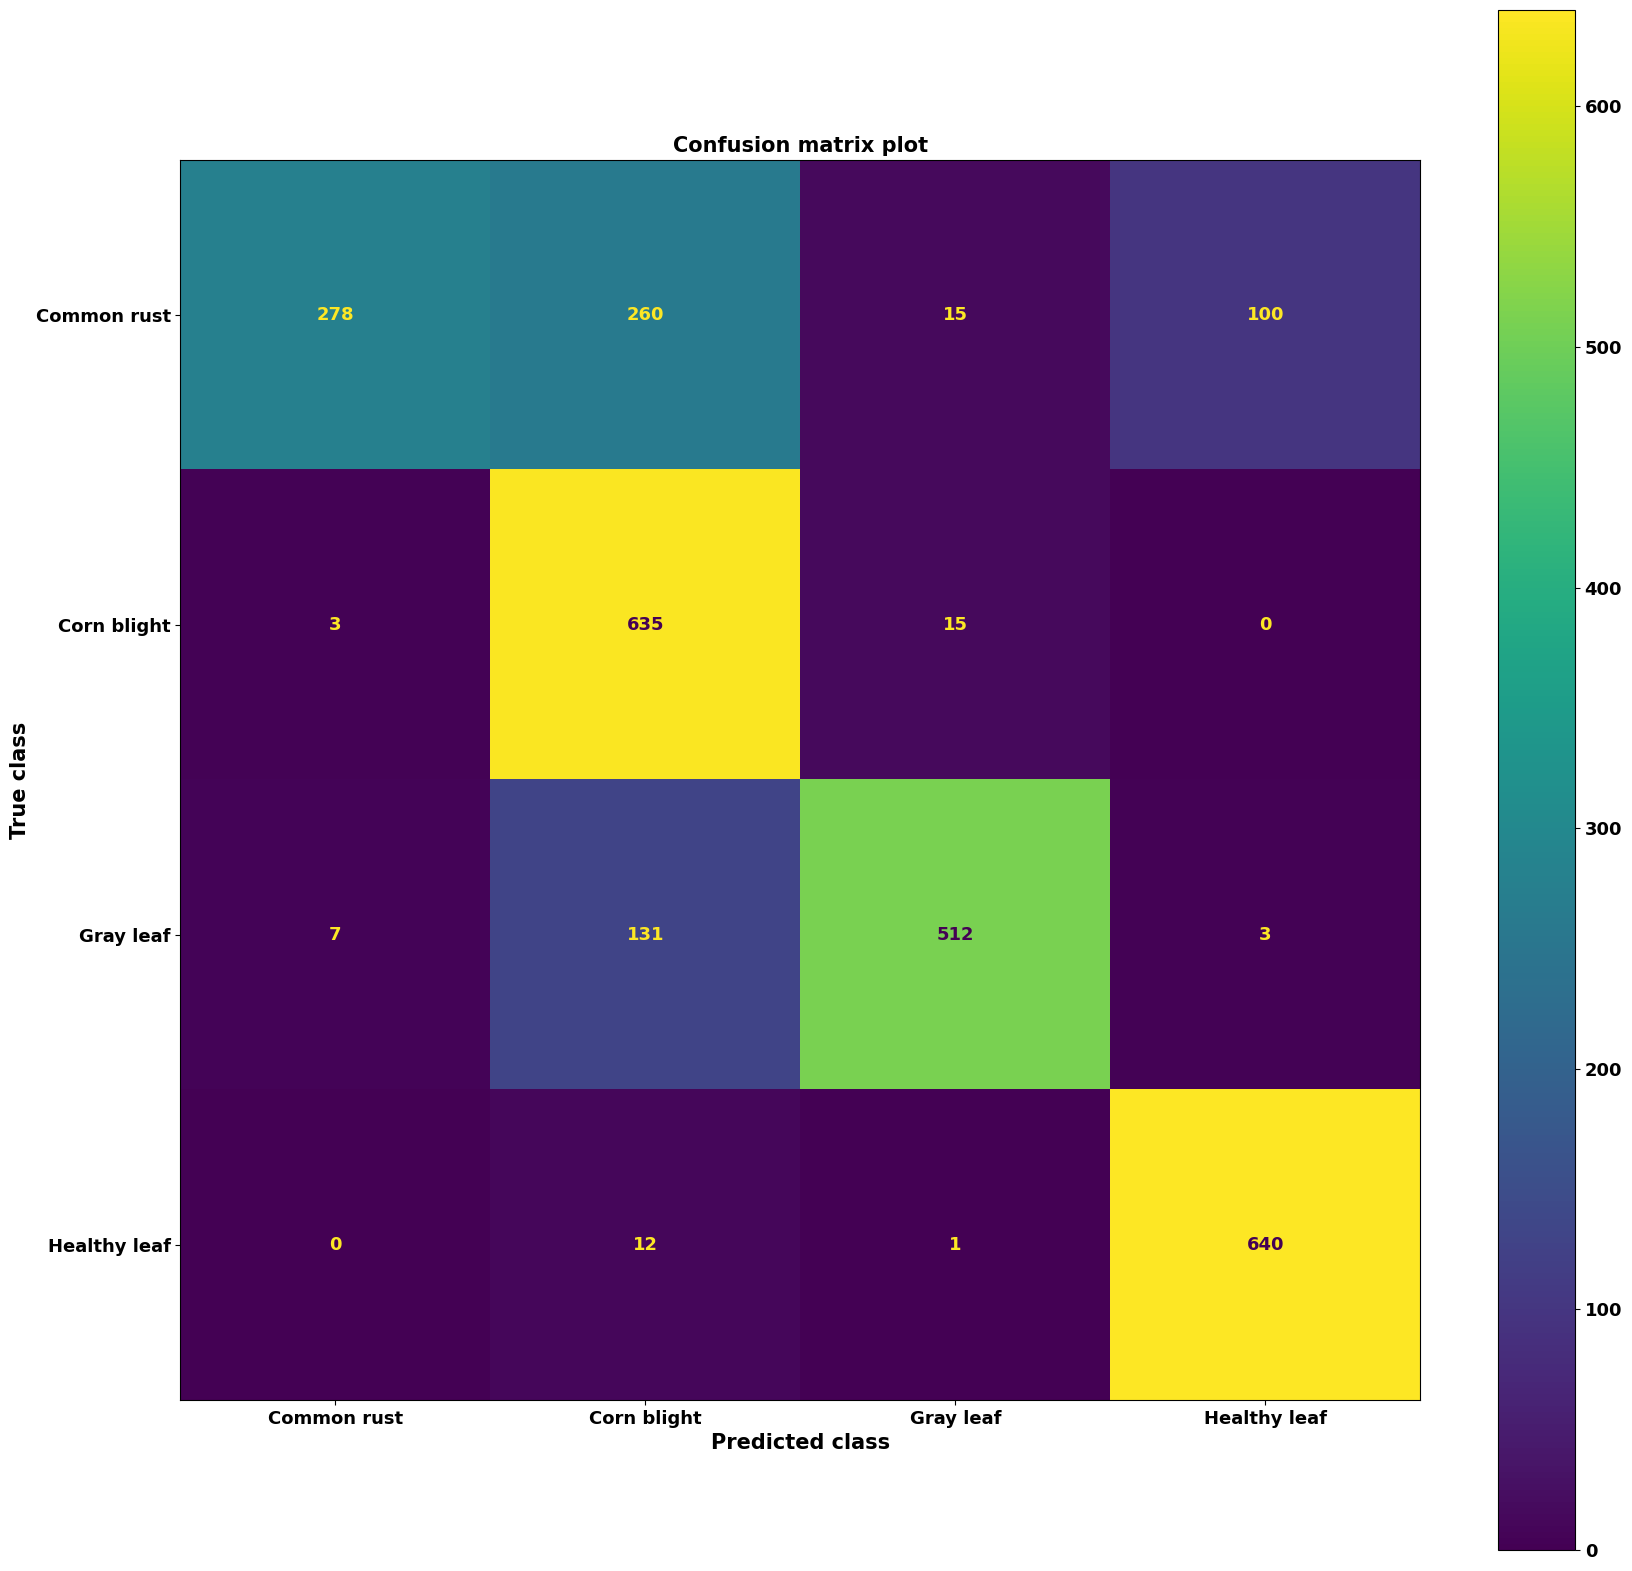

In [55]:
# model= keras.models.load_model(filepath= os.path.join(model_folder_path, "multi_classification_vgg16.h5"))
vizualize_model_performance(model)

In [42]:
model_history= pandas.DataFrame(model_history.history)
model_history.tail()           # Viewing last 5 rows

loss  accuracy  val_loss  val_accuracy
20  0.135155  0.948421  0.101261         0.954
21  0.142232  0.945263  0.124948         0.942
22  0.143687  0.946491  0.113119         0.948
23  0.126832  0.950877  0.113715         0.948
24  0.119772  0.955088  0.104698         0.960

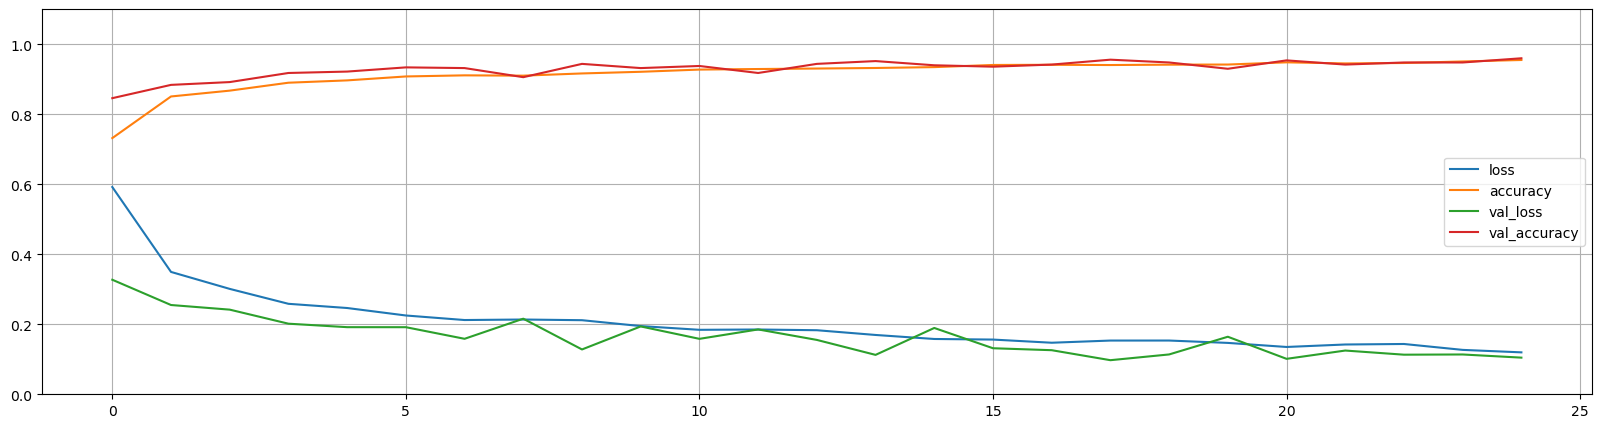

In [43]:
# Plotting model_history's loss and accuracy during each epoch
model_history.plot(figsize= (20, 5))
plt.grid(True)
# get current axes
plt.gca().set_ylim(0, 1.1)
plt.show()

In [44]:
# Testing model on test set
model.evaluate(test_generator, steps= (test_length// batch_size)) # test_steps= (200// 2= 100)

165/165 [==============================] - 38s 230ms/step - loss: 0.1138 - accuracy: 0.9485


[0.11376422643661499, 0.9484848380088806]

In [57]:
del model
keras.backend.clear_session()
gc.collect()

98

In [46]:
# Using Transfer learning
conv_base= tensorflow.keras.applications.inception_v3.InceptionV3(weights= "imagenet", include_top= False, input_shape= (256, 256, 3))
conv_base.trainable= False # we do not want to train the weights again so we are freezing the conv layer.

In [47]:
# InceptionV3 model
model= keras.models.Sequential()
model.add(conv_base)
model.add(keras.layers.Conv2D(filters= 32, kernel_size= (3, 3), strides= 1, padding= 'valid', activation= 'relu',
                              input_shape= (256, 256, 3) ))
model.add(keras.layers.MaxPooling2D( (2, 2) ))
model.add(keras.layers.Flatten())  # We need single one dimensional array as input
model.add(keras.layers.Dropout(0.5)) # It will randomly pick 50 % of neurons and deactivate them during each epoch and model will be trained with the
# remaining neurons. Dropout is a very effective layer to avoid overfitting in model
model.add(keras.layers.Dense(256, activation= 'relu'))
model.add(keras.layers.Dense(200, activation= 'relu'))
model.add(keras.layers.Dense(4, activation= 'softmax'))    # For binary classes classification

In [48]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 conv2d_94 (Conv2D)          (None, 4, 4, 32)          589856    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 2, 2, 32)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 256)               33024     
                                                        

In [49]:
# Compiling and model training
t3= time.time()
model.compile(loss= "categorical_crossentropy", optimizer= keras.optimizers.Adam(learning_rate= 1e-4), metrics= ['accuracy'])
model_history= model.fit(train_generator, steps_per_epoch= (train_length// batch_size), epochs= 25, validation_data= validation_generator, validation_steps=
                         (validation_length// batch_size))
t4= time.time()

Epoch 1/25
2850/2850 [==============================] - 204s 71ms/step - loss: 0.5216 - accuracy: 0.7712 - val_loss: 0.3493 - val_accuracy: 0.8060
Epoch 2/25
2850/2850 [==============================] - 203s 71ms/step - loss: 0.3270 - accuracy: 0.8642 - val_loss: 0.2966 - val_accuracy: 0.8760
Epoch 3/25
2850/2850 [==============================] - 203s 71ms/step - loss: 0.2922 - accuracy: 0.8774 - val_loss: 0.2385 - val_accuracy: 0.9020
Epoch 4/25
2850/2850 [==============================] - 202s 71ms/step - loss: 0.2681 - accuracy: 0.8933 - val_loss: 0.3243 - val_accuracy: 0.8480
Epoch 5/25
2850/2850 [==============================] - 202s 71ms/step - loss: 0.2422 - accuracy: 0.9051 - val_loss: 0.2805 - val_accuracy: 0.8820
Epoch 6/25
2850/2850 [==============================] - 202s 71ms/step - loss: 0.2238 - accuracy: 0.9098 - val_loss: 0.2236 - val_accuracy: 0.9040
Epoch 7/25
2850/2850 [==============================] - 203s 71ms/step - loss: 0.2073 - accuracy: 0.9163 - val_loss: 0

In [50]:
print('Training time is :', round((t4- t3)/ 60 , 3), 'minutes.')   # For InceptionV3 model

Training time is : 84.422 minutes.


In [51]:
# Saving - Restoring Models
model_folder_path= os.path.join(os.getcwd(), "Saved models")
model.save(os.path.join(model_folder_path, "multi_classification_InceptionV3.h5"))

1/1 [==============================] - 3s 3s/step
Prediction is : Common rust
1/1 [==============================] - 0s 214ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 200ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 219ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 203ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 225ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 226ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 241ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 227ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 230ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 208ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 214ms/step
Prediction is : Common rust
1/1 [==========================

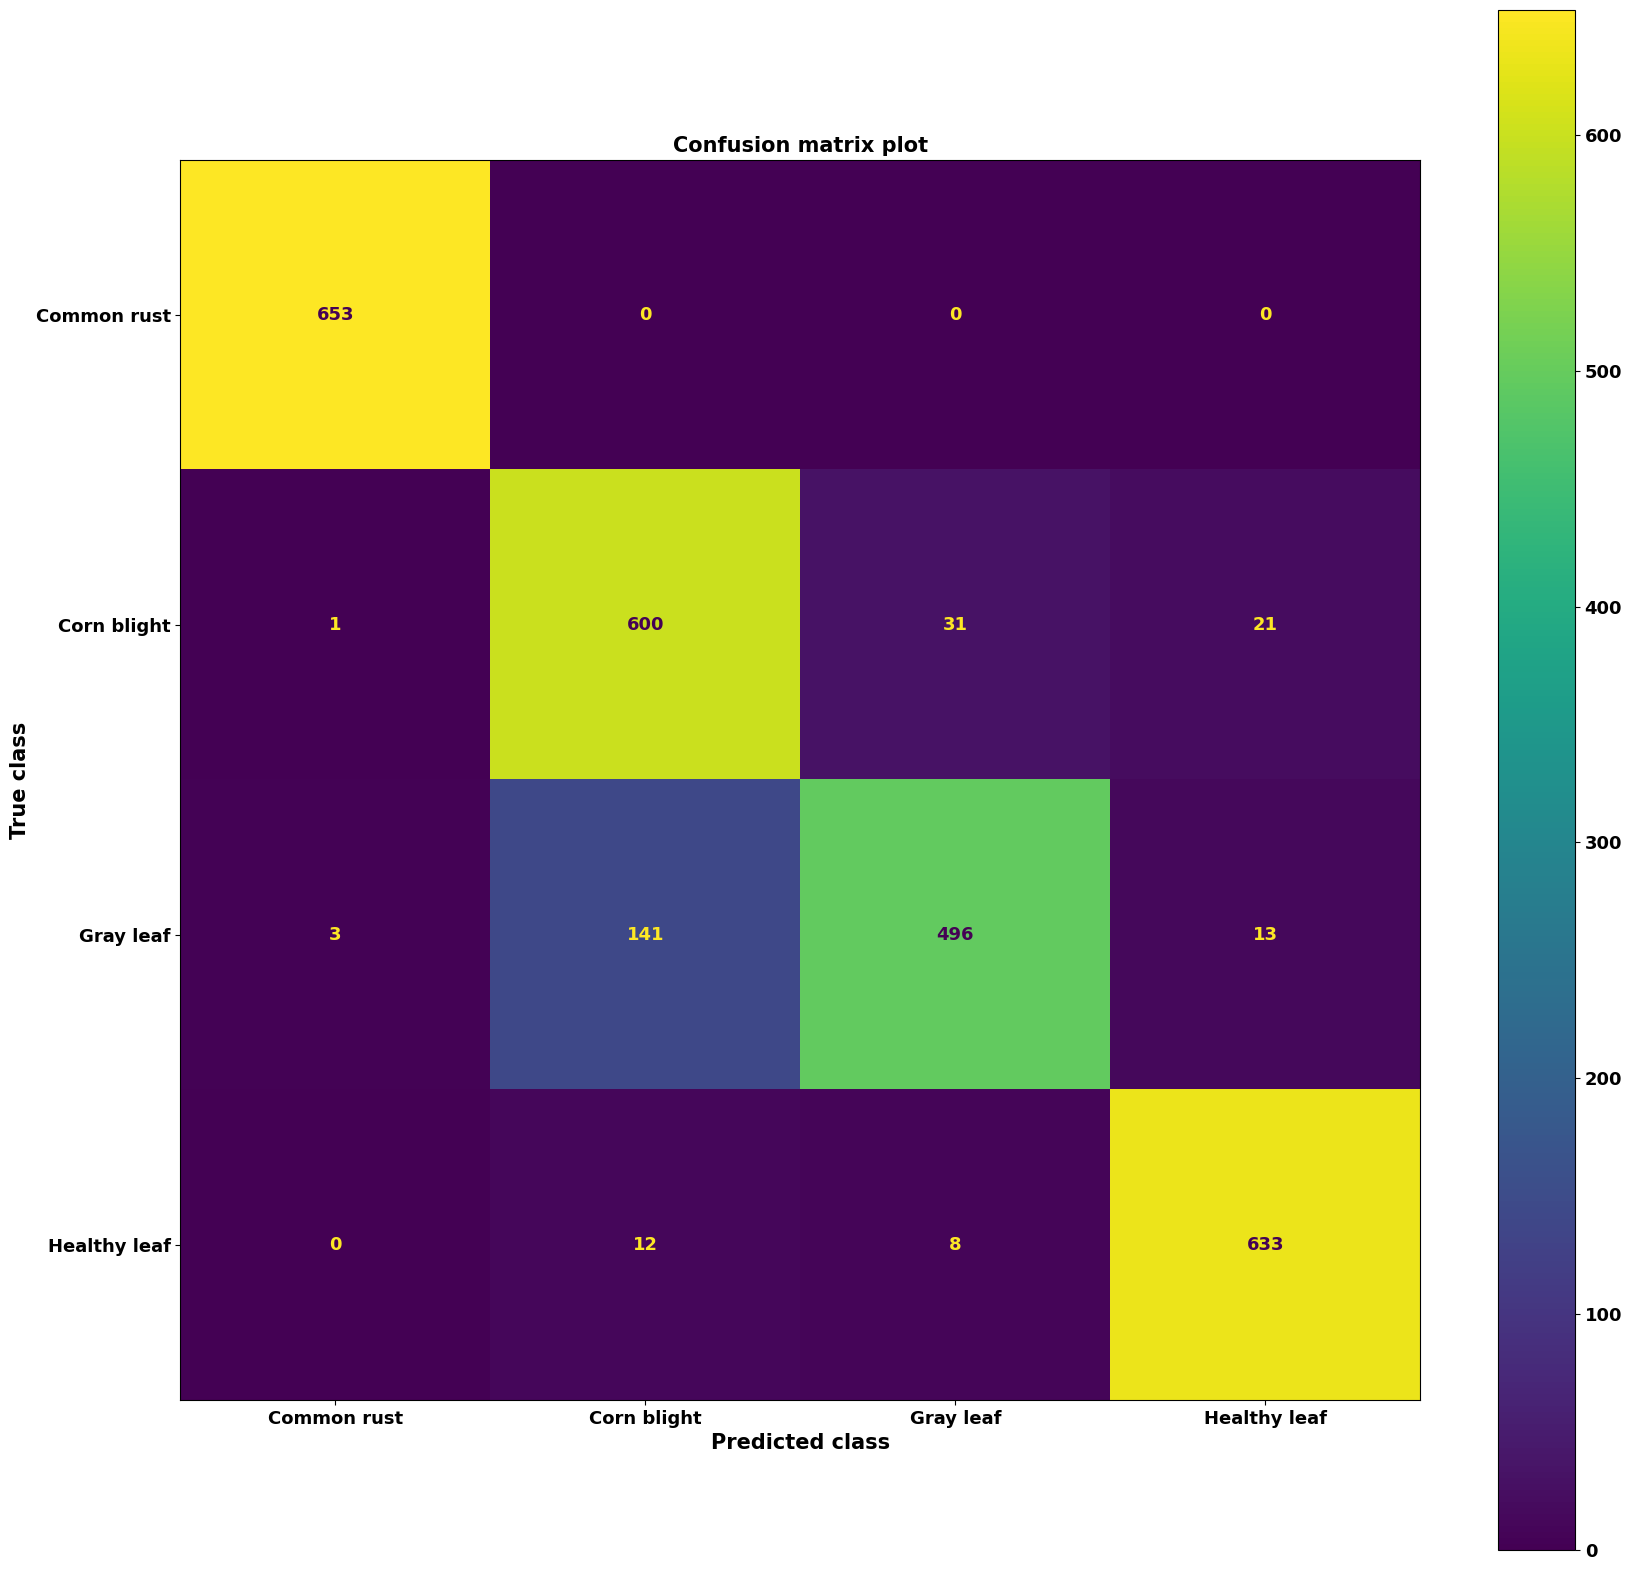

In [58]:
# model= keras.models.load_model(filepath= os.path.join(model_folder_path, "multi_classification_InceptionV3.h5"))
vizualize_model_performance(model)

In [52]:
# Testing model on test set
model.evaluate(test_generator, steps= (test_length// batch_size)) # test_steps= (200// 2= 100)

165/165 [==============================] - 10s 63ms/step - loss: 0.1024 - accuracy: 0.9697


[0.10241208225488663, 0.9696969985961914]

In [59]:
del model
keras.backend.clear_session()
gc.collect()

90290

In [26]:
# Using Transfer learning
conv_base= tensorflow.keras.applications.ResNet50(weights= "imagenet", include_top= False, input_shape= (256, 256, 3))
conv_base.trainable= False # we do not want to train the weights again so we are freezing the conv layer.

# ResNet50 model
model= keras.models.Sequential()
model.add(conv_base)
model.add(keras.layers.Conv2D(filters= 32, kernel_size= (3, 3), strides= 1, padding= 'valid', activation= 'relu',
                              input_shape= (256, 256, 3) ))
model.add(keras.layers.MaxPooling2D( (2, 2) ))
model.add(keras.layers.Flatten())  # We need single one dimensional array as input
model.add(keras.layers.Dropout(0.5)) # It will randomly pick 50 % of neurons and deactivate them during each epoch and model will be trained with the
# remaining neurons. Dropout is a very effective layer to avoid overfitting in model
model.add(keras.layers.Dense(256, activation= 'relu'))
model.add(keras.layers.Dense(200, activation= 'relu'))
model.add(keras.layers.Dense(4, activation= 'softmax'))    # For binary classes classification

94765736/94765736 [==============================] - 10s 0us/step


In [27]:
# Compiling and model training
t3= time.time()
model.compile(loss= "categorical_crossentropy", optimizer= keras.optimizers.Adam(learning_rate= 1e-4), metrics= ['accuracy'])
model_history= model.fit(train_generator, steps_per_epoch= (train_length// batch_size), epochs= 25, validation_data= validation_generator, validation_steps=
                         (validation_length// batch_size))
t4= time.time()

Epoch 1/25
2850/2850 [==============================] - 1335s 464ms/step - loss: 1.3940 - accuracy: 0.2653 - val_loss: 1.3090 - val_accuracy: 0.3800
Epoch 2/25
2850/2850 [==============================] - 1277s 448ms/step - loss: 1.3401 - accuracy: 0.3388 - val_loss: 1.2046 - val_accuracy: 0.4440
Epoch 3/25
2850/2850 [==============================] - 1190s 418ms/step - loss: 1.3303 - accuracy: 0.3418 - val_loss: 1.2093 - val_accuracy: 0.4200
Epoch 4/25
2850/2850 [==============================] - 1182s 415ms/step - loss: 1.3251 - accuracy: 0.3563 - val_loss: 1.1399 - val_accuracy: 0.5280
Epoch 5/25
2850/2850 [==============================] - 1273s 447ms/step - loss: 1.3165 - accuracy: 0.3705 - val_loss: 1.2565 - val_accuracy: 0.5300
Epoch 6/25
2850/2850 [==============================] - 1260s 442ms/step - loss: 1.3362 - accuracy: 0.3684 - val_loss: 1.2146 - val_accuracy: 0.4860
Epoch 7/25
2850/2850 [==============================] - 1170s 411ms/step - loss: 1.3150 - accuracy: 0.3740

In [28]:
print('Training time is :', round((t4- t3)/ 60 , 3), 'minutes.')   # For ResNet50 model

Training time is : 535.771 minutes.


In [29]:
# Saving - Restoring Models
model_folder_path= os.path.join(os.getcwd(), "Saved models")
model.save(os.path.join(model_folder_path, "multi_classification_ResNet50.h5"))

# Testing model on test set
model.evaluate(test_generator, steps= (test_length// batch_size)) # test_steps= (200// 2= 100)

165/165 [==============================] - 72s 435ms/step - loss: 1.3924 - accuracy: 0.3818


[1.3923680782318115, 0.38181817531585693]

1/1 [==============================] - 2s 2s/step
Prediction is : Common rust
1/1 [==============================] - 0s 301ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 298ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 278ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 295ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 283ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 273ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 275ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 294ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 277ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 291ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 285ms/step
Prediction is : Common rust
1/1 [==========================

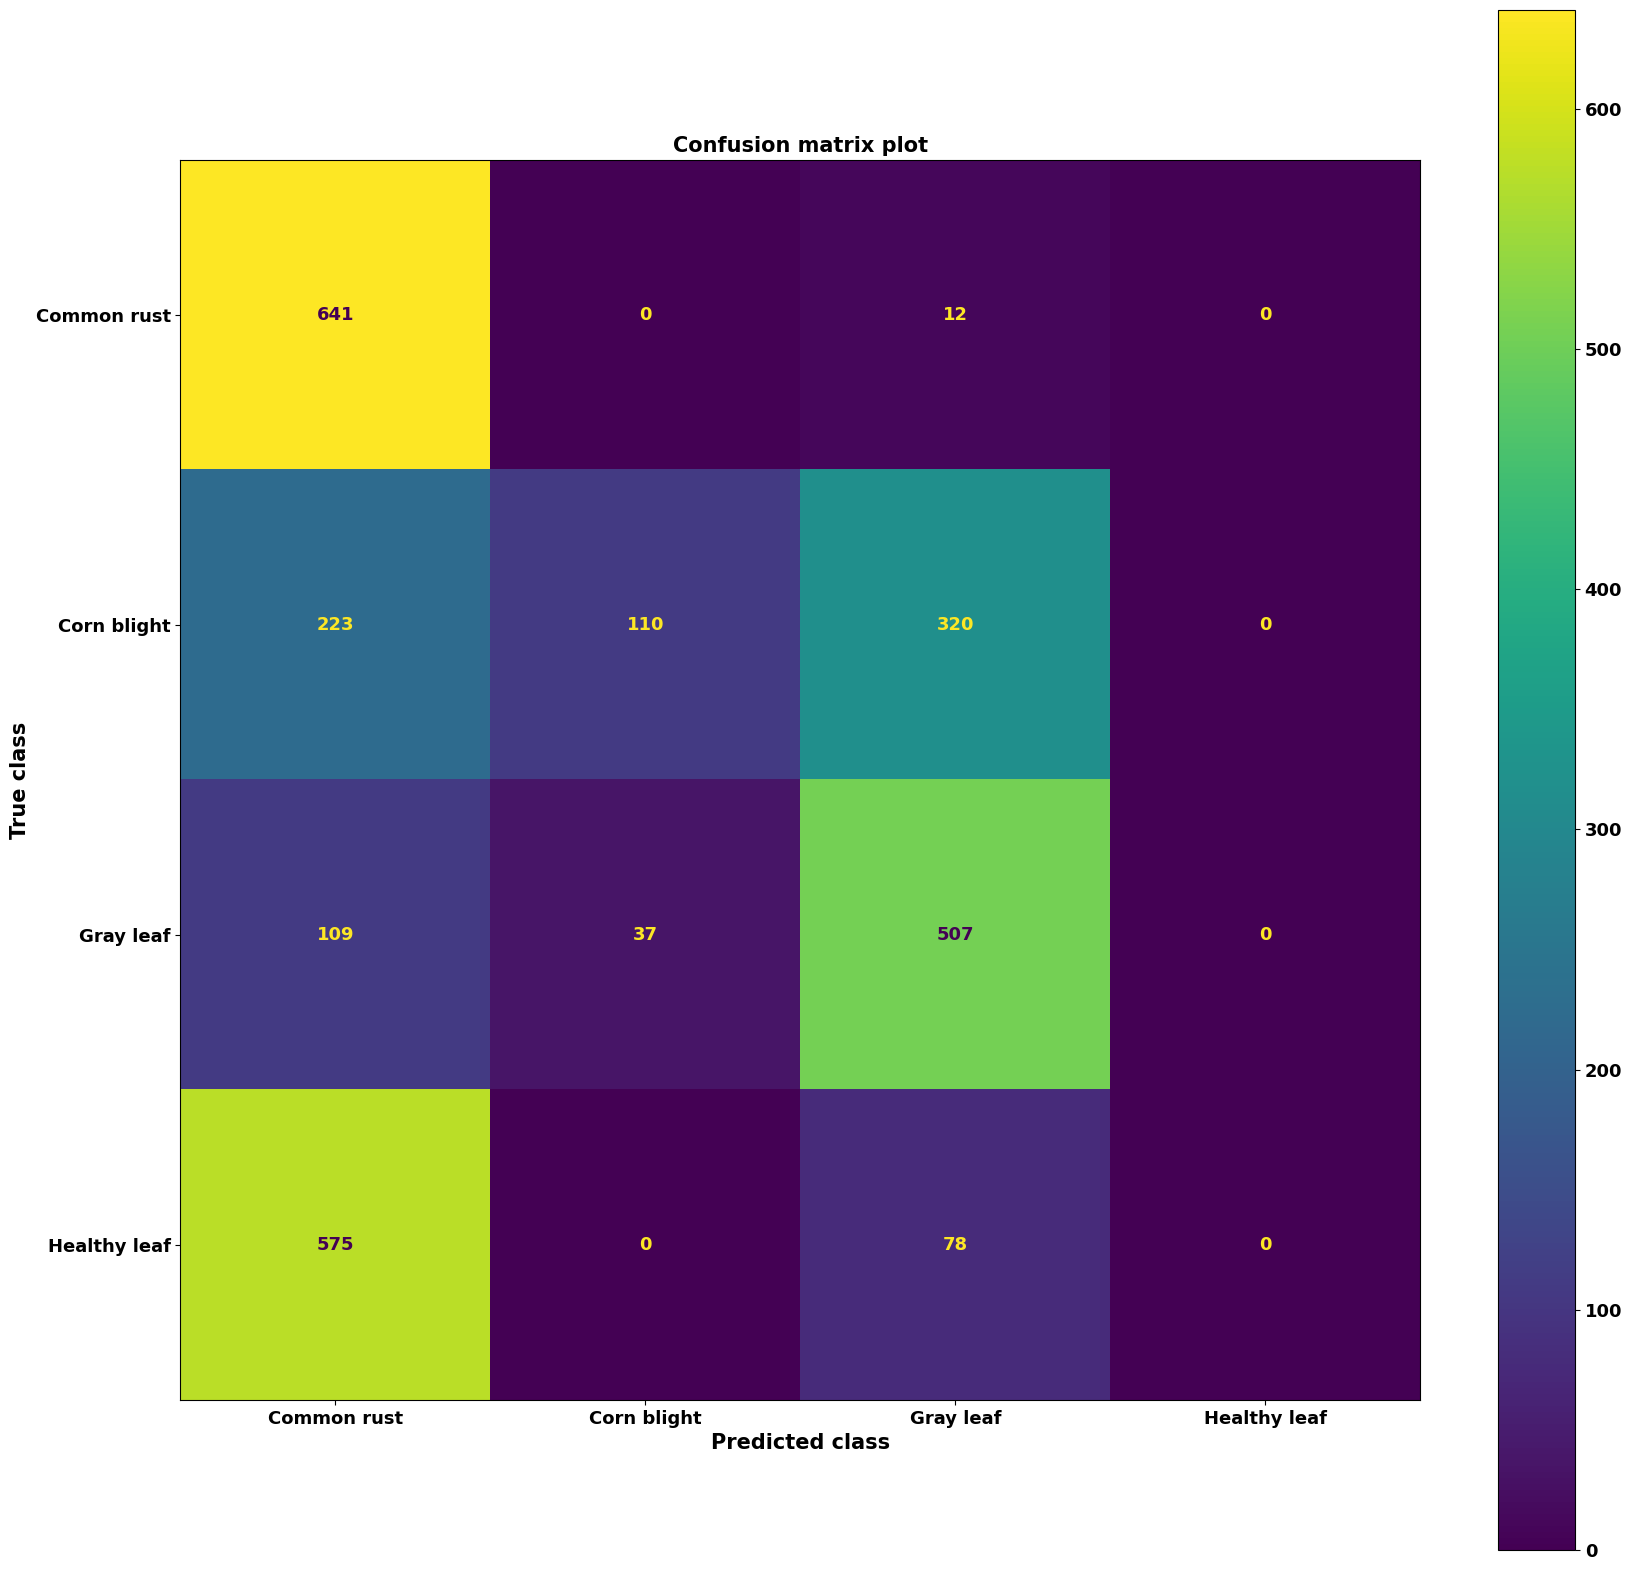

In [60]:
# model= keras.models.load_model(filepath= os.path.join(model_folder_path, "multi_classification_ResNet50.h5"))
vizualize_model_performance(model)

In [61]:
del model
keras.backend.clear_session()
gc.collect()

71906

In [16]:
# Using Transfer learning
conv_base= tensorflow.keras.applications.ResNet152(weights= "imagenet", include_top= False, input_shape= (256, 256, 3))
conv_base.trainable= False # we do not want to train the weights again so we are freezing the conv layer.

# ResNet152 model
model= keras.models.Sequential()
model.add(conv_base)
model.add(keras.layers.Conv2D(filters= 32, kernel_size= (3, 3), strides= 1, padding= 'valid', activation= 'relu',
                              input_shape= (256, 256, 3) ))
model.add(keras.layers.MaxPooling2D( (2, 2) ))
model.add(keras.layers.Flatten())  # We need single one dimensional array as input
model.add(keras.layers.Dropout(0.5)) # It will randomly pick 50 % of neurons and deactivate them during each epoch and model will be trained with the
# remaining neurons. Dropout is a very effective layer to avoid overfitting in model
model.add(keras.layers.Dense(256, activation= 'relu'))
model.add(keras.layers.Dense(200, activation= 'relu'))
model.add(keras.layers.Dense(4, activation= 'softmax'))    # For binary classes classification



234698864/234698864 [==============================] - 16s 0us/step


In [17]:
# Compiling and model training
t3= time.time()
model.compile(loss= "categorical_crossentropy", optimizer= keras.optimizers.Adam(learning_rate= 1e-4), metrics= ['accuracy'])
model_history= model.fit(train_generator, steps_per_epoch= (train_length// batch_size), epochs= 25, validation_data= validation_generator, validation_steps=
                         (validation_length// batch_size))
t4= time.time()

Epoch 1/25


2850/2850 [==============================] - 674s 234ms/step - loss: 1.3891 - accuracy: 0.2589 - val_loss: 1.2922 - val_accuracy: 0.4100
Epoch 2/25
2850/2850 [==============================] - 689s 242ms/step - loss: 1.3636 - accuracy: 0.2953 - val_loss: 1.2368 - val_accuracy: 0.4560
Epoch 3/25
2850/2850 [==============================] - 762s 267ms/step - loss: 1.3544 - accuracy: 0.3216 - val_loss: 1.2504 - val_accuracy: 0.3940
Epoch 4/25
2850/2850 [==============================] - 762s 267ms/step - loss: 1.3575 - accuracy: 0.3242 - val_loss: 1.2200 - val_accuracy: 0.4180
Epoch 5/25
2850/2850 [==============================] - 766s 269ms/step - loss: 1.3550 - accuracy: 0.3240 - val_loss: 1.2080 - val_accuracy: 0.4400
Epoch 6/25
2850/2850 [==============================] - 762s 267ms/step - loss: 1.3542 - accuracy: 0.3323 - val_loss: 1.1603 - val_accuracy: 0.4760
Epoch 7/25
2850/2850 [==============================] - 761s 267ms/step - loss: 1.3477 - accuracy: 0.3537 - va

In [18]:
print('Training time is :', round((t4- t3)/ 60 , 3), 'minutes.')   # For ResNet152 model

Training time is : 315.566 minutes.


In [19]:
# Saving - Restoring Models
model_folder_path= os.path.join(os.getcwd(), "Saved models")
model.save(os.path.join(model_folder_path, "multi_classification_ResNet152.h5"))

# Testing model on test set
model.evaluate(test_generator, steps= (test_length// batch_size)) # test_steps= (200// 2= 100)

165/165 [==============================] - 40s 242ms/step - loss: 1.3439 - accuracy: 0.3848


[1.343915581703186, 0.3848484754562378]

1/1 [==============================] - 6s 6s/step
Prediction is : Healthy leaf
1/1 [==============================] - 1s 805ms/step
Prediction is : Healthy leaf
1/1 [==============================] - 1s 803ms/step
Prediction is : Common rust
1/1 [==============================] - 1s 819ms/step
Prediction is : Common rust
1/1 [==============================] - 1s 801ms/step
Prediction is : Healthy leaf
1/1 [==============================] - 1s 795ms/step
Prediction is : Gray leaf
1/1 [==============================] - 1s 816ms/step
Prediction is : Healthy leaf
1/1 [==============================] - 1s 796ms/step
Prediction is : Common rust
1/1 [==============================] - 1s 800ms/step
Prediction is : Healthy leaf
1/1 [==============================] - 1s 805ms/step
Prediction is : Healthy leaf
1/1 [==============================] - 1s 800ms/step
Prediction is : Common rust
1/1 [==============================] - 1s 789ms/step
Prediction is : Common rust
1/1 [======================

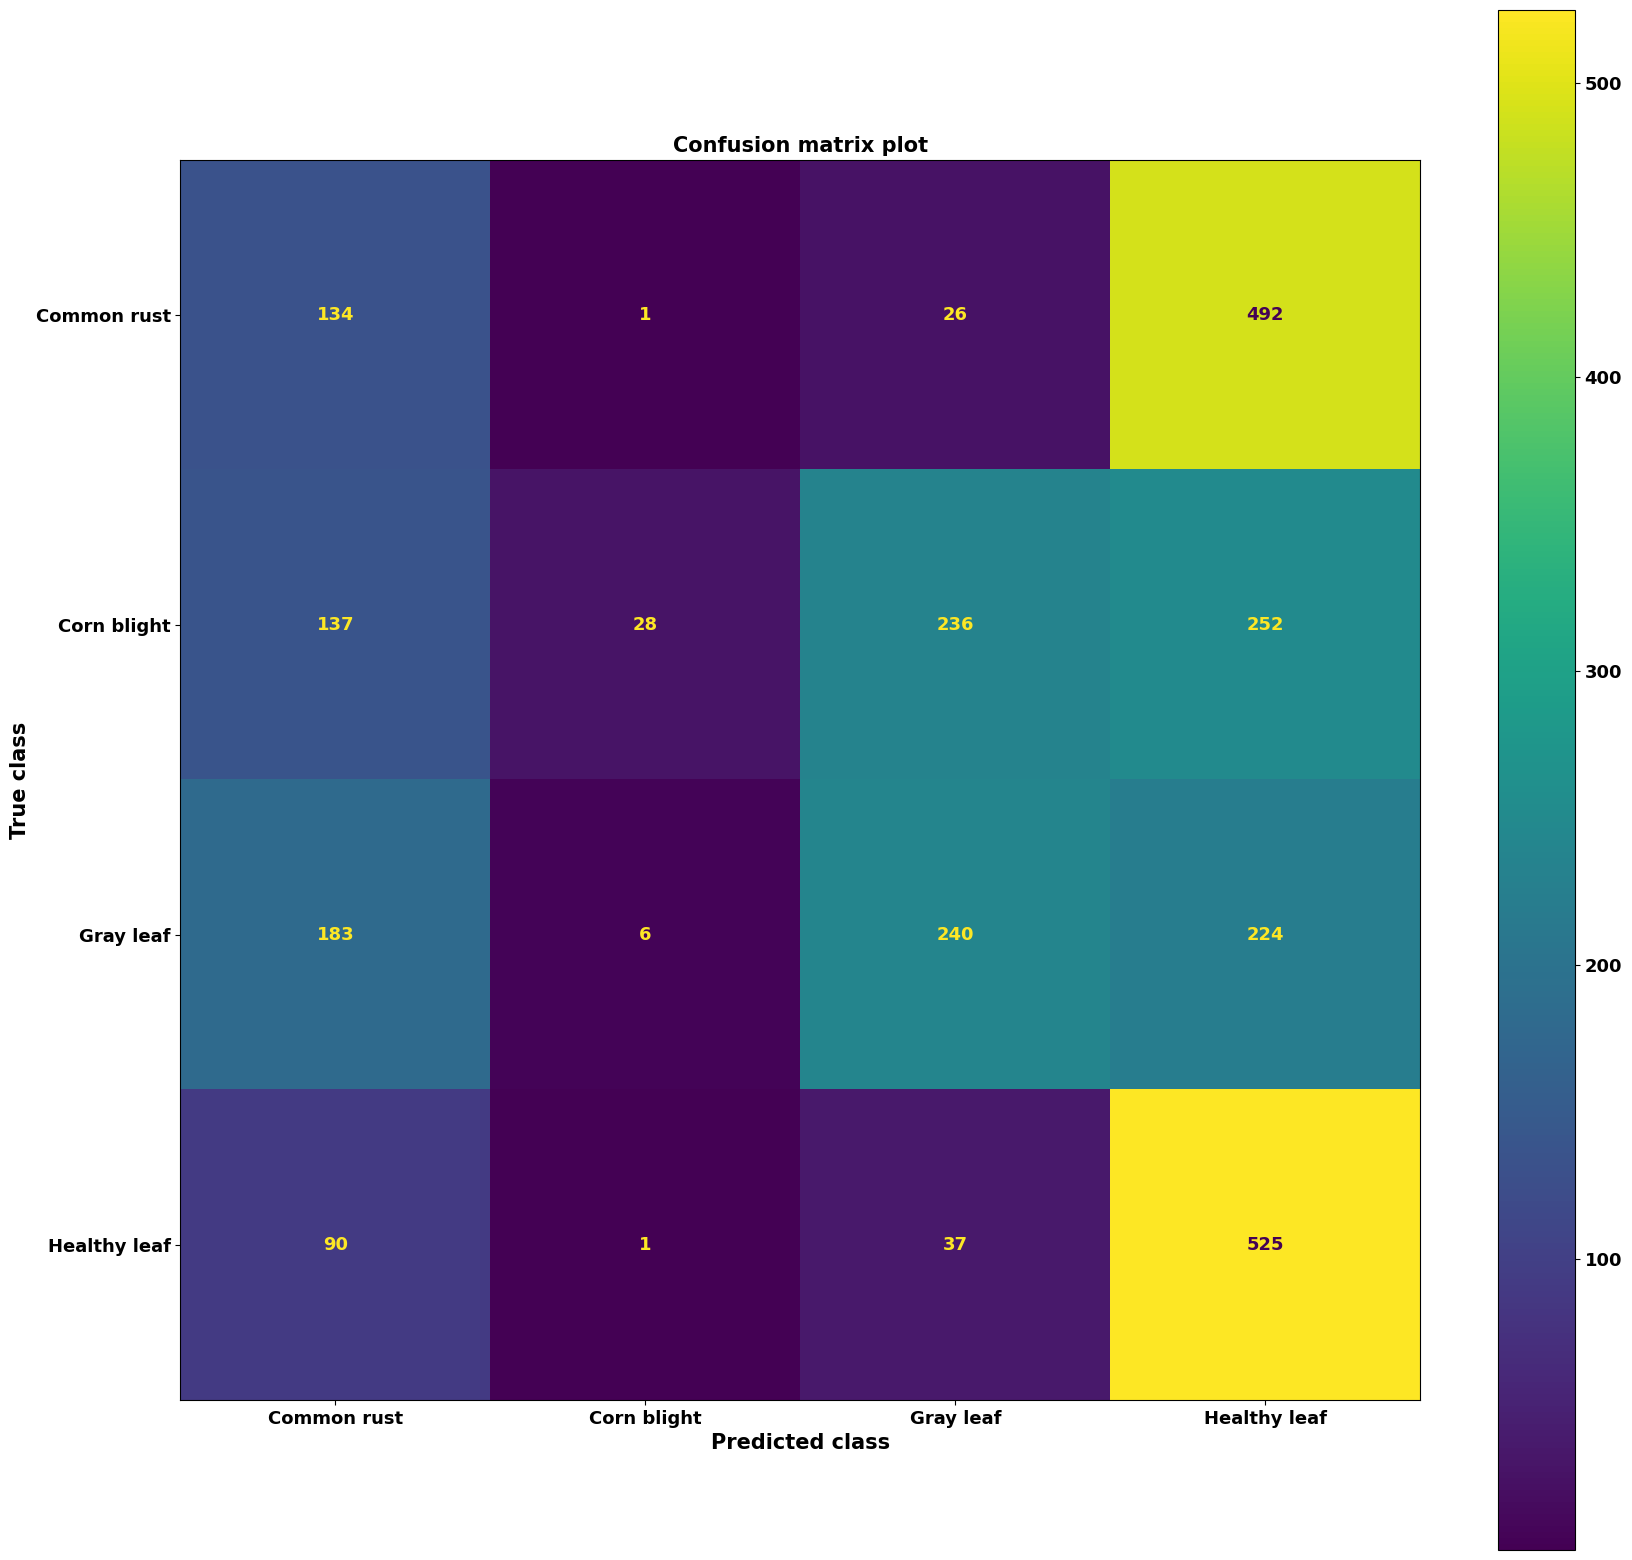

In [62]:
# model= keras.models.load_model(filepath= os.path.join(model_folder_path, "multi_classification_ResNet152.h5"))
vizualize_model_performance(model)

In [63]:
del model
keras.backend.clear_session()
gc.collect()

134018

In [54]:
# Using Transfer learning
conv_base= efficientnet.keras.EfficientNetB0(weights= "imagenet", include_top= False, input_shape= (256, 256, 3))
conv_base.trainable= False # we do not want to train the weights again so we are freezing the conv layer.

# EfficientNetB0 model
model= keras.models.Sequential()
model.add(conv_base)
model.add(keras.layers.Conv2D(filters= 32, kernel_size= (3, 3), strides= 1, padding= 'valid', activation= 'relu',
                              input_shape= (256, 256, 3) ))
model.add(keras.layers.MaxPooling2D( (2, 2) ))
model.add(keras.layers.Flatten())  # We need single one dimensional array as input
model.add(keras.layers.Dropout(0.5)) # It will randomly pick 50 % of neurons and deactivate them during each epoch and model will be trained with the
# remaining neurons. Dropout is a very effective layer to avoid overfitting in model
model.add(keras.layers.Dense(256, activation= 'relu'))
model.add(keras.layers.Dense(200, activation= 'relu'))
model.add(keras.layers.Dense(4, activation= 'softmax'))    # For binary classes classification

In [55]:
# Compiling and model training
t3= time.time()
model.compile(loss= "categorical_crossentropy", optimizer= keras.optimizers.Adam(learning_rate= 1e-4), metrics= ['accuracy'])
model_history= model.fit(train_generator, steps_per_epoch= (train_length// batch_size), epochs= 25, validation_data= validation_generator, validation_steps=
                         (validation_length// batch_size))
t4= time.time()

Epoch 1/25
2850/2850 [==============================] - 104s 35ms/step - loss: 0.4025 - accuracy: 0.8300 - val_loss: 0.1815 - val_accuracy: 0.9260
Epoch 2/25
2850/2850 [==============================] - 100s 35ms/step - loss: 0.2047 - accuracy: 0.9151 - val_loss: 0.1597 - val_accuracy: 0.9300
Epoch 3/25
2850/2850 [==============================] - 101s 35ms/step - loss: 0.1953 - accuracy: 0.9253 - val_loss: 0.1436 - val_accuracy: 0.9460
Epoch 4/25
2850/2850 [==============================] - 100s 35ms/step - loss: 0.1601 - accuracy: 0.9335 - val_loss: 0.1004 - val_accuracy: 0.9620
Epoch 5/25
2850/2850 [==============================] - 101s 35ms/step - loss: 0.1533 - accuracy: 0.9435 - val_loss: 0.1073 - val_accuracy: 0.9580
Epoch 6/25
2850/2850 [==============================] - 101s 35ms/step - loss: 0.1406 - accuracy: 0.9460 - val_loss: 0.0802 - val_accuracy: 0.9720
Epoch 7/25
2850/2850 [==============================] - 101s 36ms/step - loss: 0.1229 - accuracy: 0.9507 - val_loss: 0

In [56]:
print('Training time is :', round((t4- t3)/ 60 , 3), 'minutes.')   # For EfficientNetB0 model

Training time is : 41.981 minutes.


In [57]:
# Saving - Restoring Models
model_folder_path= os.path.join(os.getcwd(), "Saved models")
model.save(os.path.join(model_folder_path, "multi_classification_EfficientNetB0.h5"))

# Testing model on test set
model.evaluate(test_generator, steps= (test_length// batch_size)) # test_steps= (200// 2= 100)

165/165 [==============================] - 5s 31ms/step - loss: 0.0494 - accuracy: 0.9818


[0.0494183748960495, 0.9818181991577148]

1/1 [==============================] - 2s 2s/step
Prediction is : Corn blight
1/1 [==============================] - 0s 100ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 101ms/step
Prediction is : Corn blight
1/1 [==============================] - 0s 97ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 97ms/step
Prediction is : Corn blight
1/1 [==============================] - 0s 108ms/step
Prediction is : Corn blight
1/1 [==============================] - 0s 113ms/step
Prediction is : Healthy leaf
1/1 [==============================] - 0s 100ms/step
Prediction is : Corn blight
1/1 [==============================] - 0s 105ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 108ms/step
Prediction is : Corn blight
1/1 [==============================] - 0s 96ms/step
Prediction is : Healthy leaf
1/1 [==============================] - 0s 105ms/step
Prediction is : Common rust
1/1 [===========================

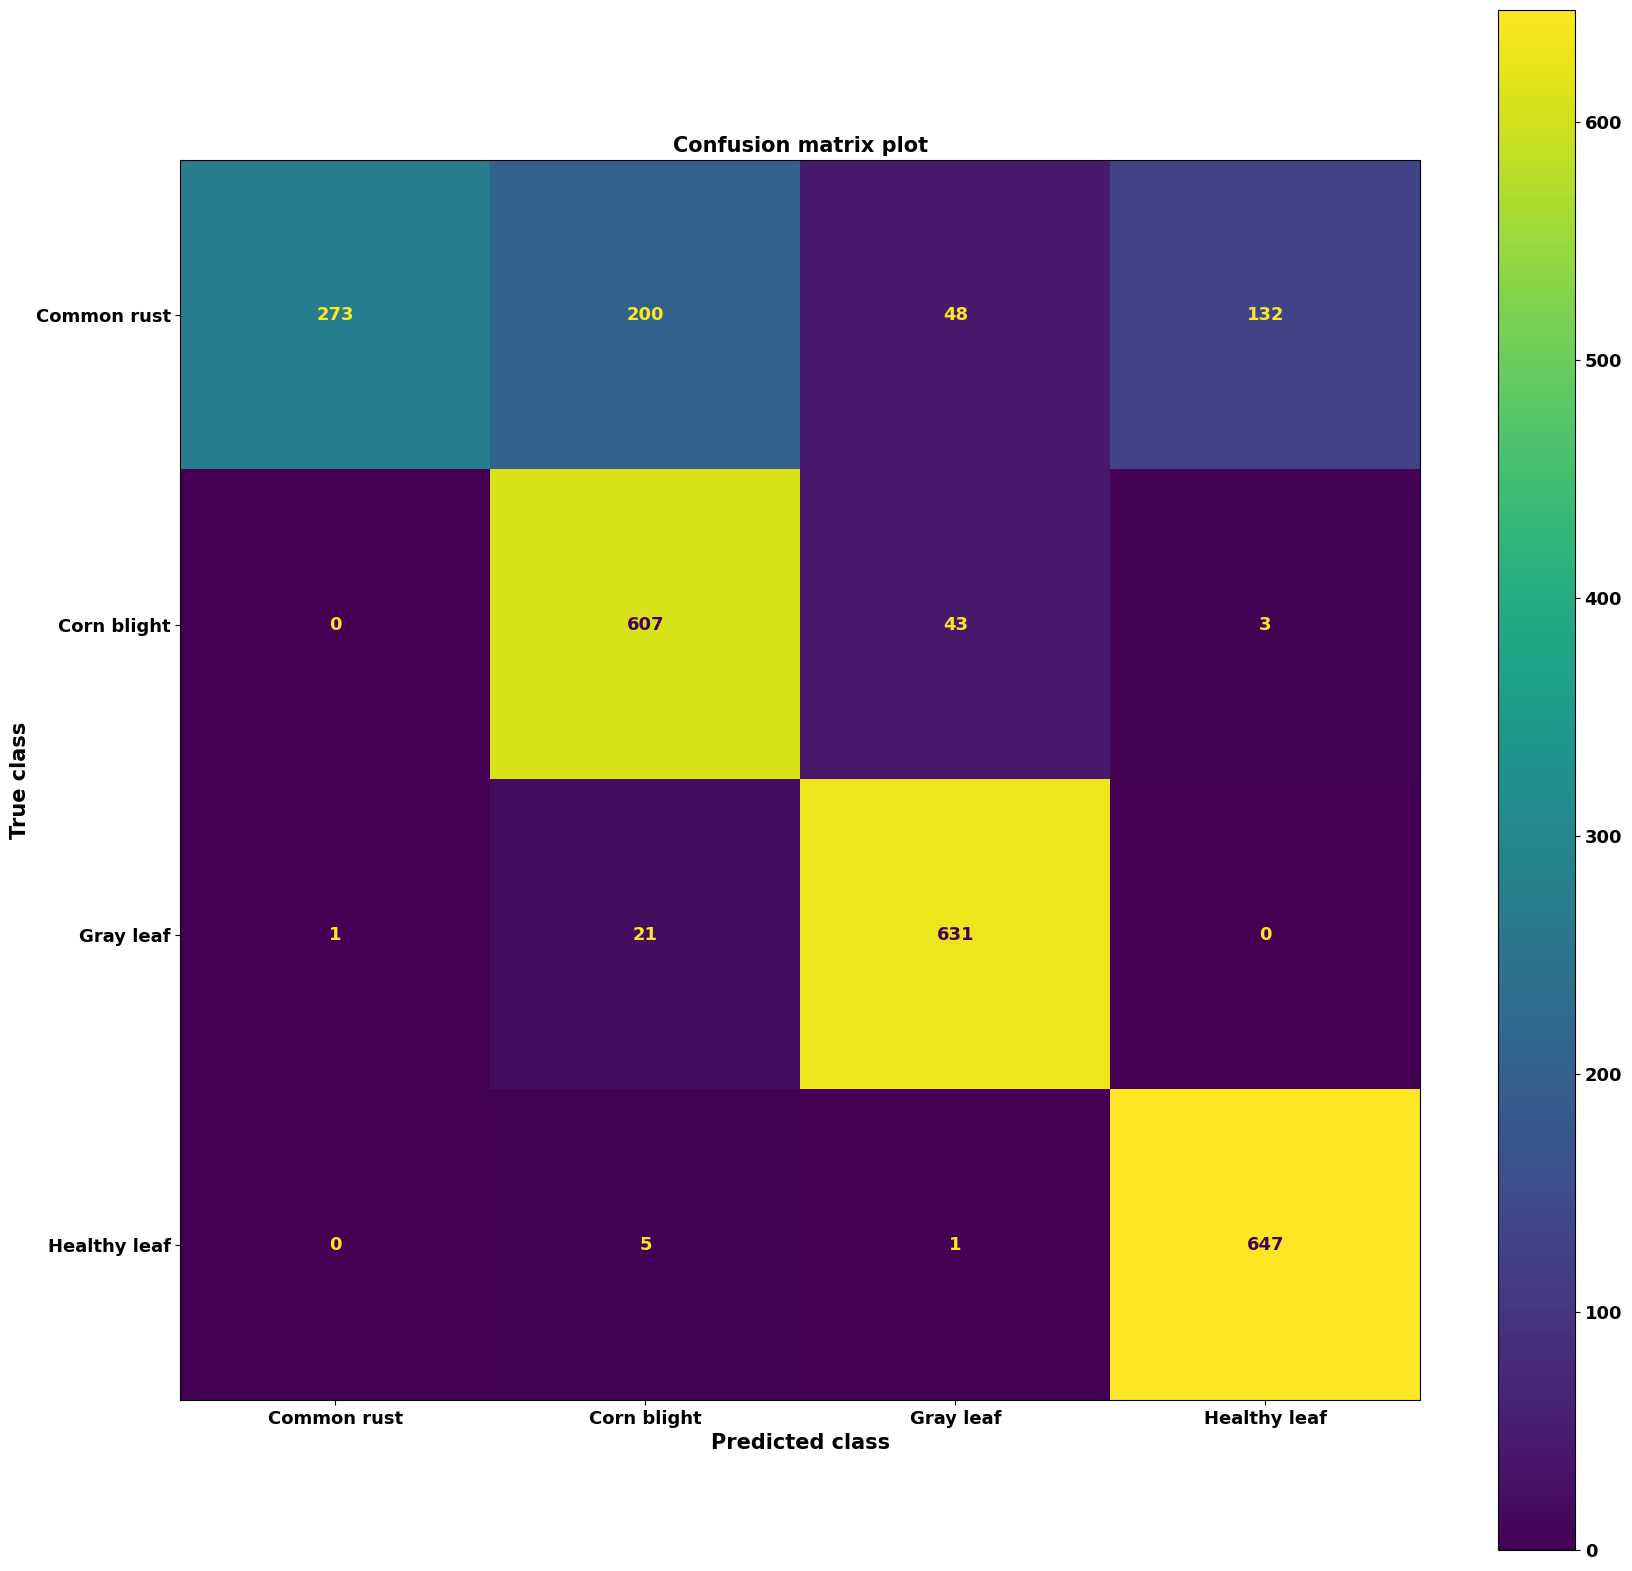

In [64]:
# model= keras.models.load_model(filepath= os.path.join(model_folder_path, "multi_classification_EfficientNetB0.h5"))
vizualize_model_performance(model)

In [65]:
del model
keras.backend.clear_session()
gc.collect()

78169

In [59]:
# Using Transfer learning
conv_base= efficientnet.keras.EfficientNetB7(weights= "imagenet", include_top= False, input_shape= (256, 256, 3))
conv_base.trainable= False # we do not want to train the weights again so we are freezing the conv layer.

# EfficientNetB7 model
model= keras.models.Sequential()
model.add(conv_base)
model.add(keras.layers.Conv2D(filters= 32, kernel_size= (3, 3), strides= 1, padding= 'valid', activation= 'relu',
                              input_shape= (256, 256, 3) ))
model.add(keras.layers.MaxPooling2D( (2, 2) ))
model.add(keras.layers.Flatten())  # We need single one dimensional array as input
model.add(keras.layers.Dropout(0.5)) # It will randomly pick 50 % of neurons and deactivate them during each epoch and model will be trained with the
# remaining neurons. Dropout is a very effective layer to avoid overfitting in model
model.add(keras.layers.Dense(256, activation= 'relu'))
model.add(keras.layers.Dense(200, activation= 'relu'))
model.add(keras.layers.Dense(4, activation= 'softmax'))    # For binary classes classification

In [60]:
# Compiling and model training
t3= time.time()
model.compile(loss= "categorical_crossentropy", optimizer= keras.optimizers.Adam(learning_rate= 1e-4), metrics= ['accuracy'])
model_history= model.fit(train_generator, steps_per_epoch= (train_length// batch_size), epochs= 25, validation_data= validation_generator, validation_steps=
                         (validation_length// batch_size))
t4= time.time()

Epoch 1/25
2850/2850 [==============================] - 782s 270ms/step - loss: 0.5886 - accuracy: 0.7588 - val_loss: 0.3164 - val_accuracy: 0.8720
Epoch 2/25
2850/2850 [==============================] - 768s 269ms/step - loss: 0.4202 - accuracy: 0.8400 - val_loss: 0.2414 - val_accuracy: 0.8940
Epoch 3/25
2850/2850 [==============================] - 772s 271ms/step - loss: 0.3419 - accuracy: 0.8663 - val_loss: 0.2036 - val_accuracy: 0.9180
Epoch 4/25
2850/2850 [==============================] - 767s 269ms/step - loss: 0.3228 - accuracy: 0.8768 - val_loss: 0.2197 - val_accuracy: 0.9160
Epoch 5/25
2850/2850 [==============================] - 757s 266ms/step - loss: 0.3180 - accuracy: 0.8842 - val_loss: 0.1902 - val_accuracy: 0.9300
Epoch 6/25
2850/2850 [==============================] - 755s 265ms/step - loss: 0.2835 - accuracy: 0.8895 - val_loss: 0.1733 - val_accuracy: 0.9340
Epoch 7/25
2850/2850 [==============================] - 757s 266ms/step - loss: 0.2759 - accuracy: 0.8991 - val_

In [61]:
print('Training time is :', round((t4- t3)/ 60 , 3), 'minutes.')   # For EfficientNetB7 model

Training time is : 317.377 minutes.


In [62]:
# Saving - Restoring Models
model_folder_path= os.path.join(os.getcwd(), "Saved models")
model.save(os.path.join(model_folder_path, "multi_classification_EfficientNetB7.h5"))

# Testing model on test set
model.evaluate(test_generator, steps= (test_length// batch_size)) # test_steps= (200// 2= 100)

165/165 [==============================] - 40s 243ms/step - loss: 0.1012 - accuracy: 0.9667


[0.10119148343801498, 0.9666666388511658]

1/1 [==============================] - 9s 9s/step
Prediction is : Common rust
1/1 [==============================] - 1s 763ms/step
Prediction is : Common rust
1/1 [==============================] - 1s 752ms/step
Prediction is : Common rust
1/1 [==============================] - 1s 761ms/step
Prediction is : Common rust
1/1 [==============================] - 1s 776ms/step
Prediction is : Common rust
1/1 [==============================] - 1s 800ms/step
Prediction is : Common rust
1/1 [==============================] - 1s 818ms/step
Prediction is : Common rust
1/1 [==============================] - 1s 809ms/step
Prediction is : Common rust
1/1 [==============================] - 1s 793ms/step
Prediction is : Common rust
1/1 [==============================] - 1s 773ms/step
Prediction is : Common rust
1/1 [==============================] - 1s 739ms/step
Prediction is : Common rust
1/1 [==============================] - 1s 775ms/step
Prediction is : Common rust
1/1 [==========================

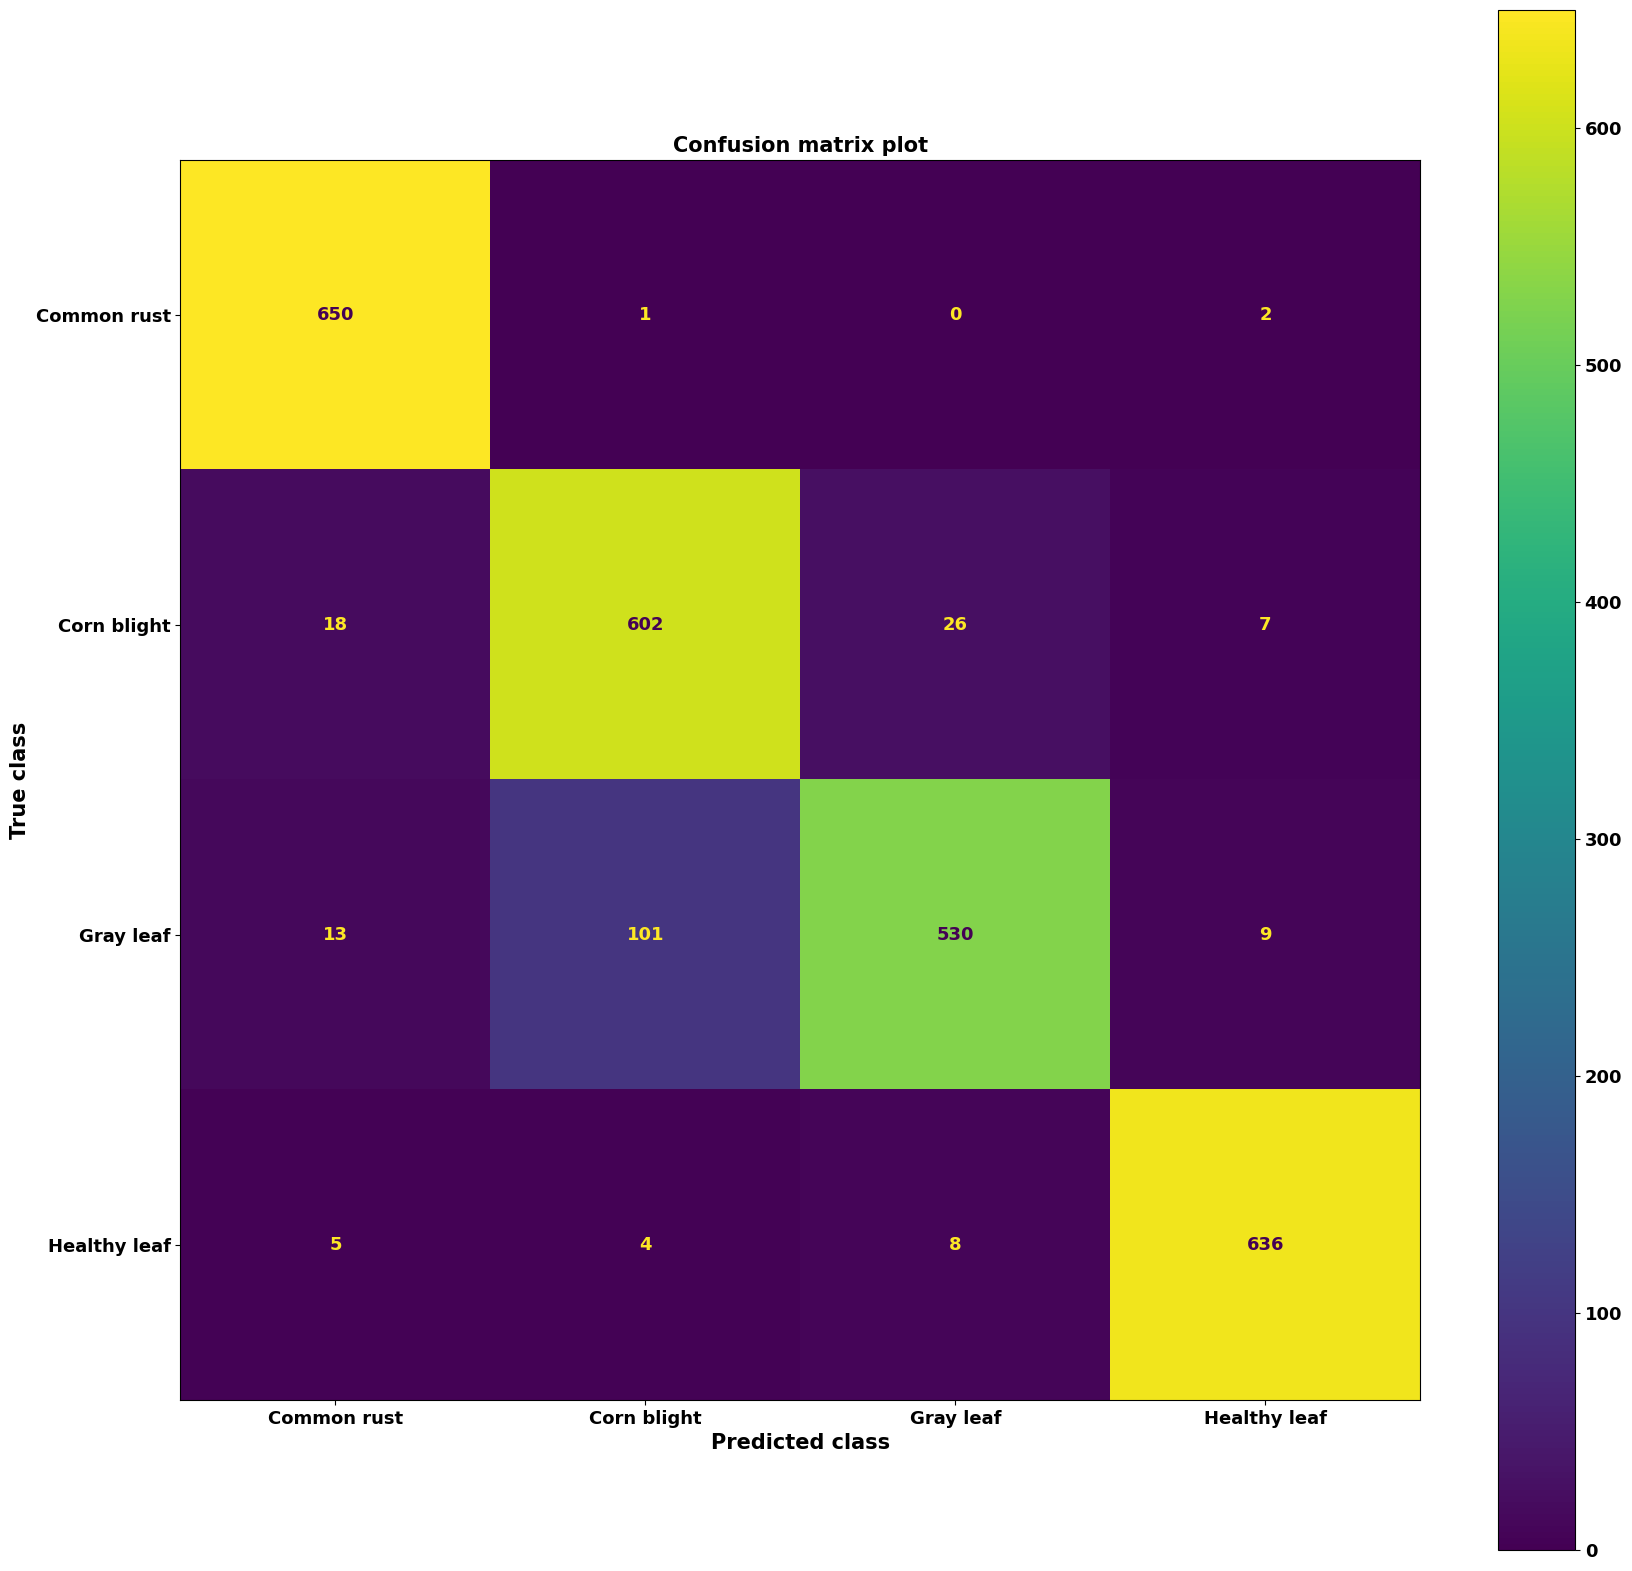

In [66]:
# model= keras.models.load_model(filepath= os.path.join(model_folder_path, "multi_classification_EfficientNetB7.h5"))
vizualize_model_performance(model)

In [67]:
del model
keras.backend.clear_session()
gc.collect()

190530

In [21]:
# Using Transfer learning
conv_base= tensorflow.keras.applications.EfficientNetV2S(weights= "imagenet", include_top= False, input_shape= (256, 256, 3))
conv_base.trainable= False # we do not want to train the weights again so we are freezing the conv layer.

# EfficientNetV2S model
model= keras.models.Sequential()
model.add(conv_base)
model.add(keras.layers.Conv2D(filters= 32, kernel_size= (3, 3), strides= 1, padding= 'valid', activation= 'relu',
                              input_shape= (256, 256, 3) ))
model.add(keras.layers.MaxPooling2D( (2, 2) ))
model.add(keras.layers.Flatten())  # We need single one dimensional array as input
model.add(keras.layers.Dropout(0.5)) # It will randomly pick 50 % of neurons and deactivate them during each epoch and model will be trained with the
# remaining neurons. Dropout is a very effective layer to avoid overfitting in model
model.add(keras.layers.Dense(256, activation= 'relu'))
model.add(keras.layers.Dense(200, activation= 'relu'))
model.add(keras.layers.Dense(4, activation= 'softmax'))    # For binary classes classification

82420632/82420632 [==============================] - 7s 0us/step


In [22]:
# Compiling and model training
t3= time.time()
model.compile(loss= "categorical_crossentropy", optimizer= keras.optimizers.Adam(learning_rate= 1e-4), metrics= ['accuracy'])
model_history= model.fit(train_generator, steps_per_epoch= (train_length// batch_size), epochs= 25, validation_data= validation_generator, validation_steps=
                         (validation_length// batch_size))
t4= time.time()

Epoch 1/25
2850/2850 [==============================] - 281s 96ms/step - loss: 1.7024 - accuracy: 0.3011 - val_loss: 1.1755 - val_accuracy: 0.4980
Epoch 2/25
2850/2850 [==============================] - 267s 94ms/step - loss: 1.6059 - accuracy: 0.3889 - val_loss: 1.1722 - val_accuracy: 0.4820
Epoch 3/25
2850/2850 [==============================] - 272s 95ms/step - loss: 1.6282 - accuracy: 0.4233 - val_loss: 1.2664 - val_accuracy: 0.4400
Epoch 4/25
2850/2850 [==============================] - 272s 95ms/step - loss: 1.6699 - accuracy: 0.4272 - val_loss: 1.1824 - val_accuracy: 0.4620
Epoch 5/25
2850/2850 [==============================] - 273s 96ms/step - loss: 1.6430 - accuracy: 0.4402 - val_loss: 1.2304 - val_accuracy: 0.4720
Epoch 6/25
2850/2850 [==============================] - 273s 96ms/step - loss: 1.6314 - accuracy: 0.4563 - val_loss: 1.0467 - val_accuracy: 0.5500
Epoch 7/25
2850/2850 [==============================] - 274s 96ms/step - loss: 1.5887 - accuracy: 0.4646 - val_loss: 1

In [23]:
print('Training time is :', round((t4- t3)/ 60 , 3), 'minutes.')   # For EfficientNetV2S model

Training time is : 113.912 minutes.


In [24]:
# Saving - Restoring Models
model_folder_path= os.path.join(os.getcwd(), "Saved models")
model.save(os.path.join(model_folder_path, "multi_classification_EfficientNetV2S.h5"))

# Testing model on test set
model.evaluate(test_generator, steps= (test_length// batch_size)) # test_steps= (200// 2= 100)

165/165 [==============================] - 14s 83ms/step - loss: 1.3617 - accuracy: 0.4667


[1.3616687059402466, 0.46666666865348816]

1/1 [==============================] - 4s 4s/step
Prediction is : Healthy leaf
1/1 [==============================] - 0s 271ms/step
Prediction is : Corn blight
1/1 [==============================] - 0s 275ms/step
Prediction is : Healthy leaf
1/1 [==============================] - 0s 286ms/step
Prediction is : Healthy leaf
1/1 [==============================] - 0s 266ms/step
Prediction is : Healthy leaf
1/1 [==============================] - 0s 263ms/step
Prediction is : Healthy leaf
1/1 [==============================] - 0s 275ms/step
Prediction is : Healthy leaf
1/1 [==============================] - 0s 263ms/step
Prediction is : Corn blight
1/1 [==============================] - 0s 264ms/step
Prediction is : Healthy leaf
1/1 [==============================] - 0s 288ms/step
Prediction is : Healthy leaf
1/1 [==============================] - 0s 264ms/step
Prediction is : Healthy leaf
1/1 [==============================] - 0s 273ms/step
Prediction is : Common rust
1/1 [=================

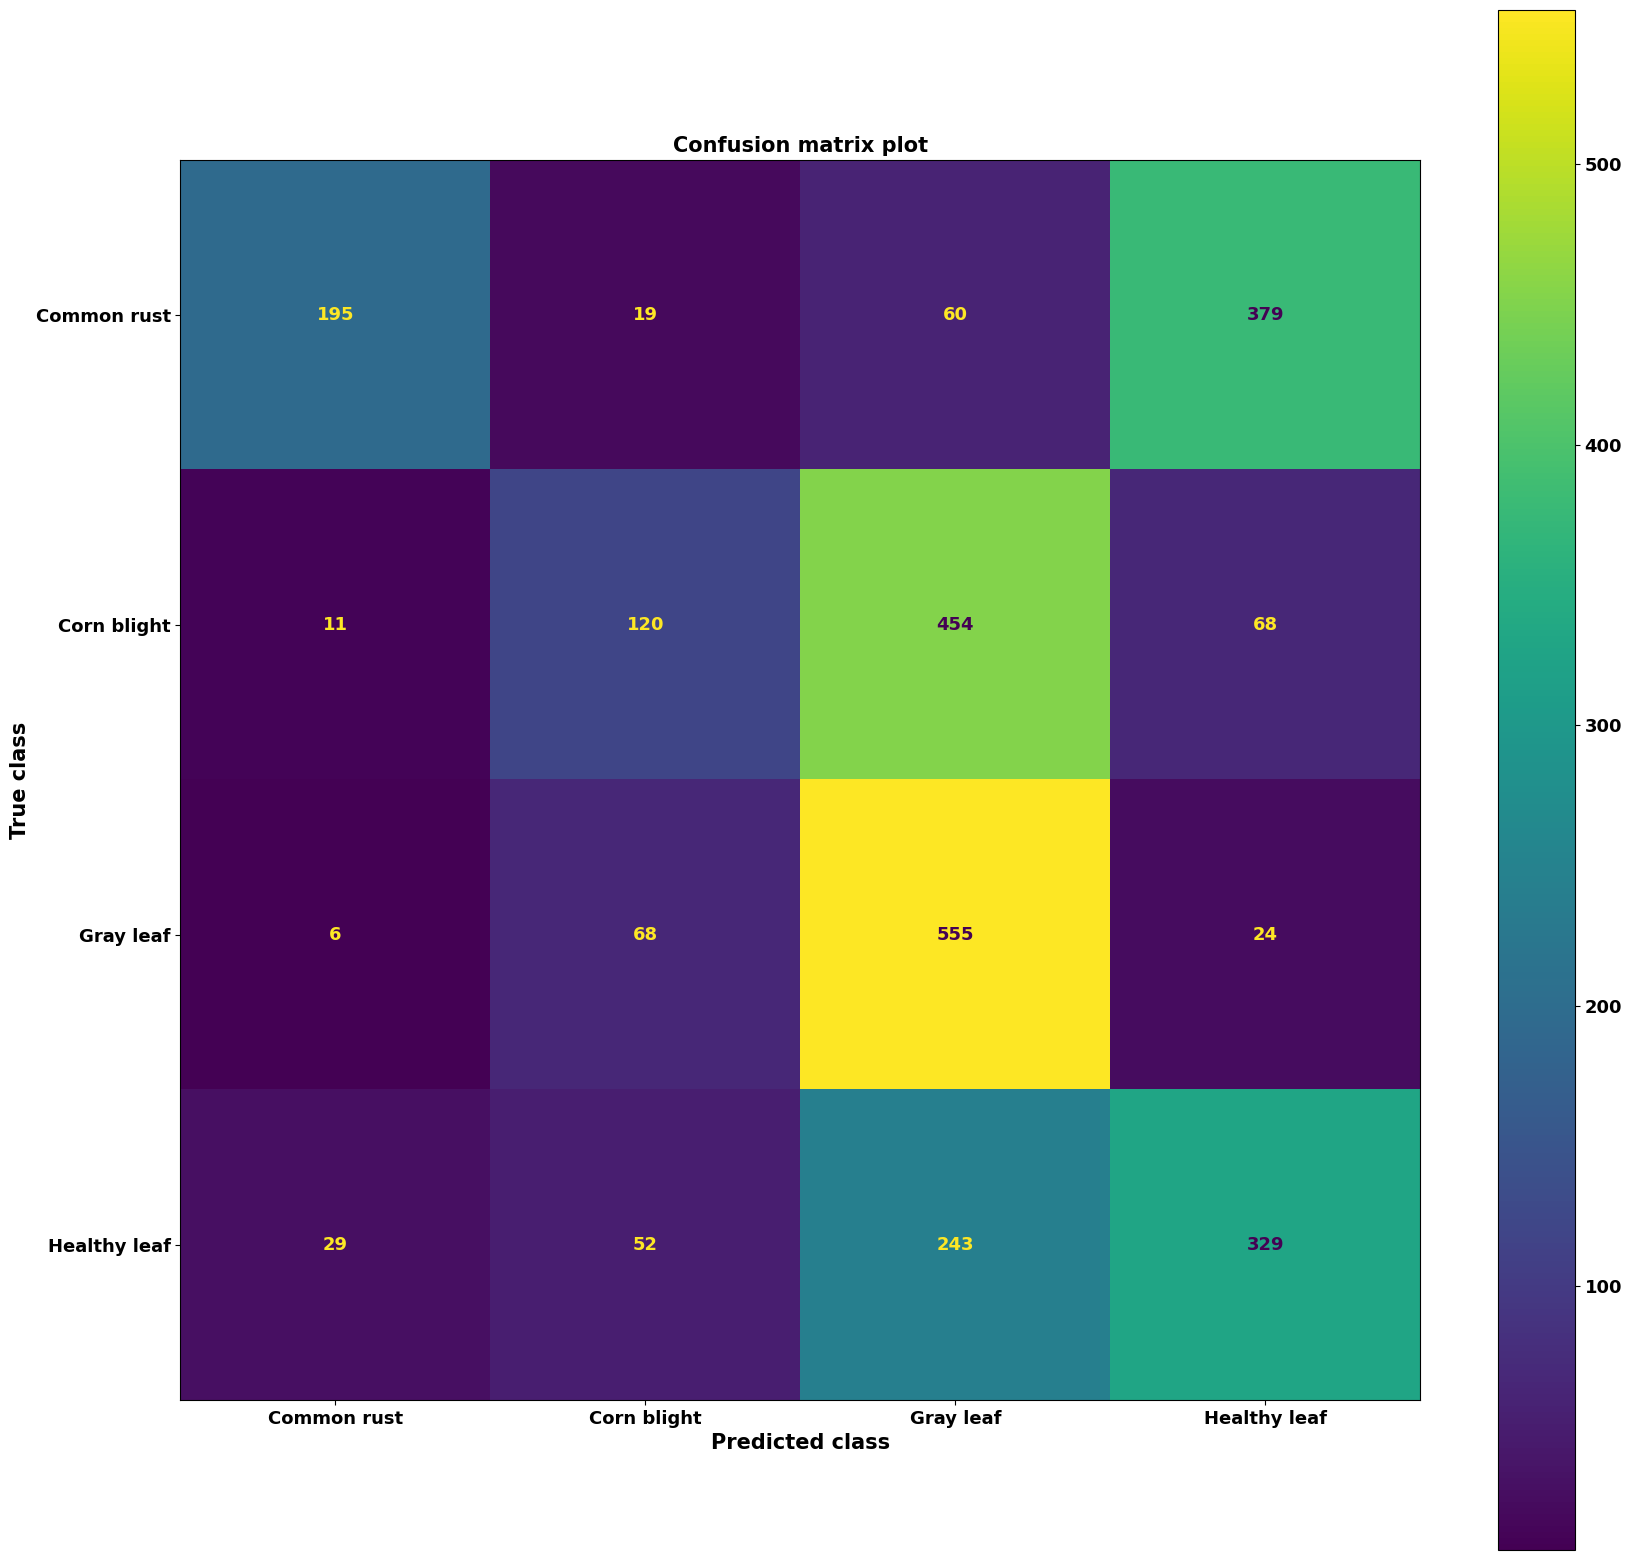

In [68]:
# model= keras.models.load_model(filepath= os.path.join(model_folder_path, "multi_classification_EfficientNetV2S.h5"))
vizualize_model_performance(model)

In [69]:
del model
keras.backend.clear_session()
gc.collect()

122197

In [64]:
# Using Transfer learning
conv_base= tensorflow.keras.applications.DenseNet169(weights= "imagenet", include_top= False, input_shape= (256, 256, 3))
conv_base.trainable= False # we do not want to train the weights again so we are freezing the conv layer.

# DenseNet169 model
model= keras.models.Sequential()
model.add(conv_base)
model.add(keras.layers.Conv2D(filters= 32, kernel_size= (3, 3), strides= 1, padding= 'valid', activation= 'relu',
                              input_shape= (256, 256, 3) ))
model.add(keras.layers.MaxPooling2D( (2, 2) ))
model.add(keras.layers.Flatten())  # We need single one dimensional array as input
model.add(keras.layers.Dropout(0.5)) # It will randomly pick 50 % of neurons and deactivate them during each epoch and model will be trained with the
# remaining neurons. Dropout is a very effective layer to avoid overfitting in model
model.add(keras.layers.Dense(256, activation= 'relu'))
model.add(keras.layers.Dense(200, activation= 'relu'))
model.add(keras.layers.Dense(4, activation= 'softmax'))    # For binary classes classification

In [65]:
# Compiling and model training
t3= time.time()
model.compile(loss= "categorical_crossentropy", optimizer= keras.optimizers.Adam(learning_rate= 1e-4), metrics= ['accuracy'])
model_history= model.fit(train_generator, steps_per_epoch= (train_length// batch_size), epochs= 25, validation_data= validation_generator, validation_steps=
                         (validation_length// batch_size))
t4= time.time()

Epoch 1/25
2850/2850 [==============================] - 316s 109ms/step - loss: 0.3513 - accuracy: 0.8498 - val_loss: 0.1937 - val_accuracy: 0.9180
Epoch 2/25
2850/2850 [==============================] - 288s 101ms/step - loss: 0.1984 - accuracy: 0.9219 - val_loss: 0.1316 - val_accuracy: 0.9420
Epoch 3/25
2850/2850 [==============================] - 290s 102ms/step - loss: 0.1673 - accuracy: 0.9340 - val_loss: 0.1132 - val_accuracy: 0.9600
Epoch 4/25
2850/2850 [==============================] - 290s 102ms/step - loss: 0.1402 - accuracy: 0.9458 - val_loss: 0.1248 - val_accuracy: 0.9440
Epoch 5/25
2850/2850 [==============================] - 288s 101ms/step - loss: 0.1254 - accuracy: 0.9511 - val_loss: 0.0881 - val_accuracy: 0.9700
Epoch 6/25
2850/2850 [==============================] - 288s 101ms/step - loss: 0.1060 - accuracy: 0.9607 - val_loss: 0.1007 - val_accuracy: 0.9560
Epoch 7/25
2850/2850 [==============================] - 288s 101ms/step - loss: 0.1100 - accuracy: 0.9596 - val_

In [66]:
print('Training time is :', round((t4- t3)/ 60 , 3), 'minutes.')   # For DenseNet169 model

Training time is : 120.516 minutes.


In [67]:
# Saving - Restoring Models
model_folder_path= os.path.join(os.getcwd(), "Saved models")
model.save(os.path.join(model_folder_path, "multi_classification_DenseNet169.h5"))

# Testing model on test set
model.evaluate(test_generator, steps= (test_length// batch_size)) # test_steps= (200// 2= 100)

165/165 [==============================] - 15s 92ms/step - loss: 0.0725 - accuracy: 0.9697


[0.07246387004852295, 0.9696969985961914]

1/1 [==============================] - 11s 11s/step
Prediction is : Common rust
1/1 [==============================] - 1s 777ms/step
Prediction is : Common rust
1/1 [==============================] - 1s 805ms/step
Prediction is : Common rust
1/1 [==============================] - 1s 849ms/step
Prediction is : Common rust
1/1 [==============================] - 1s 672ms/step
Prediction is : Common rust
1/1 [==============================] - 1s 748ms/step
Prediction is : Common rust
1/1 [==============================] - 1s 764ms/step
Prediction is : Common rust
1/1 [==============================] - 1s 676ms/step
Prediction is : Common rust
1/1 [==============================] - 1s 661ms/step
Prediction is : Common rust
1/1 [==============================] - 1s 671ms/step
Prediction is : Common rust
1/1 [==============================] - 1s 626ms/step
Prediction is : Common rust
1/1 [==============================] - 1s 570ms/step
Prediction is : Common rust
1/1 [========================

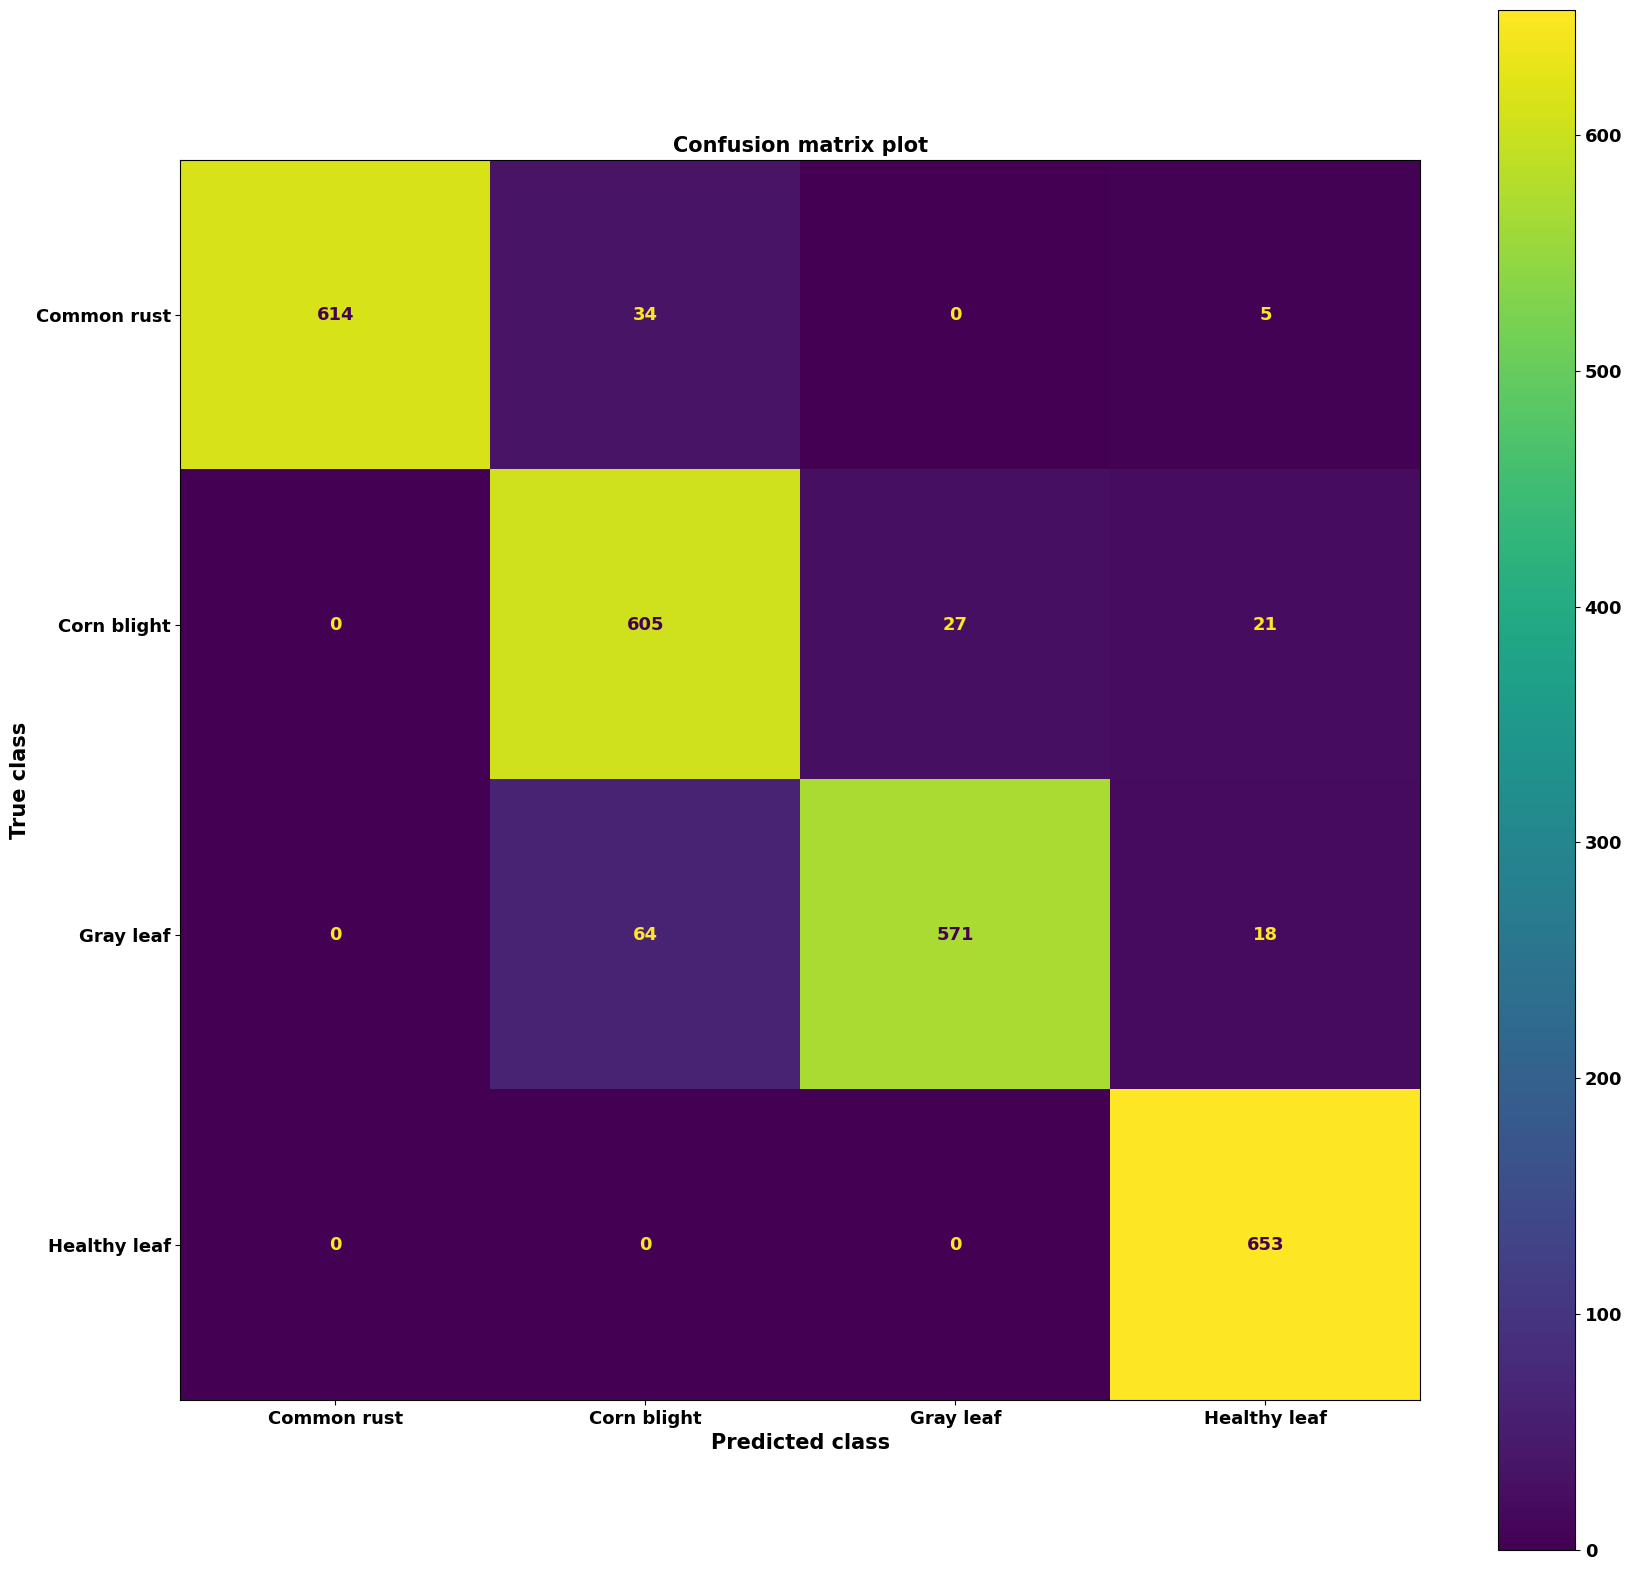

In [70]:
# model= keras.models.load_model(filepath= os.path.join(model_folder_path, "multi_classification_DenseNet169.h5"))
vizualize_model_performance(model)

In [71]:
del model
keras.backend.clear_session()
gc.collect()

120805

In [69]:
# Using Transfer learning
conv_base= tensorflow.keras.applications.DenseNet201(weights= "imagenet", include_top= False, input_shape= (256, 256, 3))
conv_base.trainable= False # we do not want to train the weights again so we are freezing the conv layer.

# DenseNet201 model
model= keras.models.Sequential()
model.add(conv_base)
model.add(keras.layers.Conv2D(filters= 32, kernel_size= (3, 3), strides= 1, padding= 'valid', activation= 'relu',
                              input_shape= (256, 256, 3) ))
model.add(keras.layers.MaxPooling2D( (2, 2) ))
model.add(keras.layers.Flatten())  # We need single one dimensional array as input
model.add(keras.layers.Dropout(0.5)) # It will randomly pick 50 % of neurons and deactivate them during each epoch and model will be trained with the
# remaining neurons. Dropout is a very effective layer to avoid overfitting in model
model.add(keras.layers.Dense(256, activation= 'relu'))
model.add(keras.layers.Dense(200, activation= 'relu'))
model.add(keras.layers.Dense(4, activation= 'softmax'))    # For binary classes classification

In [70]:
# Compiling and model training
t3= time.time()
model.compile(loss= "categorical_crossentropy", optimizer= keras.optimizers.Adam(learning_rate= 1e-4), metrics= ['accuracy'])
model_history= model.fit(train_generator, steps_per_epoch= (train_length// batch_size), epochs= 25, validation_data= validation_generator, validation_steps=
                         (validation_length// batch_size))
t4= time.time()

Epoch 1/25
2850/2850 [==============================] - 378s 130ms/step - loss: 0.3539 - accuracy: 0.8498 - val_loss: 0.1602 - val_accuracy: 0.9440
Epoch 2/25
2850/2850 [==============================] - 369s 129ms/step - loss: 0.1912 - accuracy: 0.9221 - val_loss: 0.1308 - val_accuracy: 0.9340
Epoch 3/25
2850/2850 [==============================] - 372s 131ms/step - loss: 0.1508 - accuracy: 0.9400 - val_loss: 0.1438 - val_accuracy: 0.9360
Epoch 4/25
2850/2850 [==============================] - 368s 129ms/step - loss: 0.1361 - accuracy: 0.9467 - val_loss: 0.0945 - val_accuracy: 0.9640
Epoch 5/25
2850/2850 [==============================] - 367s 129ms/step - loss: 0.1159 - accuracy: 0.9558 - val_loss: 0.0857 - val_accuracy: 0.9700
Epoch 6/25
2850/2850 [==============================] - 367s 129ms/step - loss: 0.0980 - accuracy: 0.9639 - val_loss: 0.1003 - val_accuracy: 0.9660
Epoch 7/25
2850/2850 [==============================] - 367s 129ms/step - loss: 0.0972 - accuracy: 0.9626 - val_

In [71]:
print('Training time is :', round((t4- t3)/ 60 , 3), 'minutes.')   # For DenseNet201 model

Training time is : 153.305 minutes.


In [72]:
# Saving - Restoring Models
model_folder_path= os.path.join(os.getcwd(), "Saved models")
model.save(os.path.join(model_folder_path, "multi_classification_DenseNet201.h5"))

# Testing model on test set
model.evaluate(test_generator, steps= (test_length// batch_size)) # test_steps= (200// 2= 100)

165/165 [==============================] - 19s 117ms/step - loss: 0.0297 - accuracy: 0.9879


[0.029686132445931435, 0.9878787994384766]

1/1 [==============================] - 4s 4s/step
Prediction is : Common rust
1/1 [==============================] - 0s 484ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 475ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 455ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 473ms/step
Prediction is : Common rust
1/1 [==============================] - 1s 549ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 482ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 469ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 465ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 482ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 460ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 477ms/step
Prediction is : Common rust
1/1 [==========================

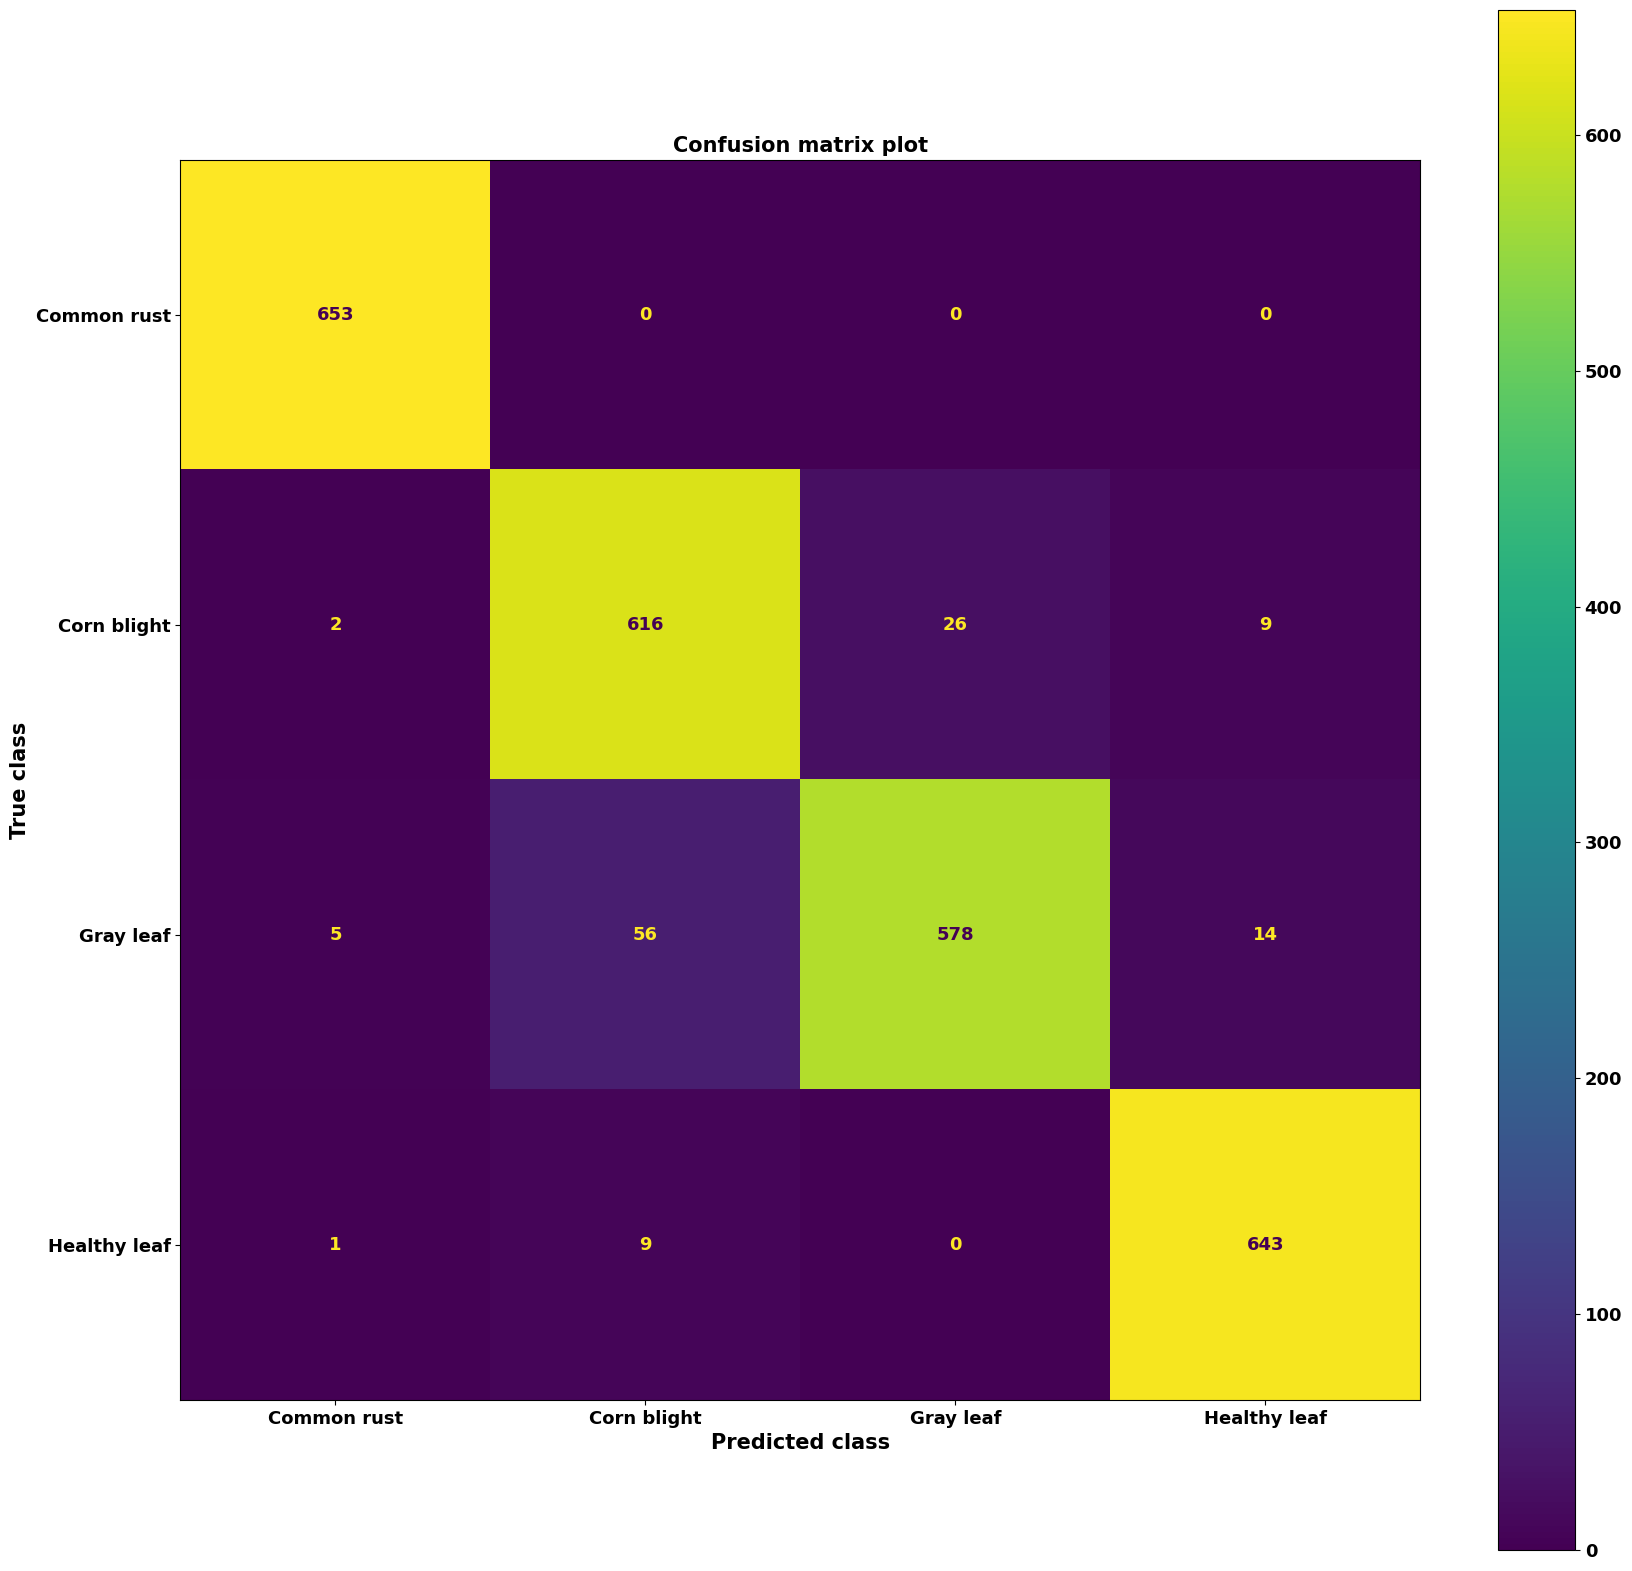

In [72]:
# model= keras.models.load_model(filepath= os.path.join(model_folder_path, "multi_classification_DenseNet201.h5"))
vizualize_model_performance(model)

In [73]:
del model
keras.backend.clear_session()
gc.collect()

142445

In [15]:
# Using Transfer learning
conv_base= tensorflow.keras.applications.Xception(weights= "imagenet", include_top= False, input_shape= (256, 256, 3))
conv_base.trainable= False # we do not want to train the weights again so we are freezing the conv layer.

# Xception model
model= keras.models.Sequential()
model.add(conv_base)
model.add(keras.layers.Conv2D(filters= 32, kernel_size= (3, 3), strides= 1, padding= 'valid', activation= 'relu',
                              input_shape= (256, 256, 3) ))
model.add(keras.layers.MaxPooling2D( (2, 2) ))
model.add(keras.layers.Flatten())  # We need single one dimensional array as input
model.add(keras.layers.Dropout(0.5)) # It will randomly pick 50 % of neurons and deactivate them during each epoch and model will be trained with the
# remaining neurons. Dropout is a very effective layer to avoid overfitting in model
model.add(keras.layers.Dense(256, activation= 'relu'))
model.add(keras.layers.Dense(200, activation= 'relu'))
model.add(keras.layers.Dense(4, activation= 'softmax'))    # For binary classes classification

In [16]:
# Compiling and model training
t3= time.time()
model.compile(loss= "categorical_crossentropy", optimizer= keras.optimizers.Adam(learning_rate= 1e-4), metrics= ['accuracy'])
model_history= model.fit(train_generator, steps_per_epoch= (train_length// batch_size), epochs= 25, validation_data= validation_generator, validation_steps=
                         (validation_length// batch_size))
t4= time.time()

Epoch 1/25
2850/2850 [==============================] - 290s 101ms/step - loss: 0.5013 - accuracy: 0.7979 - val_loss: 0.3787 - val_accuracy: 0.8680
Epoch 2/25
2850/2850 [==============================] - 288s 101ms/step - loss: 0.3823 - accuracy: 0.8646 - val_loss: 0.2358 - val_accuracy: 0.9020
Epoch 3/25
2850/2850 [==============================] - 291s 102ms/step - loss: 0.3336 - accuracy: 0.8791 - val_loss: 0.2446 - val_accuracy: 0.9220
Epoch 4/25
2850/2850 [==============================] - 290s 102ms/step - loss: 0.3513 - accuracy: 0.8851 - val_loss: 0.3264 - val_accuracy: 0.8940
Epoch 5/25
2850/2850 [==============================] - 287s 101ms/step - loss: 0.3405 - accuracy: 0.8907 - val_loss: 0.2438 - val_accuracy: 0.9260
Epoch 6/25
2850/2850 [==============================] - 288s 101ms/step - loss: 0.3423 - accuracy: 0.8991 - val_loss: 0.3217 - val_accuracy: 0.9160
Epoch 7/25
2850/2850 [==============================] - 289s 101ms/step - loss: 0.3068 - accuracy: 0.9061 - val_

In [17]:
print('Training time is :', round((t4- t3)/ 60 , 3), 'minutes.')   # For Xception model

Training time is : 120.566 minutes.


In [18]:
# Saving - Restoring Models
model_folder_path= os.path.join(os.getcwd(), "Saved models")
model.save(os.path.join(model_folder_path, "multi_classification_Xception.h5"))

# Testing model on test set
model.evaluate(test_generator, steps= (test_length// batch_size)) # test_steps= (200// 2= 100)

165/165 [==============================] - 15s 91ms/step - loss: 0.2501 - accuracy: 0.9576


[0.2501331567764282, 0.9575757384300232]

1/1 [==============================] - 1s 1s/step
Prediction is : Common rust
1/1 [==============================] - 0s 271ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 275ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 264ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 286ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 258ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 256ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 275ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 256ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 254ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 290ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 318ms/step
Prediction is : Common rust
1/1 [==========================

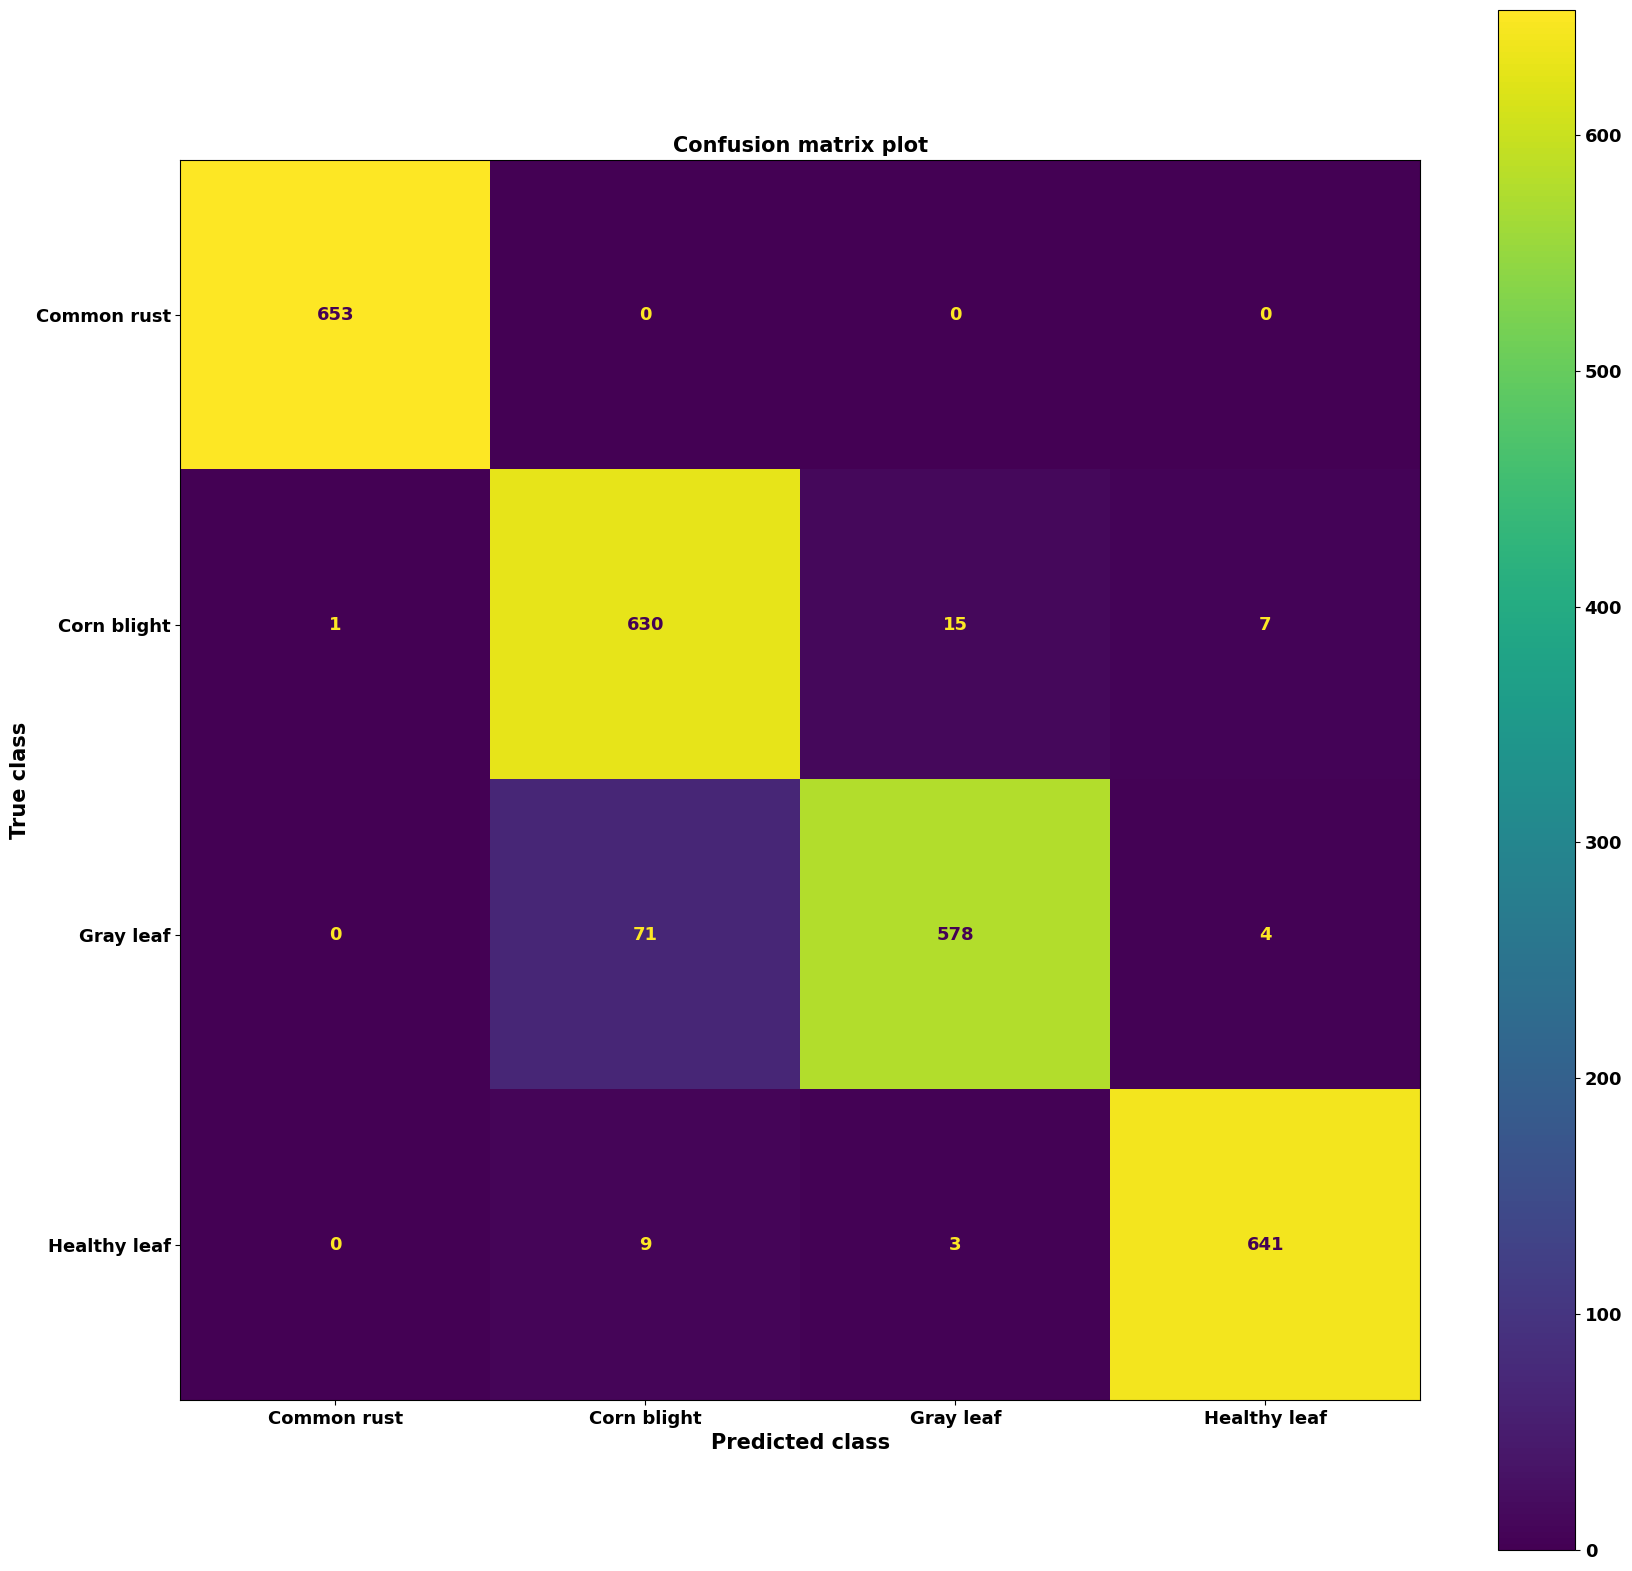

In [74]:
# model= keras.models.load_model(filepath= os.path.join(model_folder_path, "multi_classification_Xception.h5"))
vizualize_model_performance(model)

In [75]:
del model
keras.backend.clear_session()
gc.collect()

43015

In [20]:
# Using Transfer learning
conv_base= tensorflow.keras.applications.MobileNet(weights= "imagenet", include_top= False, input_shape= (256, 256, 3))
conv_base.trainable= False # we do not want to train the weights again so we are freezing the conv layer.

# MobileNet model
model= keras.models.Sequential()
model.add(conv_base)
model.add(keras.layers.Conv2D(filters= 32, kernel_size= (3, 3), strides= 1, padding= 'valid', activation= 'relu',
                              input_shape= (256, 256, 3) ))
model.add(keras.layers.MaxPooling2D( (2, 2) ))
model.add(keras.layers.Flatten())  # We need single one dimensional array as input
model.add(keras.layers.Dropout(0.5)) # It will randomly pick 50 % of neurons and deactivate them during each epoch and model will be trained with the
# remaining neurons. Dropout is a very effective layer to avoid overfitting in model
model.add(keras.layers.Dense(256, activation= 'relu'))
model.add(keras.layers.Dense(200, activation= 'relu'))
model.add(keras.layers.Dense(4, activation= 'softmax'))    # For binary classes classification

In [21]:
# Compiling and model training
t3= time.time()
model.compile(loss= "categorical_crossentropy", optimizer= keras.optimizers.Adam(learning_rate= 1e-4), metrics= ['accuracy'])
model_history= model.fit(train_generator, steps_per_epoch= (train_length// batch_size), epochs= 25, validation_data= validation_generator, validation_steps=
                         (validation_length// batch_size))
t4= time.time()

Epoch 1/25
2850/2850 [==============================] - 90s 31ms/step - loss: 0.5137 - accuracy: 0.7951 - val_loss: 0.2533 - val_accuracy: 0.9060
Epoch 2/25
2850/2850 [==============================] - 88s 31ms/step - loss: 0.3331 - accuracy: 0.8854 - val_loss: 0.2108 - val_accuracy: 0.9160
Epoch 3/25
2850/2850 [==============================] - 88s 31ms/step - loss: 0.3125 - accuracy: 0.9026 - val_loss: 0.2863 - val_accuracy: 0.9260
Epoch 4/25
2850/2850 [==============================] - 88s 31ms/step - loss: 0.3016 - accuracy: 0.9035 - val_loss: 0.2369 - val_accuracy: 0.9340
Epoch 5/25
2850/2850 [==============================] - 88s 31ms/step - loss: 0.2887 - accuracy: 0.9095 - val_loss: 0.1938 - val_accuracy: 0.9300
Epoch 6/25
2850/2850 [==============================] - 88s 31ms/step - loss: 0.2766 - accuracy: 0.9156 - val_loss: 0.2257 - val_accuracy: 0.9360
Epoch 7/25
2850/2850 [==============================] - 88s 31ms/step - loss: 0.3187 - accuracy: 0.9109 - val_loss: 0.2373 -

In [22]:
print('Training time is :', round((t4- t3)/ 60 , 3), 'minutes.')   # For MobileNet model

Training time is : 36.668 minutes.


In [23]:
# Saving - Restoring Models
model_folder_path= os.path.join(os.getcwd(), "Saved models")
model.save(os.path.join(model_folder_path, "multi_classification_MobileNet.h5"))

# Testing model on test set
model.evaluate(test_generator, steps= (test_length// batch_size)) # test_steps= (200// 2= 100)

165/165 [==============================] - 4s 21ms/step - loss: 0.1725 - accuracy: 0.9485


[0.17247341573238373, 0.9484848380088806]

1/1 [==============================] - 1s 879ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 141ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 126ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 112ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 97ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 137ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 120ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 88ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 121ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 122ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 99ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 109ms/step
Prediction is : Common rust
1/1 [==========================

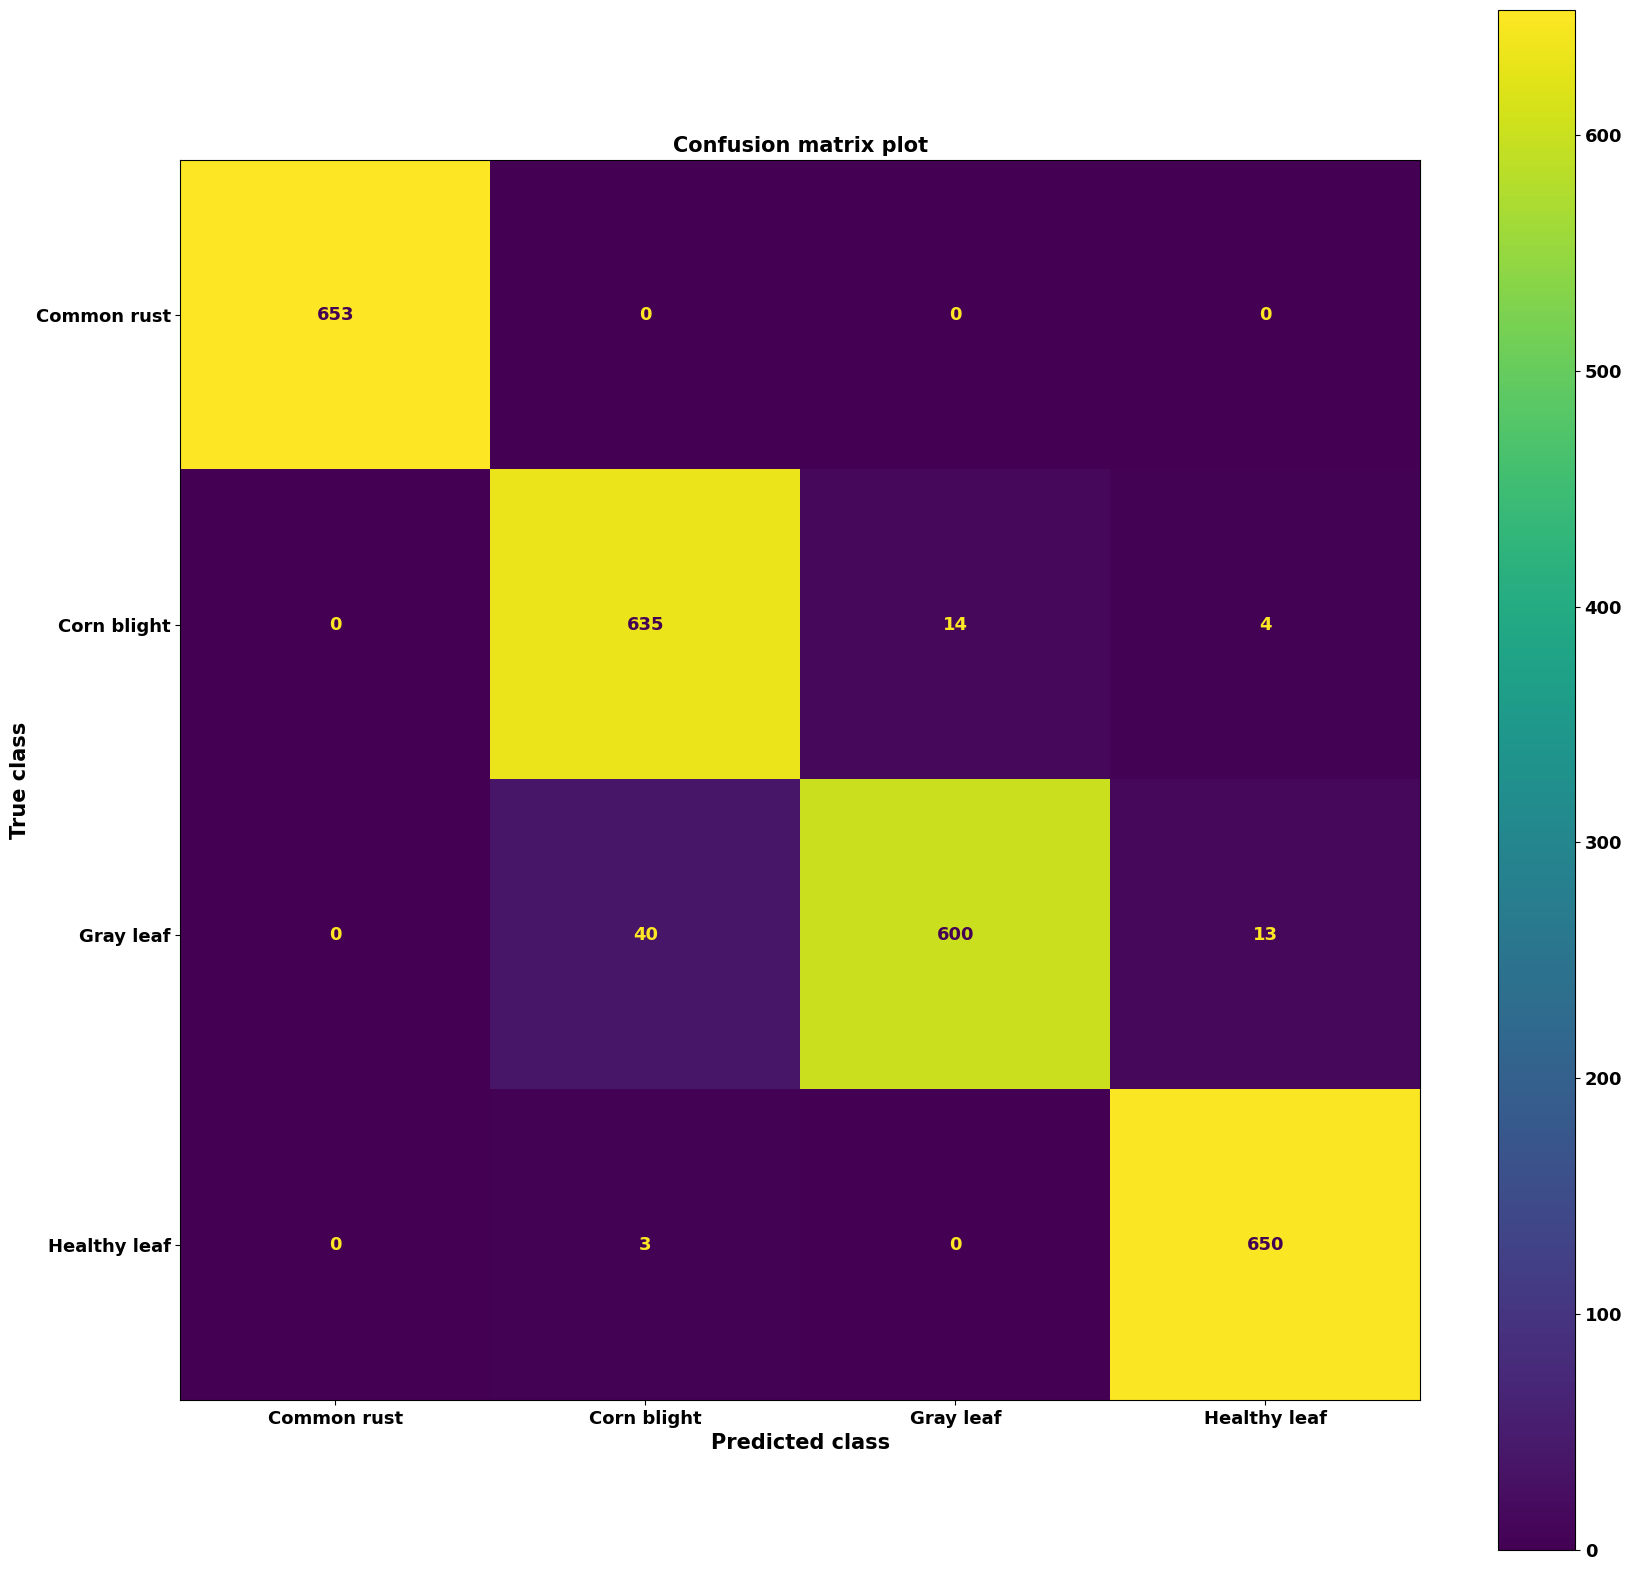

In [76]:
# model= keras.models.load_model(filepath= os.path.join(model_folder_path, "multi_classification_MobileNet.h5"))
vizualize_model_performance(model)

In [77]:
del model
keras.backend.clear_session()
gc.collect()

25168

In [11]:
abcde

NameError: name 'abcde' is not defined

In [17]:
# Using ensemble technique
model_folder_path= os.path.join(os.getcwd(), "Saved models")
model_1= keras.models.load_model(filepath= os.path.join(model_folder_path, "multi_classification_Xception.h5"))
model_1 = tensorflow.keras.models.Model(inputs= model_1.inputs, outputs= model_1.outputs, name= "Xception")
model_2= keras.models.load_model(filepath= os.path.join(model_folder_path, "multi_classification_MobileNet.h5"))
model_2 = tensorflow.keras.models.Model(inputs= model_2.inputs, outputs= model_2.outputs, name= "MobileNet")
models = [model_1, model_2]
model_input = tensorflow.keras.layers.Input(shape= (256, 256, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = tensorflow.keras.layers.Average()(model_outputs)
ensemble_model = tensorflow.keras.models.Model(inputs= model_input, outputs= ensemble_output, name= "ensemble")

In [18]:
ensemble_model.summary()

Model: "ensemble"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 Xception (Functional)       (None, 4)                    2157752   ['input_1[0][0]']             
                                                          4                                       
                                                                                                  
 MobileNet (Functional)      (None, 4)                    3649996   ['input_1[0][0]']             
                                                                                                  
 average (Average)           (None, 4)                    0         ['Xception[0][0]',     

In [19]:
ensemble_model.compile(loss= "categorical_crossentropy", optimizer= keras.optimizers.Adam(learning_rate= 1e-4), metrics=['accuracy'])
t3= time.time()
model_history= ensemble_model.fit(train_generator, steps_per_epoch= (train_length// batch_size), epochs= 25, validation_data= validation_generator, validation_steps=
                         (validation_length// batch_size))
t4= time.time() # Ending of model training

Epoch 1/25


2850/2850 [==============================] - 484s 169ms/step - loss: 0.1385 - accuracy: 0.9565 - val_loss: 0.0995 - val_accuracy: 0.9660
Epoch 2/25
2850/2850 [==============================] - 285s 100ms/step - loss: 0.1221 - accuracy: 0.9621 - val_loss: 0.0677 - val_accuracy: 0.9820
Epoch 3/25
2850/2850 [==============================] - 283s 99ms/step - loss: 0.1229 - accuracy: 0.9582 - val_loss: 0.0868 - val_accuracy: 0.9780
Epoch 4/25
2850/2850 [==============================] - 284s 100ms/step - loss: 0.1246 - accuracy: 0.9579 - val_loss: 0.0873 - val_accuracy: 0.9720
Epoch 5/25
2850/2850 [==============================] - 284s 100ms/step - loss: 0.1348 - accuracy: 0.9588 - val_loss: 0.0646 - val_accuracy: 0.9820
Epoch 6/25
2850/2850 [==============================] - 284s 100ms/step - loss: 0.1097 - accuracy: 0.9616 - val_loss: 0.1029 - val_accuracy: 0.9660
Epoch 7/25
2850/2850 [==============================] - 283s 99ms/step - loss: 0.1115 - accuracy: 0.9640 - val_

In [20]:
print('Training time is :', round((t4- t3)/ 60 , 3), 'minutes.')   # For Ensemble model

Training time is : 124.568 minutes.


In [25]:
# Saving - Restoring Models
model_folder_path= os.path.join(os.getcwd(), "Saved models")
try:
    ensemble_model.save(filepath= os.path.join(model_folder_path, "multi_classification_ensemble_model.h5"), overwrite= True)
except Exception as error:
    print("Error occured is :", error)
# Testing model on test set
model.evaluate(test_generator, steps= (test_length// batch_size)) # test_steps= (200// 2= 100)

165/165 [==============================] - 17s 99ms/step - loss: 0.0709 - accuracy: 0.9818


[0.07094825059175491, 0.9818181991577148]

1/1 [==============================] - 2s 2s/step
Prediction is : Common rust
1/1 [==============================] - 0s 352ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 358ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 323ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 343ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 353ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 333ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 376ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 353ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 357ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 355ms/step
Prediction is : Common rust
1/1 [==============================] - 0s 328ms/step
Prediction is : Common rust
1/1 [==========================

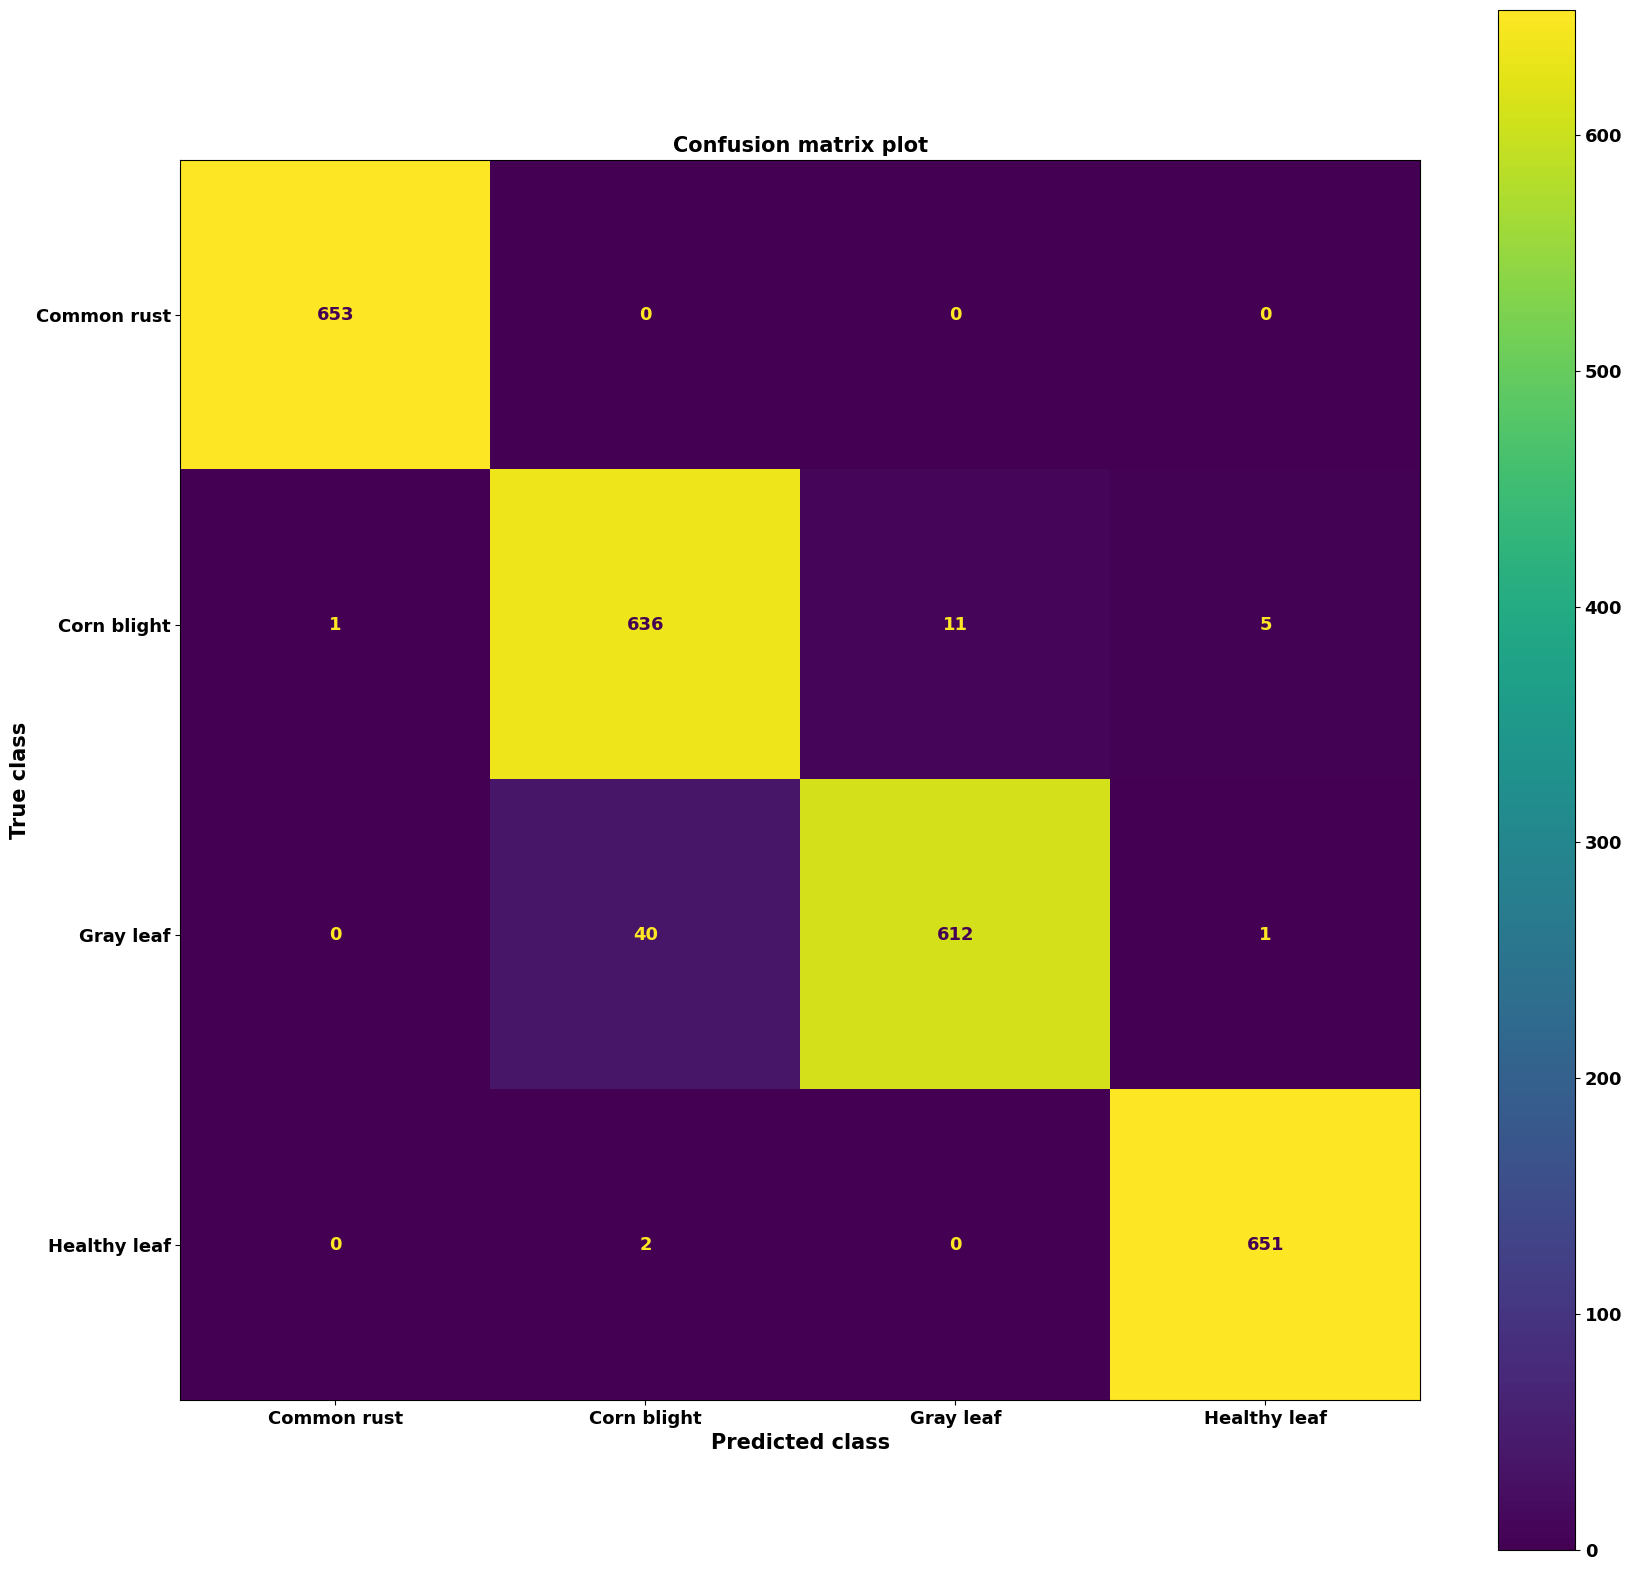

In [78]:
# model= keras.models.load_model(filepath= os.path.join(model_folder_path, "multi_classification_ensemble_model.h5"))
vizualize_model_performance(model)

In [79]:
# del (model_1, model_2, ensemble_model)
del model
keras.backend.clear_session()
gc.collect()

66239

In [ ]:
# CNN, VGG19, VGG16, InceptionV3, ResNet50, ResNet152, EfficientNetB0, DenseNet161, DenseNet201, Xception, MobileNet, ensemble_model

In [22]:
# from sklearn.metrics import jaccard_score

In [23]:
y_true= ["glioma", "pituitary", "pituitary", "glioma", "pituitary", "pituitary", "glioma", "meningioma", "pituitary"]
y_pred= ["glioma", "pituitary", "glioma", "glioma", "glioma", "pituitary", "glioma", "glioma", "pituitary"]

In [24]:
def dice_coefficient(y_true, y_pred):
    intersection = numpy.sum(y_true * y_pred)
    return (2. * intersection) / (numpy.sum(y_true) + numpy.sum(y_pred))
def dice_coefficient(y_true, y_pred):
    jaccard = skimage.metrics.jaccard_score(y_true.flatten(), y_pred.flatten())
    return 2* jaccard / (1 + jaccard)
# dice_coefficient(y_true, y_pred)

In [13]:
print(train_generator.class_indices)
print(validation_generator.class_indices)
print(test_generator.class_indices)

{'Common rust': 0, 'Corn blight': 1, 'Gray leaf': 2, 'Healthy leaf': 3}
{'Common rust': 0, 'Corn blight': 1, 'Gray leaf': 2, 'Healthy leaf': 3}
{'Common rust': 0, 'Corn blight': 1, 'Gray leaf': 2, 'Healthy leaf': 3}


In [14]:
def prediction_from_model(saved_model_name):
    model_folder_path= os.path.join(os.getcwd(), "Saved models")
    model= keras.models.load_model(filepath= os.path.join(model_folder_path, saved_model_name))
    t1= time.time()
    classes= ["Common rust", "Corn blight", "Gray leaf", "Healthy leaf"]
    prediction_list= []
    testing_folder_path= os.path.join(os.getcwd(), "pred")
    for (index, img) in enumerate(os.listdir(testing_folder_path)):
        image= cv2.imread(filename= os.path.join(testing_folder_path, img))
        image = cv2.normalize(src= image, dst= None, alpha= 0, beta= 1.0, norm_type= cv2.NORM_MINMAX, dtype= cv2.CV_32F)
        image= cv2.resize(src= image, dsize= (256, 256))
        print("\nImage number is :", index+ 1)
    #     plt.imshow(image)
    #     plt.show()
        prediction= model.predict(x= image.reshape(1, 256, 256, 3))
        max_value_index= numpy.argmax(a= prediction[0])
        predicted_class= classes[max_value_index]
        print("Prediction is :", predicted_class)
        prediction_list.append(predicted_class)
    t2= time.time()
    print('Testing time for pred folder is :', round((t2- t1), 3), 'seconds.')
    print("Counter of predictions is :", collections.Counter(prediction_list))
    del model
    keras.backend.clear_session()
    gc.collect()
    return prediction_list

In [15]:
cnn_prediction_list= prediction_from_model("multi_classification_cnn.h5")
gc.collect()




Image number is : 1
1/1 [==============================] - 2s 2s/step
Prediction is : Common rust

Image number is : 2
1/1 [==============================] - 0s 62ms/step
Prediction is : Corn blight

Image number is : 3
1/1 [==============================] - 0s 85ms/step
Prediction is : Common rust

Image number is : 4
1/1 [==============================] - 0s 82ms/step
Prediction is : Corn blight

Image number is : 5
1/1 [==============================] - 0s 68ms/step
Prediction is : Gray leaf

Image number is : 6
1/1 [==============================] - 0s 66ms/step
Prediction is : Corn blight

Image number is : 7
1/1 [==============================] - 0s 54ms/step
Prediction is : Corn blight

Image number is : 8
1/1 [==============================] - 0s 54ms/step
Prediction is : Common rust

Image number is : 9
1/1 [==============================] - 0s 58ms/step
Prediction is : Corn blight

Image number is : 10
1/1 [==============================] - 0s 52ms/step
Prediction is : Hea

0

In [16]:
vgg19_prediction_list= prediction_from_model("multi_classification_vgg19.h5")
gc.collect()


Image number is : 1
1/1 [==============================] - 1s 1s/step
Prediction is : Common rust

Image number is : 2
1/1 [==============================] - 1s 671ms/step
Prediction is : Healthy leaf

Image number is : 3
1/1 [==============================] - 1s 672ms/step
Prediction is : Healthy leaf

Image number is : 4
1/1 [==============================] - 1s 672ms/step
Prediction is : Healthy leaf

Image number is : 5
1/1 [==============================] - 1s 656ms/step
Prediction is : Healthy leaf

Image number is : 6
1/1 [==============================] - 1s 672ms/step
Prediction is : Healthy leaf

Image number is : 7
1/1 [==============================] - 1s 733ms/step
Prediction is : Corn blight

Image number is : 8
1/1 [==============================] - 1s 697ms/step
Prediction is : Healthy leaf

Image number is : 9
1/1 [==============================] - 1s 670ms/step
Prediction is : Corn blight

Image number is : 10
1/1 [==============================] - 1s 676ms/step
Pred

0

In [17]:
vgg16_prediction_list= prediction_from_model("multi_classification_vgg16.h5")
gc.collect()


Image number is : 1
1/1 [==============================] - 1s 903ms/step
Prediction is : Common rust

Image number is : 2
1/1 [==============================] - 1s 531ms/step
Prediction is : Corn blight

Image number is : 3
1/1 [==============================] - 1s 578ms/step
Prediction is : Corn blight

Image number is : 4
1/1 [==============================] - 1s 594ms/step
Prediction is : Healthy leaf

Image number is : 5
1/1 [==============================] - 1s 547ms/step
Prediction is : Common rust

Image number is : 6
1/1 [==============================] - 1s 531ms/step
Prediction is : Common rust

Image number is : 7
1/1 [==============================] - 1s 578ms/step
Prediction is : Corn blight

Image number is : 8
1/1 [==============================] - 1s 547ms/step
Prediction is : Healthy leaf

Image number is : 9
1/1 [==============================] - 1s 531ms/step
Prediction is : Corn blight

Image number is : 10
1/1 [==============================] - 1s 531ms/step
Predi

0

In [18]:
inceptionv3_prediction_list= prediction_from_model("multi_classification_InceptionV3.h5")
gc.collect()


Image number is : 1
1/1 [==============================] - 3s 3s/step
Prediction is : Common rust

Image number is : 2
1/1 [==============================] - 0s 187ms/step
Prediction is : Common rust

Image number is : 3
1/1 [==============================] - 0s 187ms/step
Prediction is : Common rust

Image number is : 4
1/1 [==============================] - 0s 187ms/step
Prediction is : Common rust

Image number is : 5
1/1 [==============================] - 0s 188ms/step
Prediction is : Common rust

Image number is : 6
1/1 [==============================] - 0s 187ms/step
Prediction is : Common rust

Image number is : 7
1/1 [==============================] - 0s 172ms/step
Prediction is : Common rust

Image number is : 8
1/1 [==============================] - 0s 203ms/step
Prediction is : Common rust

Image number is : 9
1/1 [==============================] - 0s 234ms/step
Prediction is : Common rust

Image number is : 10
1/1 [==============================] - 0s 208ms/step
Prediction

0

In [19]:
resnet50_prediction_list= prediction_from_model("multi_classification_ResNet50.h5")
gc.collect()


Image number is : 1
1/1 [==============================] - 3s 3s/step
Prediction is : Common rust

Image number is : 2
1/1 [==============================] - 0s 250ms/step
Prediction is : Common rust

Image number is : 3
1/1 [==============================] - 0s 250ms/step
Prediction is : Common rust

Image number is : 4
1/1 [==============================] - 0s 266ms/step
Prediction is : Common rust

Image number is : 5
1/1 [==============================] - 0s 250ms/step
Prediction is : Common rust

Image number is : 6
1/1 [==============================] - 0s 234ms/step
Prediction is : Common rust

Image number is : 7
1/1 [==============================] - 0s 252ms/step
Prediction is : Common rust

Image number is : 8
1/1 [==============================] - 0s 234ms/step
Prediction is : Common rust

Image number is : 9
1/1 [==============================] - 0s 234ms/step
Prediction is : Common rust

Image number is : 10
1/1 [==============================] - 0s 266ms/step
Prediction

0

In [20]:
resnet152_prediction_list= prediction_from_model("multi_classification_ResNet152.h5")
gc.collect()


Image number is : 1
1/1 [==============================] - 7s 7s/step
Prediction is : Healthy leaf

Image number is : 2
1/1 [==============================] - 1s 594ms/step
Prediction is : Healthy leaf

Image number is : 3
1/1 [==============================] - 1s 578ms/step
Prediction is : Healthy leaf

Image number is : 4
1/1 [==============================] - 1s 609ms/step
Prediction is : Common rust

Image number is : 5
1/1 [==============================] - 1s 625ms/step
Prediction is : Healthy leaf

Image number is : 6
1/1 [==============================] - 1s 594ms/step
Prediction is : Gray leaf

Image number is : 7
1/1 [==============================] - 1s 611ms/step
Prediction is : Healthy leaf

Image number is : 8
1/1 [==============================] - 1s 609ms/step
Prediction is : Healthy leaf

Image number is : 9
1/1 [==============================] - 1s 594ms/step
Prediction is : Healthy leaf

Image number is : 10
1/1 [==============================] - 1s 579ms/step
Predi

0

In [21]:
EfficientNetB0_prediction_list= prediction_from_model("multi_classification_EfficientNetB0.h5")
gc.collect()


Image number is : 1
1/1 [==============================] - 3s 3s/step
Prediction is : Common rust

Image number is : 2
1/1 [==============================] - 0s 109ms/step
Prediction is : Healthy leaf

Image number is : 3
1/1 [==============================] - 0s 109ms/step
Prediction is : Common rust

Image number is : 4
1/1 [==============================] - 0s 94ms/step
Prediction is : Corn blight

Image number is : 5
1/1 [==============================] - 0s 94ms/step
Prediction is : Healthy leaf

Image number is : 6
1/1 [==============================] - 0s 109ms/step
Prediction is : Healthy leaf

Image number is : 7
1/1 [==============================] - 0s 94ms/step
Prediction is : Corn blight

Image number is : 8
1/1 [==============================] - 0s 94ms/step
Prediction is : Corn blight

Image number is : 9
1/1 [==============================] - 0s 94ms/step
Prediction is : Corn blight

Image number is : 10
1/1 [==============================] - 0s 109ms/step
Prediction i

0

In [22]:
EfficientNetB7_prediction_list= prediction_from_model("multi_classification_EfficientNetB7.h5")
gc.collect()


Image number is : 1
1/1 [==============================] - 10s 10s/step
Prediction is : Common rust

Image number is : 2
1/1 [==============================] - 1s 703ms/step
Prediction is : Common rust

Image number is : 3
1/1 [==============================] - 1s 609ms/step
Prediction is : Common rust

Image number is : 4
1/1 [==============================] - 1s 719ms/step
Prediction is : Common rust

Image number is : 5
1/1 [==============================] - 1s 828ms/step
Prediction is : Common rust

Image number is : 6
1/1 [==============================] - 1s 632ms/step
Prediction is : Common rust

Image number is : 7
1/1 [==============================] - 1s 641ms/step
Prediction is : Common rust

Image number is : 8
1/1 [==============================] - 1s 594ms/step
Prediction is : Common rust

Image number is : 9
1/1 [==============================] - 1s 594ms/step
Prediction is : Common rust

Image number is : 10
1/1 [==============================] - 1s 531ms/step
Predicti

0

In [23]:
EfficientNetV2S_prediction_list= prediction_from_model("multi_classification_EfficientNetV2S.h5")
gc.collect()


Image number is : 1
1/1 [==============================] - 6s 6s/step
Prediction is : Healthy leaf

Image number is : 2
1/1 [==============================] - 0s 250ms/step
Prediction is : Gray leaf

Image number is : 3
1/1 [==============================] - 0s 250ms/step
Prediction is : Corn blight

Image number is : 4
1/1 [==============================] - 0s 250ms/step
Prediction is : Common rust

Image number is : 5
1/1 [==============================] - 0s 250ms/step
Prediction is : Healthy leaf

Image number is : 6
1/1 [==============================] - 0s 234ms/step
Prediction is : Common rust

Image number is : 7
1/1 [==============================] - 0s 250ms/step
Prediction is : Common rust

Image number is : 8
1/1 [==============================] - 0s 250ms/step
Prediction is : Healthy leaf

Image number is : 9
1/1 [==============================] - 0s 234ms/step
Prediction is : Healthy leaf

Image number is : 10
1/1 [==============================] - 0s 234ms/step
Predicti

0

In [24]:
DenseNet169_prediction_list= prediction_from_model("multi_classification_DenseNet169.h5")
gc.collect()


Image number is : 1
1/1 [==============================] - 6s 6s/step
Prediction is : Common rust

Image number is : 2
1/1 [==============================] - 0s 250ms/step
Prediction is : Common rust

Image number is : 3
1/1 [==============================] - 0s 250ms/step
Prediction is : Common rust

Image number is : 4
1/1 [==============================] - 0s 266ms/step
Prediction is : Common rust

Image number is : 5
1/1 [==============================] - 0s 266ms/step
Prediction is : Common rust

Image number is : 6
1/1 [==============================] - 0s 234ms/step
Prediction is : Common rust

Image number is : 7
1/1 [==============================] - 0s 234ms/step
Prediction is : Corn blight

Image number is : 8
1/1 [==============================] - 0s 250ms/step
Prediction is : Common rust

Image number is : 9
1/1 [==============================] - 0s 219ms/step
Prediction is : Common rust

Image number is : 10
1/1 [==============================] - 0s 219ms/step
Prediction

0

In [25]:
DenseNet201_prediction_list= prediction_from_model("multi_classification_DenseNet201.h5")
gc.collect()


Image number is : 1
1/1 [==============================] - 7s 7s/step
Prediction is : Common rust

Image number is : 2
1/1 [==============================] - 0s 297ms/step
Prediction is : Common rust

Image number is : 3
1/1 [==============================] - 0s 266ms/step
Prediction is : Common rust

Image number is : 4
1/1 [==============================] - 0s 266ms/step
Prediction is : Common rust

Image number is : 5
1/1 [==============================] - 0s 275ms/step
Prediction is : Common rust

Image number is : 6
1/1 [==============================] - 0s 281ms/step
Prediction is : Common rust

Image number is : 7
1/1 [==============================] - 0s 281ms/step
Prediction is : Common rust

Image number is : 8
1/1 [==============================] - 0s 297ms/step
Prediction is : Common rust

Image number is : 9
1/1 [==============================] - 0s 281ms/step
Prediction is : Common rust

Image number is : 10
1/1 [==============================] - 0s 266ms/step
Prediction

0

In [26]:
Xception_prediction_list= prediction_from_model("multi_classification_Xception.h5")
gc.collect()


Image number is : 1
1/1 [==============================] - 2s 2s/step
Prediction is : Common rust

Image number is : 2
1/1 [==============================] - 0s 250ms/step
Prediction is : Common rust

Image number is : 3
1/1 [==============================] - 0s 266ms/step
Prediction is : Common rust

Image number is : 4
1/1 [==============================] - 0s 250ms/step
Prediction is : Common rust

Image number is : 5
1/1 [==============================] - 0s 251ms/step
Prediction is : Common rust

Image number is : 6
1/1 [==============================] - 0s 266ms/step
Prediction is : Common rust

Image number is : 7
1/1 [==============================] - 0s 250ms/step
Prediction is : Common rust

Image number is : 8
1/1 [==============================] - 0s 250ms/step
Prediction is : Common rust

Image number is : 9
1/1 [==============================] - 0s 266ms/step
Prediction is : Common rust

Image number is : 10
1/1 [==============================] - 0s 266ms/step
Prediction

0

In [27]:
MobileNet_prediction_list= prediction_from_model("multi_classification_MobileNet.h5")
gc.collect()


Image number is : 1
1/1 [==============================] - 1s 1s/step
Prediction is : Common rust

Image number is : 2
1/1 [==============================] - 0s 78ms/step
Prediction is : Common rust

Image number is : 3
1/1 [==============================] - 0s 78ms/step
Prediction is : Common rust

Image number is : 4
1/1 [==============================] - 0s 94ms/step
Prediction is : Common rust

Image number is : 5
1/1 [==============================] - 0s 94ms/step
Prediction is : Common rust

Image number is : 6
1/1 [==============================] - 0s 78ms/step
Prediction is : Common rust

Image number is : 7
1/1 [==============================] - 0s 78ms/step
Prediction is : Common rust

Image number is : 8
1/1 [==============================] - 0s 78ms/step
Prediction is : Common rust

Image number is : 9
1/1 [==============================] - 0s 78ms/step
Prediction is : Common rust

Image number is : 10
1/1 [==============================] - 0s 78ms/step
Prediction is : Com

0

In [28]:
ensemble_model_prediction_list= prediction_from_model("multi_classification_ensemble_model.h5")
gc.collect()


Image number is : 1
1/1 [==============================] - 3s 3s/step
Prediction is : Common rust

Image number is : 2
1/1 [==============================] - 0s 281ms/step
Prediction is : Common rust

Image number is : 3
1/1 [==============================] - 0s 281ms/step
Prediction is : Common rust

Image number is : 4
1/1 [==============================] - 0s 281ms/step
Prediction is : Common rust

Image number is : 5
1/1 [==============================] - 0s 283ms/step
Prediction is : Common rust

Image number is : 6
1/1 [==============================] - 0s 297ms/step
Prediction is : Common rust

Image number is : 7
1/1 [==============================] - 0s 281ms/step
Prediction is : Common rust

Image number is : 8
1/1 [==============================] - 0s 281ms/step
Prediction is : Common rust

Image number is : 9
1/1 [==============================] - 0s 281ms/step
Prediction is : Common rust

Image number is : 10
1/1 [==============================] - 0s 281ms/step
Prediction

0

In [29]:
def set_worksheet_style(worksheet, cell_range):
    thin = openpyxl.styles.Side(border_style= "thin", color= "000000")
#     for i in range(max_rows):
#         worksheet.row_dimensions[i].height = 18
    for row in worksheet[cell_range]:
        for cell in row:
            cell.border = openpyxl.styles.Border(top= thin, left= thin, right= thin, bottom= thin)
            cell.font = openpyxl.styles.Font(name= "Arial", size= 14, color= "000000", bold= False)
            cell.alignment = openpyxl.styles.Alignment(wrap_text= True, horizontal= "center", vertical= "center")
    worksheet.column_dimensions["A"].width = 12
    worksheet.column_dimensions["B"].width = 43
    worksheet.column_dimensions["C"].width = 12
    worksheet.column_dimensions["D"].width = 12
    worksheet.column_dimensions["E"].width = 12
    worksheet.column_dimensions["F"].width = 12
    worksheet.column_dimensions["G"].width = 12
    worksheet.column_dimensions["H"].width = 12
    worksheet.column_dimensions["I"].width = 12
    worksheet.column_dimensions["J"].width = 12
    worksheet.column_dimensions["K"].width = 12
    worksheet.column_dimensions["L"].width = 12
    worksheet.column_dimensions["M"].width = 12
    worksheet.column_dimensions["N"].width = 12
    worksheet.column_dimensions["O"].width = 12
    worksheet.column_dimensions["P"].width = 12
    return None

In [30]:
base_folder= r"D:\Files\Data Science\Self projects\Classification projects\Leaf diseases multi classification dataset"
try:
    shutil.rmtree(os.path.join(base_folder, "pred_2"))
except:
    pass
os.mkdir(os.path.join(base_folder, "pred_2"))
for img in os.listdir(os.path.join(base_folder, "pred")):
    image= cv2.imread(filename= os.path.join(base_folder, "pred", img))
    image= cv2.resize(src= image, dsize= (300, 300))
    cv2.imwrite(filename= os.path.join(base_folder, "pred_2", img), img= image)

workbook = openpyxl.Workbook()
worksheet = workbook.worksheets[0]
worksheet["A1"].value= "Prediction output"
worksheet["A1"].font = openpyxl.styles.Font(name= "Arial", size= 16, color='000000', bold=True)
worksheet.merge_cells("A1:E1")
worksheet["A3"].value= "Index"
worksheet["B3"].value= "Image"
worksheet["C3"].value= "CNN"
worksheet["D3"].value= "VGG19"
worksheet["E3"].value= "VGG16"
worksheet["F3"].value= "InceptionV3"
worksheet["G3"].value= "ResNet50"
worksheet["H3"].value= "ResNet152"
worksheet["I3"].value= "EfficientNetB0"
worksheet["J3"].value= "EfficientNetB7"
worksheet["K3"].value= "EfficientNetV2S"
worksheet["L3"].value= "DenseNet169"
worksheet["M3"].value= "DenseNet201"
worksheet["N3"].value= "Xception"
worksheet["O3"].value= "MobileNet"
worksheet["P3"].value= "Ensemble model"

i= 0
for img in os.listdir(os.path.join(base_folder, "pred_2")):
    worksheet["A"+ str(i+ 4)].value= i+ 1
    image = openpyxl.drawing.image.Image(os.path.join(base_folder, "pred_2", img))
    worksheet.row_dimensions[i+ 4].height = 230
    worksheet.add_image(image, "B" + str(i+ 4))
    worksheet["C"+ str(i+ 4)].value= cnn_prediction_list[i]
    worksheet["D"+ str(i+ 4)].value= vgg19_prediction_list[i]
    worksheet["E"+ str(i+ 4)].value= vgg16_prediction_list[i]
    worksheet["F"+ str(i+ 4)].value= inceptionv3_prediction_list[i]
    worksheet["G"+ str(i+ 4)].value= resnet50_prediction_list[i]
    worksheet["H"+ str(i+ 4)].value= resnet152_prediction_list[i]
    worksheet["I"+ str(i+ 4)].value= EfficientNetB0_prediction_list[i]
    worksheet["J"+ str(i+ 4)].value= EfficientNetB7_prediction_list[i]
    worksheet["K"+ str(i+ 4)].value= EfficientNetV2S_prediction_list[i]
    worksheet["L"+ str(i+ 4)].value= DenseNet169_prediction_list[i]
    worksheet["M"+ str(i+ 4)].value= DenseNet201_prediction_list[i]
    worksheet["N"+ str(i+ 4)].value= Xception_prediction_list[i]
    worksheet["O"+ str(i+ 4)].value= MobileNet_prediction_list[i]
    worksheet["P"+ str(i+ 4)].value= ensemble_model_prediction_list[i]
    i= i+ 1

set_worksheet_style( worksheet, "A3:P" + str(i+ 4) )
worksheet["A3"].font = openpyxl.styles.Font(size= 14, color='000000', bold=True)
worksheet["B3"].font = openpyxl.styles.Font(size= 14, color='000000', bold=True)
worksheet["C3"].font = openpyxl.styles.Font(size= 14, color='000000', bold=True)
worksheet["D3"].font = openpyxl.styles.Font(size= 14, color='000000', bold=True)
worksheet["E3"].font = openpyxl.styles.Font(size= 14, color='000000', bold=True)
worksheet["F3"].font = openpyxl.styles.Font(size= 14, color='000000', bold=True)
worksheet["G3"].font = openpyxl.styles.Font(size= 14, color='000000', bold=True)
worksheet["H3"].font = openpyxl.styles.Font(size= 14, color='000000', bold=True)
worksheet["I3"].font = openpyxl.styles.Font(size= 14, color='000000', bold=True)
worksheet["J3"].font = openpyxl.styles.Font(size= 14, color='000000', bold=True)
worksheet["K3"].font = openpyxl.styles.Font(size= 14, color='000000', bold=True)
worksheet["L3"].font = openpyxl.styles.Font(size= 14, color='000000', bold=True)
worksheet["M3"].font = openpyxl.styles.Font(size= 14, color='000000', bold=True)
worksheet["N3"].font = openpyxl.styles.Font(size= 14, color='000000', bold=True)
worksheet["O3"].font = openpyxl.styles.Font(size= 14, color='000000', bold=True)
worksheet["P3"].font = openpyxl.styles.Font(size= 14, color='000000', bold=True)
workbook.save(os.path.join(base_folder, "prediction output multiclass.xlsx"))
print("Output workbook is saved.")

Output workbook is saved.


In [31]:
import termcolor
print(termcolor.colored('Thank you for reading this.', 'green', attrs= ['bold']))

Thank you for reading this.


In [32]:
gc.collect()

0

In [33]:
import pandas
pandas.DataFrame({"CNN": cnn_prediction_list, "VGG19": vgg19_prediction_list, "VGG16": vgg16_prediction_list,
"InceptionV3": inceptionv3_prediction_list, "ResNet50": resnet50_prediction_list, "ResNet152": resnet152_prediction_list,
"EfficientNetB0": EfficientNetB0_prediction_list, "EfficientNetB7": EfficientNetB7_prediction_list, "EfficientNetV2S": EfficientNetV2S_prediction_list,
"DenseNet169": DenseNet169_prediction_list, "DenseNet201": DenseNet201_prediction_list, "Xception": Xception_prediction_list,
        "MobileNet": MobileNet_prediction_list, "Ensemble model": ensemble_model_prediction_list})

CNN         VGG19         VGG16   InceptionV3     ResNet50  \
0     Common rust   Common rust   Common rust   Common rust  Common rust   
1     Corn blight  Healthy leaf   Corn blight   Common rust  Common rust   
2     Common rust  Healthy leaf   Corn blight   Common rust  Common rust   
3     Corn blight  Healthy leaf  Healthy leaf   Common rust  Common rust   
4       Gray leaf  Healthy leaf   Common rust   Common rust  Common rust   
..            ...           ...           ...           ...          ...   
395  Healthy leaf  Healthy leaf  Healthy leaf  Healthy leaf  Common rust   
396  Healthy leaf  Healthy leaf  Healthy leaf  Healthy leaf  Common rust   
397  Healthy leaf  Healthy leaf  Healthy leaf  Healthy leaf  Common rust   
398  Healthy leaf  Healthy leaf  Healthy leaf  Healthy leaf  Common rust   
399  Healthy leaf  Healthy leaf  Healthy leaf  Healthy leaf  Common rust   

        ResNet152 EfficientNetB0 EfficientNetB7 EfficientNetV2S   DenseNet169  \
0    Healthy leaf    Common rust    Common rust    Healthy leaf   Common rust   
1    Healthy leaf   Healthy leaf    Common rust       Gray leaf   Common rust   
2    Healthy leaf    Common rust    Common rust     Corn blight   Common rust   
3     Common rust    Corn blight    Common rust     Common rust   Common rust   
4    Healthy leaf   Healthy leaf    Common rust    Healthy leaf   Common rust   
..            ...            ...            ...             ...           ...   
395  Healthy leaf   Healthy leaf   Healthy leaf       Gray leaf  Healthy leaf   
396   Common rust   Healthy leaf   Healthy leaf    Healthy leaf  Healthy leaf   
397  Healthy leaf   Healthy leaf   Healthy leaf    Healthy leaf  Healthy leaf   
398  Healthy leaf   Healthy leaf   Healthy leaf    Healthy leaf  Healthy leaf   
399  Healthy leaf   Healthy leaf   Healthy leaf    Healthy leaf  Healthy leaf   

      DenseNet201      Xception     MobileNet Ensemble model  
0     Common rust   Common rust   Common rust    Common rust  
1     Common rust   Common rust   Common rust    Common rust  
2     Common rust   Common rust   Common rust    Common rust  
3     Common rust   Common rust   Common rust    Common rust  
4     Common rust   Common rust   Common rust    Common rust  
..            ...           ...           ...            ...  
395  Healthy leaf  Healthy leaf  Healthy leaf   Healthy leaf  
396  Healthy leaf  Healthy leaf  Healthy leaf   Healthy leaf  
397  Healthy leaf  Healthy leaf  Healthy leaf   Healthy leaf  
398  Healthy leaf  Healthy leaf  Healthy leaf   Healthy leaf  
399  Healthy leaf  Healthy leaf  Healthy leaf   Healthy leaf  

[400 rows x 14 columns]

In [34]:
abcde

NameError: name 'abcde' is not defined

In [45]:
os.chdir(r"D:\Files\Data Science\Self projects\Classification projects\Leaf diseases multi classification dataset")
os.getcwd()

'D:\\Files\\Data Science\\Self projects\\Classification projects\\Leaf diseases multi classification dataset'

In [56]:
item_names= [(str(x) + ".jpeg") for x in numpy.arange(start= 0, stop= 6530, step= 1)]
random.shuffle(x= item_names)

In [57]:
folder_name= "Healthy leaf"
for (i, item) in enumerate(iterable= os.listdir(os.path.join(os.getcwd(), folder_name)), start= 0):
    os.rename(src= os.path.join(os.getcwd(), folder_name, item), dst= os.path.join(os.getcwd(), folder_name, (folder_name + "_" + item_names[i])))